In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="5"
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

import time
import numpy as np
import gc
import sys
sys.setrecursionlimit(50000)
import pickle
import random
torch.set_default_tensor_type('torch.cuda.FloatTensor')
torch.nn.Module.dump_patches = True
import copy
import pandas as pd
from sklearn.model_selection import KFold

#then import my own modules
# from AttentiveFP import Fingerprint, Fingerprint_viz, save_smiles_dicts, get_smiles_dicts, get_smiles_array, moltosvg_highlight
from timeit import default_timer as timer
from AttentiveFP.featurizing import graph_dict
from AttentiveFP.AttentiveLayers_new3 import Fingerprint, graph_dataset, null_collate, Graph, Logger, time_to_str



In [2]:
cuda_aviable = torch.cuda.is_available()
device = torch.device(0)

SEED = 28
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.benchmark = True
torch.backends.cudnn.enabled = True
torch.backends.cudnn.deterministic=True


In [3]:
from rdkit import Chem
# from rdkit.Chem import AllChem
from rdkit.Chem import QED
from rdkit.Chem import rdMolDescriptors, MolSurf
from rdkit.Chem.Draw import SimilarityMaps
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import rdDepictor
from rdkit.Chem.Draw import rdMolDraw2D
%matplotlib inline
from numpy.polynomial.polynomial import polyfit
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib.cm as cm
import matplotlib
import seaborn as sns; sns.set_style("darkgrid")
from IPython.display import SVG, display
import sascorer
import itertools
from sklearn.metrics import r2_score
import scipy

number of all smiles:  133885
number of successfully processed smiles:  133247


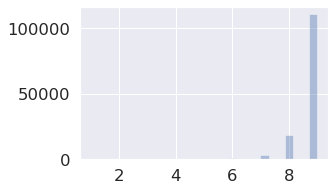

In [4]:
task_name = 'qm9'
tasks = [
   "mu","alpha","homo","lumo","gap","r2","zpve","u0","u298","h298","g298","cv"
]

raw_filename = "../data/gdb9_smiles.csv"
filename = raw_filename.replace('.csv','')
prefix_filename = raw_filename.split('/')[-1].replace('.csv','')
smiles_tasks_df = pd.read_csv(raw_filename)

smilesList = smiles_tasks_df.smiles.values
print("number of all smiles: ", len(smilesList))
atom_num_dist = []
remained_smiles = []
canonical_smiles_list = []
for smiles in smilesList:
    try:        
        mol = Chem.MolFromSmiles(smiles)
        atom_num_dist.append(len(mol.GetAtoms()))
        remained_smiles.append(smiles)
        canonical_smiles_list.append(Chem.MolToSmiles(Chem.MolFromSmiles(smiles), isomericSmiles=True))
    except:
#         print(smiles)
        pass
print("number of successfully processed smiles: ", len(remained_smiles))

smiles_tasks_df = smiles_tasks_df[smiles_tasks_df["smiles"].isin(remained_smiles)].reset_index()
smiles_tasks_df['cano_smiles'] =canonical_smiles_list
plt.figure(figsize=(5, 3))
sns.set(font_scale=1.5)
ax = sns.distplot(atom_num_dist, bins=28, kde=False)
plt.tight_layout()
plt.show()
plt.close()


In [5]:
start_time = str(time.ctime()).replace(':','-').replace(' ','_')

batch_size = 200
epochs = 300

p_dropout= 0.2
fingerprint_dim = 64

weight_decay = 4.9 # also known as l2_regularization_lambda
learning_rate = 3.4
K = 5
T = 3
per_task_output_units_num = 1 # for regression model
output_units_num = len(tasks) * per_task_output_units_num


In [6]:
test_df = smiles_tasks_df.sample(frac=1/10, random_state=SEED) # test set
training_data = smiles_tasks_df.drop(test_df.index) # training data

# get the stats of the seen dataset (the training data)
# which will be used to noramlize the dataset. 
columns = ['Task','Mean','Standard deviation', 'Mean absolute deviation','ratio']
mean_list=[]
std_list=[]
mad_list=[]
ratio_list=[]
training_label_list = []
test_label_list = []
for task in tasks:
    mean = training_data[task].mean()
    mean_list.append(mean)
    std = training_data[task].std()
    std_list.append(std)
    mad = training_data[task].mad()
    mad_list.append(mad)
    ratio_list.append(std/mad)
    training_data[task+'_normalized'] = (training_data[task]- mean)/std
    # the mean and standard deviation of training data is also used in test set
    test_df[task+'_normalized'] = (test_df[task]- mean)/std
    training_label_list.append(training_data[task+'_normalized'].values)
    test_label_list.append(test_df[task+'_normalized'].values)

training_label = np.array(training_label_list).astype(np.float).transpose()
test_label = np.array(test_label_list).astype(np.float).transpose()

    
# training data is further divided into validation set and train set
valid_df = training_data.sample(frac=1/9, random_state=SEED) # validation set
train_df = training_data.drop(valid_df.index) # train set
train_df = train_df.reset_index(drop=True)
valid_df = valid_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

while (len(train_df) % batch_size) / batch_size <0.8:
    batch_size +=1
print("batch size: ", batch_size)

list_of_tuples = list(zip(tasks, mean_list, std_list, mad_list, ratio_list))
stats  = pd.DataFrame(list_of_tuples, columns = columns)
stats


batch size:  200


,Task,Mean,Standard deviation,Mean absolute deviation,ratio
0,mu,2.708713,1.531956,1.191056,1.286217
1,alpha,75.190920,8.197607,6.308065,1.299544
2,homo,-0.239974,0.022176,0.016340,1.357178
3,lumo,0.011026,0.046912,0.038618,1.214779
4,gap,0.250999,0.047505,0.039648,1.198148
5,r2,1190.034973,279.648930,202.109506,1.383651
6,zpve,0.148522,0.033298,0.026472,1.257836
7,u0,-411.587569,40.087880,31.106651,1.288724
8,u298,-411.579095,40.087661,31.106518,1.288722
9,h298,-411.578151,40.087661,31.106518,1.288722


In [7]:
# # check the value distribution of different tasks
# plt.figure(figsize=(28, 8),dpi=300)
# gs = gridspec.GridSpec(2, 6)
# sns.set(font_scale=1.8)
# for i, task in enumerate(tasks):
#     plt.subplot(gs[(i)])
#     x = pd.Series(training_data[task].values, name=task)
#     ax = sns.distplot(x, bins=28, kde=False)
#     plt.tight_layout()
# plt.show()
# plt.close()

In [8]:
# # check the distribution after normalization (should be the same)

# plt.figure(figsize=(28, 8),dpi=300)
# gs = gridspec.GridSpec(2, 6)
# sns.set(font_scale=1.8)
# for i, task in enumerate(tasks):
#     plt.subplot(gs[(i)])
#     x = pd.Series(training_data[task+"_normalized"].values, name=task)
#     ax = sns.distplot(x, bins=28, kde=False)
#     plt.tight_layout()
# plt.show()
# plt.close()

In [9]:
training_smiles = training_data['smiles'].values
test_smiles = test_df['smiles'].values
training_graph_dict = graph_dict(training_smiles, list(training_label), filename+'_training_seed'+str(SEED))
test_graph_dict = graph_dict(test_smiles, list(test_label), filename+'_test_seed'+str(SEED))
whole_graph_dict = {**training_graph_dict, **test_graph_dict}

graph dicts loaded from ../data/gdb9_smiles_training_seed28.pkl
graph dicts loaded from ../data/gdb9_smiles_test_seed28.pkl


In [10]:
ratio_array = torch.from_numpy(np.array(ratio_list).astype(np.float)).float()
ratio_array = ratio_array.to(device)
ratio_array_square = ratio_array[None,:]**2
ratio_array_square

tensor([[1.6544, 1.6888, 1.8419, 1.4757, 1.4356, 1.9145, 1.5822, 1.6608, 1.6608,
         1.6608, 1.6608, 1.6088]])

In [11]:
ratio_array = torch.from_numpy(np.array(ratio_list).astype(np.float)).float()
ratio_array = ratio_array.to(device)
std_array = torch.from_numpy(np.array(std_list).astype(np.float)).float()
std_array = ratio_array.to(device)

ratio_array_square = ratio_array[None,:]**2
loss_function = nn.MSELoss()
model = Fingerprint(output_units_num, fingerprint_dim, K=K, T=T, p_dropout=p_dropout)
model.to(device)
# optimizer = optim.Adam(model.parameters(), learning_rate, weight_decay=weight_decay)
optimizer = optim.Adam(model.parameters(), 10**-learning_rate, weight_decay=10**-weight_decay)
# optimizer = optim.SGD(model.parameters(), 10**-learning_rate, weight_decay=10**-weight_decay)

# model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in  model.parameters()])
print(params)
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.data.shape)
        

544404
preprocess.0.linear.weight torch.Size([64, 39])
preprocess.0.linear.bias torch.Size([64])
preprocess.0.bn.weight torch.Size([64])
preprocess.0.bn.bias torch.Size([64])
propagate.0.encoder.0.linear.weight torch.Size([4096, 10])
propagate.0.encoder.0.linear.bias torch.Size([4096])
propagate.0.encoder.0.bn.weight torch.Size([4096])
propagate.0.encoder.0.bn.bias torch.Size([4096])
propagate.0.align.weight torch.Size([1, 128])
propagate.0.align.bias torch.Size([1])
propagate.0.attend.linear.weight torch.Size([64, 64])
propagate.0.attend.linear.bias torch.Size([64])
propagate.0.attend.bn.weight torch.Size([64])
propagate.0.attend.bn.bias torch.Size([64])
propagate.0.gru.weight_ih torch.Size([192, 64])
propagate.0.gru.weight_hh torch.Size([192, 64])
propagate.0.gru.bias_ih torch.Size([192])
propagate.0.gru.bias_hh torch.Size([192])
propagate.1.encoder.0.linear.weight torch.Size([4096, 10])
propagate.1.encoder.0.linear.bias torch.Size([4096])
propagate.1.encoder.0.bn.weight torch.Size([

In [12]:
# def train(model, smiles_list):
#     model.train()
#     train_loader = DataLoader(graph_dataset(smiles_list, whole_graph_dict), batch_size, collate_fn=null_collate, \
#                               num_workers=1, pin_memory=True, shuffle=True, worker_init_fn=np.random.seed(SEED))
#     losses = []
#     for b, (smiles, atom, bond, bond_index, mol_index, label) in tqdm(enumerate(train_loader)):
#         atom = atom.to(device)
#         bond = bond.to(device)
#         bond_index = bond_index.to(device)
#         mol_index = mol_index.to(device)
#         label = label.to(device)
        
#         mol_prediction = model(atom, bond, bond_index, mol_index)
        
#         loss = 0.0
#         for i,task in enumerate(tasks):
#             y_pred = mol_prediction[:, i]
#             loss += loss_function(y_pred, label[:,i])*ratio_list[i]**2
#         loss.backward()
#         optimizer.step()
#         optimizer.zero_grad()
#         losses.append(loss.item())

#     return np.mean(losses)

        
# def eval(model, smiles_list):
#     model.eval()
#     eval_MAE_list = {}
#     eval_MSE_list = {}
#     y_val_list = {}
#     y_pred_list = {}
#     for i,task in enumerate(tasks):
#         y_pred_list[task] = np.array([])
#         y_val_list[task] = np.array([])
#         eval_MAE_list[task] = np.array([])
#         eval_MSE_list[task] = np.array([])
        
#     eval_loader = DataLoader(graph_dataset(smiles_list, whole_graph_dict), batch_size, collate_fn=null_collate, \
#                               num_workers=8, pin_memory=True, shuffle=False, worker_init_fn=np.random.seed(SEED))
#     for b, (smiles, atom, bond, bond_index, mol_index, label) in tqdm(enumerate(eval_loader)):
#         atom = atom.to(device)
#         bond = bond.to(device)
#         bond_index = bond_index.to(device)
#         mol_index = mol_index.to(device)
#         label = label.to(device)
        
#         mol_prediction = model(atom, bond, bond_index, mol_index)
#         for i,task in enumerate(tasks):
#             y_pred = mol_prediction[:, i]

#             MAE = F.l1_loss(y_pred, label[:,i], reduction='none')        
#             MSE = F.mse_loss(y_pred, label[:,i], reduction='none')
        
#             y_pred_list[task] = np.concatenate([y_pred_list[task], y_pred.cpu().detach().numpy()])
#             y_val_list[task] = np.concatenate([y_val_list[task], label[:,i].cpu().detach().numpy()])
#             eval_MAE_list[task] = np.concatenate([eval_MAE_list[task],MAE.data.squeeze().cpu().numpy()])
#             eval_MSE_list[task] = np.concatenate([eval_MSE_list[task],MSE.data.squeeze().cpu().numpy()])
# #     r2_score_list = [r2_score(y_val_list[task], y_pred_list[task]) for task in tasks]
#     eval_MAE_normalized = np.array([eval_MAE_list[task].mean() for i, task in enumerate(tasks)])
#     eval_MAE = np.multiply(eval_MAE_normalized, np.array(std_list))
#     eval_RMSE_normalized = np.sqrt(np.array([eval_MSE_list[task].mean() for i, task in enumerate(tasks)]))
#     eval_RMSE = np.multiply(eval_RMSE_normalized, np.array(std_list))

#     return eval_MAE_normalized, eval_MAE, eval_RMSE_normalized, eval_RMSE #, r2_score_list



In [13]:
def train(model, smiles_list):
    model.train()
    train_loader = DataLoader(graph_dataset(smiles_list, whole_graph_dict), batch_size, collate_fn=null_collate, \
                              num_workers=8, pin_memory=True, shuffle=True, worker_init_fn=np.random.seed(SEED))
    losses = []
    for b, (smiles, atom, bond, bond_index, mol_index, label) in tqdm(enumerate(train_loader)):
        atom = atom.to(device)
        bond = bond.to(device)
        bond_index = bond_index.to(device)
        mol_index = mol_index.to(device)
        label = label.to(device) * ratio_array_square # set STD/MAD ratio as the weights
        mol_prediction = model(atom, bond, bond_index, mol_index) * ratio_array_square
        
        loss = loss_function(mol_prediction.reshape(-1), label.reshape(-1))
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        losses.append(loss.item())

    return np.mean(losses)

def eval(model, smiles_list):
    model.eval()
    eval_MAE_list = {}
    eval_MSE_list = {}
    y_val_list = {}
    y_pred_list = {}
    for i,task in enumerate(tasks):
        y_pred_list[task] = np.array([])
        y_val_list[task] = np.array([])
        eval_MAE_list[task] = np.array([])
        eval_MSE_list[task] = np.array([])
        
    eval_loader = DataLoader(graph_dataset(smiles_list, whole_graph_dict), batch_size, collate_fn=null_collate, \
                              num_workers=8, pin_memory=True, shuffle=False, worker_init_fn=np.random.seed(SEED))
    for b, (smiles, atom, bond, bond_index, mol_index, label) in tqdm(enumerate(eval_loader)):
        atom = atom.to(device)
        bond = bond.to(device)
        bond_index = bond_index.to(device)
        mol_index = mol_index.to(device)
        label = label.to(device)
        
        mol_prediction = model(atom, bond, bond_index, mol_index)
        for i,task in enumerate(tasks):
            y_pred = mol_prediction[:, i]

            MAE = F.l1_loss(y_pred, label[:,i], reduction='none')        
            MSE = F.mse_loss(y_pred, label[:,i], reduction='none')
        
            y_pred_list[task] = np.concatenate([y_pred_list[task], y_pred.cpu().detach().numpy()])
            y_val_list[task] = np.concatenate([y_val_list[task], label[:,i].cpu().detach().numpy()])
            eval_MAE_list[task] = np.concatenate([eval_MAE_list[task],MAE.data.squeeze().cpu().numpy()])
            eval_MSE_list[task] = np.concatenate([eval_MSE_list[task],MSE.data.squeeze().cpu().numpy()])
#     r2_score_list = [r2_score(y_val_list[task], y_pred_list[task]) for task in tasks]
    eval_MAE_normalized = np.array([eval_MAE_list[task].mean() for i, task in enumerate(tasks)])
    eval_MAE = np.multiply(eval_MAE_normalized, np.array(std_list))
    eval_RMSE_normalized = np.sqrt(np.array([eval_MSE_list[task].mean() for i, task in enumerate(tasks)]))
    eval_RMSE = np.multiply(eval_RMSE_normalized, np.array(std_list))

    return eval_MAE_normalized, eval_MAE, eval_RMSE_normalized, eval_RMSE #, r2_score_list



# def eval(model, smiles_list):
#     model.eval()
#     MAE_array = torch.Tensor()
#     RMSE_array = torch.Tensor()
#     mol_prediction_array = torch.Tensor()
#     label_array = torch.Tensor()
        
#     eval_loader = DataLoader(graph_dataset(smiles_list, whole_graph_dict), batch_size, collate_fn=null_collate, \
#                               num_workers=8, pin_memory=True, shuffle=False, worker_init_fn=np.random.seed(SEED))
#     for b, (smiles, atom, bond, bond_index, mol_index, label) in tqdm(enumerate(eval_loader)):
#         atom = atom.to(device)
#         bond = bond.to(device)
#         bond_index = bond_index.to(device)
#         mol_index = mol_index.to(device)
#         label = label.to(device)
        
#         mol_prediction = model(atom, bond, bond_index, mol_index)
#         MAE = F.l1_loss(mol_prediction.reshape(-1), label.reshape(-1), reduction='none')        
#         MSE = F.mse_loss(mol_prediction.reshape(-1), label.reshape(-1), reduction='none')
        
#         mol_prediction_array = torch.cat([mol_prediction_array.reshape(-1,12), mol_prediction.reshape(-1,12)],0)
        
#         label_array = torch.cat([label_array.reshape(-1,12),label.reshape(-1,12)])
#         MAE_array = torch.cat([MAE.reshape(-1,12),MAE.reshape(-1,12)])
#         MSE_array = torch.cat([MSE.reshape(-1,12),MSE.reshape(-1,12)])
# #     mol_prediction_array = mol_prediction_array.data.squeeze().cpu().numpy()
# #     label_array = label_array.data.squeeze().cpu().numpy()    
# #     r2_score_list = [r2_score(mol_prediction_array[:,i], label_array[:,i]) for i, task in enumerate(tasks)]
#     MAE_normalized = MAE_array.mean(0).reshape(-1)    
#     MAE_raw = MAE_normalized * std_array
#     RMSE_normalized = torch.sqrt(MAE_array.mean().reshape(-1))
#     RMSE_raw = RMSE_normalized * std_array

#     return MAE_normalized, MAE_raw, RMSE_normalized, RMSE_raw #, r2_score_list



In [14]:
# log = Logger()
# log.open(f'{prefix_filename}_{start_time}.txt')

# f = '{:^5} | {:^7.4f} | {:^7.4f} | {:^7.4f} | {:^7} \n'
# log.write('epoch | loss | train MSE |  valid MSE |  time \n')
# start = timer()

# best_param ={}
# best_param["train_epoch"] = 0
# best_param["valid_epoch"] = 0
# best_param["train_MSE"] = 9e8
# best_param["valid_MSE"] = 9e8

# fold_index = 3
# for epoch in range(800):
#     losses = train(smiles_list[train_fold[fold_index]])
#     traine_MAE, train_MSE = eval(smiles_list[train_fold[fold_index]])
#     valid_MAE, valid_MSE = eval(smiles_list[valid_fold[fold_index]])

#     timing = time_to_str((timer() - start), 'min')  
#     log.write(f.format(epoch, losses, train_MSE, valid_MSE, timing))

#     if train_MSE < best_param["train_MSE"]:
#         best_param["train_epoch"] = epoch
#         best_param["train_MSE"] = train_MSE
#     if valid_MSE < best_param["valid_MSE"]:
#         best_param["valid_epoch"] = epoch
#         best_param["valid_MSE"] = valid_MSE
# #         if valid_MSE < 0.35:
# #              torch.save(model, 'saved_models/model_'+prefix_filename+'_'+start_time+'_'+str(epoch)+'.pt')
#     if (epoch - best_param["train_epoch"] >10) and (epoch - best_param["valid_epoch"] >18):        
#         break
# print(best_param["valid_epoch"],best_param["train_MSE"],best_param["valid_MSE"])

In [15]:
# bug_list1 = ['C[NH2+]C1C[C@H](C(N)=O)O1', 'C[C@@H](O)[C@H]1CCC([NH-])O1', '[NH-]c1nc(N)c(O)[cH+]o1', 'O=CN1[C@H]2[C@H]3[C@@H]4[C@H]3[C@H]2[C@@H]41', 'C[NH2+]C1O[CH+]N=C[CH+]1C', 'C[C@H]1O[C@@H](CO)C1NO', 'CCO[C@H]1[C@@H](C)C1(C)C', 'COCc1c[nH]c(O)n1', 'O=CCCc1ccon1', 'C#CC1=C[C@@H]2[C@@H]3[C@H]1O[C@@H]32', 'CC1=C[C@H](C#N)COC1', 'C1CC12[C@H]1[C@@H]3[C@H]1[C@H]1[C@@H]3[N@H+]12', 'CCC[C@H]1C[C@@](C)(O)C1', 'C[C@H]1C[C@@]12C[C@@H](O)C2=O', 'O[C@H]1CC=C2CCO[C@H]21', 'CC(C)(O)CCCO', 'CC[C@]12C[N@H+]1C[C@@]21CN1', 'C#C[C@H]1C[C@H](COC)C1', '[NH-]c1nc(O)nc(N)[nH+]1', 'C[C@H]1C[C@]2(CN2)[C@@]12CN2', 'C[C@@]1(O)C[C@H]2OC[C@@H]1O2', 'C[C@@]12O[C@H]3[C@@H]4C[N@@H+]([C@@H]41)[C@H]32', 'C1=C[C@]2(CC1)[C@@]13C[C@]12O3', 'C[C@H]1[C@@H](O)C(=O)C1(C)C', 'C[N@H+]1[C@H]2[C@H]3C[C@H]3[C@@H]1[C@H]2O', 'O=C1C[C@H]2COC(=O)N12', 'CC[C@H]1CC2=CCO[C@H]21', 'O=C1CC[C@H]2C[C@@H](C1)O2', 'CCn1cnc(NC)c1', 'C#CC#C[C@H](O)CCC', 'Nc1[nH]c(O)cc1O', 'O=C1COCC=C[C@@H]1O', 'O=C1O[C@H]2CO[C@@H]1OC2', 'OCC[N@H+]1[C@H]2[C@H]3C[C@H]3[C@H]21', 'O=c1[nH]ncnc1F', '[NH-]c1[nH+]cc(N)[nH]c1=O', 'C[C@H]1O[C@]12C=CCC2', '[NH-]c1[nH+]c(O)cnc1O', 'O=C[C@H]1[C@@H]2C=C[C@H]1[C@H]2O', 'C[C@H]1CC12CC1(CC1)C2', 'N#CC1(N)CC1', 'C#C[C@@](C)(C=O)C(N)=O', 'C[C@H]1OC[C@H]2N[C@H]2[C@H]1O', 'Cc1c[nH+]c([NH-])nc1F', 'O=C1C[C@@H]2NC(=O)[C@@H]2C1', 'C[C@H]1C[C@H]([C@@]2(C)CO2)O1', 'c1cnc([C@H]2CN2)cn1', 'CC[C@@H]1[C@H](C)C=C[C@@H]1C', 'C[C@]12C[C@H]1[C@H]1C=CC[C@H]12', 'C[C@]12C[C@H]1C[C@H]2CCO']

# bug_list2 = ['NC(=O)[C@H]1O[C@H]1C=O', 'CC(=O)c1n[nH]cc1O', 'Cc1c[nH]c(O)c1C=O', 'OC[C@@H](O)[C@H]1CCCO1', 'CCC1=CCCNC1=O', 'CNc1cnc(O)[nH]1', 'C[C@H]1C[N@H+]2[C@@H]3[C@H](O)[C@H]2[C@@H]31', 'C[N+]1=CNNC([NH-])C1=O', 'CNC(=N)CCC(=O)O', '[NH-]c1nn[nH+]c(N)c1F', 'C[NH2+]C1OCC12CC2', 'CC(C)(O)[C@H]1CCCO1', 'CC1(C)N[C@@]12COC2=O', '[NH-]c1n[cH+]occ1N', 'C#Cc1[nH]ccc1N', 'N#C[C@H]1CCC[C@H]2O[C@@H]12', 'COC[C@@H](C)[C@H]1C[C@H]1C', 'C[C@@H]1[C@@H]2C[C@H]1[C@@]2(C)CO', 'CC(C)C(=O)C[C@@H](C)O', 'Nc1oncc1NC=O', 'C[C@H]1C[C@]2(C)[C@H]1[C@@H]1N[C@@H]12', 'C[C@@H]1C=C[C@]2(CC1)CO2', 'NCC[C@@H](O)CC(=O)O', '[NH-]C1OC[C@@H]2[C@H]1[C@@H]2C=O', 'CC1(C)[C@H]2O[CH+][NH2+][C@]21C', 'CO[C@@H]1C([NH-])OC[C@@H]1O', 'C#C[C@H](C=O)CCCC', 'Cc1ccnc(C)c1', 'C[C@H]1C[N@H+](CC(N)=O)C1', 'O=CO[CH+][NH2+]C[C@H]1CO1', 'C#CC(=O)N[C@H](C)C=O', 'C#C[C@]1(CC#CC)CN1', 'C[C@@H](O)CC(=O)C1CC1', 'CC[N@@H+]1[C@H](C#N)[C@@H]2C[C@@H]21', 'C[C@]12C(=O)O[C@]13C[C@H]2C3', 'CCCCOC(=O)CN', 'CCC#C[C@@]1(C=O)CN1', 'c1nc2ocnc2[nH]1', 'N#C[C@@]1(O)C[C@@H]1N', 'O=C1CNC2(COC2)C1', 'CC[C@H]1C[C@@]2(C)O[C@@]12C', 'CC[C@@]12C[C@@H](O1)[C@H]1O[C@H]12', 'CCc1cc([NH-])nn[nH+]1', 'C#C[C@H](C)[C@@H](C)C#N', 'CCn1cnc(NC)n1', 'C1CC1[NH+]1CC1', 'CC(=O)[C@H]1COC(N)[NH2+]1', 'C#CC1(C#C)C[C@H]2C[C@H]21', 'O=C[C@@]1(O)[C@@H]2O[C@H]3[C@@H]2[C@H]31', 'C1[C@H]2C[C@]3(C[C@H]4O[C@H]43)[C@@H]12']

# bug_list3 = ['c1cc2n[nH+]ccc2[nH]1', 'COCC[C@@H]1C=CCO1', 'C#C[C@@H]1C[C@@H]1CCO', 'C[C@@]12CC[C@@H](O)[C@]1(C)N2', 'C[C@@]1(O)CC(=O)[C@@]12CN2', 'Nc1cc(N2CC2)c[nH]1', '[NH-]C1CN=CN1C(N)=O', 'CNC[C@@]1(C#N)CN1', 'Cn1ccc(O)c1C#N', 'C[C@]12C([NH-])O[C@@H]3[C@]14O[C@@]324', 'O=C[C@@H]1[C@@H]2OCC[C@@]21O', 'CC1=C[C@H]2C[C@@]13OC[C@@H]23', 'Cc1n[nH+]c(O)nc1[NH-]', 'CCOC[C@H]1[C@H]2CC[C@H]21', 'CN/C=N/c1nc[nH]n1', 'CC(C)[C@H]1[C@@H](O)[C@]1(C)O', 'C[C@@]12[C@H]3[NH2+]C[C@@H]1[C@@H]2CO3', 'C[C@]12CC[C@H](CC1)O2', 'CCc1c(C)c[nH]c1C', 'C[C@@]12C[C@H]3[C@H]4[C@@H]1[C@@H]2C[N@@H+]34', 'C[C@H]1O[C@]23CO[C@H](C2)[C@@H]13', 'CCCOCCC1CC1', 'O=C1CN=CO[C@H]2C[C@@H]12', 'O=C1CCCOCCO1', 'C#C[C@]12C[C@@H]3C(=O)N1[C@@H]32', 'C[C@@]12C[C@H]3[N@@H+]1[C@@]3(C)[C@@H]2O', 'NC1=CC(=O)OC12CC2', 'C#CC[C@H](CC)[NH+]1CC1', 'C[C@H]1O[C@@]1(C=O)CC=O', 'O[C@H]1C[C@]12[C@H]1[C@@H]3C[C@H]1[C@@H]32', 'O[C@@H]1C=C[C@@H]2C[N@@H+]2CC1', 'C[C@@]12CC[C@H]3[C@H](O)[C@@H]1[C@H]32', 'CC(=O)OCC[C@@H](C)O', 'C#CC[C@]12CC[C@H]1CC2', 'C1C[C@@]23C[C@@H](O1)O[C@@H]2C3', 'c1cc2[nH]nnc2cn1', 'C[C@H]1CC2(CC2)O[C@H]1C', 'O=CN1[C@H]2[C@@H]3[C@H](O)[C@H]2[C@@H]31', 'CC(=O)CC12CC(C1)C2', 'C1=C[C@H]2[C@@H]3CC[C@H]2O[C@H]13', 'OCC[C@]12C[C@H]1[NH2+][CH+]O2', 'C[C@]12C[C@@H]3C[C@H](C1)[N@@H+]32', 'O=C1CN[C@@H]1CCCO', 'CC#C[C@]12C[N@H+](C1)[C@H]2C', 'CC[C@H]1O[C@H]2[C@@H]1C2(C)C', 'C[C@@H]1O[C@@H]2[C@H](O1)C2(C)C', 'C[C@H]1OC([NH-])[C@H]2C[C@H]21', 'N#C[C@@H]1C[C@@H]1NCC=O', 'C[C@@H](C=O)[C@@](C)(O)CO', 'CC[C@@H](C)n1nnnn1']

In [16]:
# losses = train(model, bug_list1)
# print(losses)

In [17]:
# train_df_smiles = train_df.smiles.values
# valid_df_smiles = valid_df.smiles.values
# test_df_smiles = test_df.smiles.values


In [18]:
# losses = train(model, train_df_smiles)
# print(losses)

In [19]:
# valid_MAE_normalized, valid_MAE, valid_RMSE_normalized, valid_RMSE, = eval(model, train_df_smiles)
# print(valid_MAE_normalized[0])

In [20]:
best_param ={}
best_param["train_epoch"] = 0
best_param["valid_epoch"] = 0
best_param["train_MSE_normalized"] = 9e8
best_param["valid_MSE_normalized"] = 9e8
train_df_smiles = train_df.smiles.values
valid_df_smiles = valid_df.smiles.values

for epoch in range(300):
    losses = train(model, train_df_smiles)
    train_MAE_normalized, train_MAE, train_MSE_normalized, train_MSE = eval(model, train_df_smiles)
    valid_MAE_normalized, valid_MAE, valid_MSE_normalized, valid_MSE, = eval(model, valid_df_smiles)
    print("EPOCH:\t"+str(epoch)+' '+str(losses)+'\n'\
#         +"train_MAE_normalized: "+str(train_MAE_normalized)+'\n'\
#         +"valid_MAE_normalized: "+str(valid_MAE_normalized)+'\n'\
        +"train_MAE"+":"+"\n"+str(train_MAE)+'\n'\
        +"valid_MAE"+":"+"\n"+str(valid_MAE)+'\n'\
          
        +"train_MSE_normalized_mean: "+str(train_MSE_normalized.mean())+'\n'\
        +"valid_MSE_normalized_mean: "+str(valid_MSE_normalized.mean())+'\n'\
#         +"train_MSE_normalized: "+str(train_MSE_normalized)+'\n'\
#         +"valid_MSE_normalized: "+str(valid_MSE_normalized)+'\n'\
        )
    if train_MSE_normalized.mean() < best_param["train_MSE_normalized"]:
        best_param["train_epoch"] = epoch
        best_param["train_MSE_normalized"] = train_MSE_normalized.mean()
    if valid_MSE_normalized.mean() < best_param["valid_MSE_normalized"]:
        best_param["valid_epoch"] = epoch
        best_param["valid_MSE_normalized"] = valid_MSE_normalized.mean()
        if valid_MSE_normalized.mean() < 0.06:
             torch.save(model, 'saved_models/model_'+prefix_filename+'_'+start_time+'_'+str(epoch)+'.pt')
#     if (epoch - best_param["train_epoch"] >10) and (epoch - best_param["valid_epoch"] >18):        
#         break
    


533it [00:47, 11.75it/s]
533it [00:15, 33.40it/s]
67it [00:01, 34.15it/s]

EPOCH:	0 0.6052728742640641
train_MAE:
[7.34706722e-01 1.06250892e+00 7.78590228e-03 1.07119468e-02
 1.23853909e-02 6.15087677e+01 4.15310702e-03 2.48310490e+00
 2.47772120e+00 2.33634228e+00 2.69113740e+00 5.20785430e-01]
valid_MAE:
[7.26950275e-01 1.06288642e+00 7.74387590e-03 1.06539112e-02
 1.23785342e-02 6.18109022e+01 4.13232860e-03 2.49613672e+00
 2.48459848e+00 2.34286218e+00 2.71176567e+00 5.29453821e-01]
train_MSE_normalized_mean: 0.24847209928971523
valid_MSE_normalized_mean: 0.2463331786152493




533it [00:46, 11.52it/s]
533it [00:15, 34.75it/s]
67it [00:02, 33.35it/s]

EPOCH:	1 0.2904983118987218
train_MAE:
[6.90682165e-01 8.70951518e-01 7.01813488e-03 8.84343026e-03
 1.11281345e-02 5.24602855e+01 3.22317192e-03 2.53285966e+00
 2.48604933e+00 2.43082220e+00 2.50698583e+00 4.21728716e-01]
valid_MAE:
[6.85167783e-01 8.69513761e-01 6.99981039e-03 8.82076111e-03
 1.11124829e-02 5.27733136e+01 3.27037383e-03 2.56120992e+00
 2.51937781e+00 2.46063654e+00 2.52999671e+00 4.20358353e-01]
train_MSE_normalized_mean: 0.21925547553532174
valid_MSE_normalized_mean: 0.21864168521314062




533it [00:47, 12.03it/s]
533it [00:15, 33.52it/s]
67it [00:01, 35.46it/s]

EPOCH:	2 0.24534219335659807
train_MAE:
[6.33974084e-01 8.02538412e-01 6.48210411e-03 7.96263430e-03
 9.87503146e-03 4.90320213e+01 2.79563342e-03 1.78334128e+00
 1.72645155e+00 1.76656427e+00 1.82339331e+00 4.12922148e-01]
valid_MAE:
[6.28895973e-01 8.09907766e-01 6.46129040e-03 7.96052631e-03
 9.89782550e-03 4.93861744e+01 2.83784573e-03 1.80527323e+00
 1.74525815e+00 1.78688443e+00 1.84429043e+00 4.12111733e-01]
train_MSE_normalized_mean: 0.1970892910559546
valid_MSE_normalized_mean: 0.1965972513590023




533it [00:47, 11.17it/s]
533it [00:15, 34.25it/s]
67it [00:02, 32.90it/s]

EPOCH:	3 0.22351277867021077
train_MAE:
[6.21449700e-01 7.91310495e-01 6.58521176e-03 7.66695960e-03
 9.81745289e-03 4.48539051e+01 2.31026358e-03 2.58806659e+00
 2.56379965e+00 2.57935778e+00 2.59830342e+00 4.12527839e-01]
valid_MAE:
[6.17838958e-01 7.92765622e-01 6.57724864e-03 7.67976690e-03
 9.81326284e-03 4.53217514e+01 2.33564394e-03 2.60070071e+00
 2.57894313e+00 2.59151329e+00 2.60686638e+00 4.13531617e-01]
train_MSE_normalized_mean: 0.19968283025498576
valid_MSE_normalized_mean: 0.19864641993972598




533it [00:47, 11.27it/s]
533it [00:15, 34.48it/s]
67it [00:02, 32.81it/s]

EPOCH:	4 0.21175939521243828
train_MAE:
[6.04345176e-01 7.77688361e-01 6.17916273e-03 8.62630403e-03
 1.06680118e-02 4.68564808e+01 2.96991045e-03 1.37205014e+00
 1.42826973e+00 1.39524772e+00 1.35868202e+00 4.28529927e-01]
valid_MAE:
[5.99299196e-01 7.82450462e-01 6.16353797e-03 8.64442632e-03
 1.07626798e-02 4.76073942e+01 2.99012704e-03 1.37576968e+00
 1.43428440e+00 1.40150036e+00 1.36689245e+00 4.25851692e-01]
train_MSE_normalized_mean: 0.1910854290619353
valid_MSE_normalized_mean: 0.18995793156206117




533it [00:47, 11.18it/s]
533it [00:15, 33.85it/s]
67it [00:01, 33.69it/s]

EPOCH:	5 0.20114194784893552
train_MAE:
[5.99448956e-01 9.99845439e-01 6.17327739e-03 7.10315246e-03
 9.06617493e-03 4.48135886e+01 2.74135035e-03 1.76856276e+00
 1.75346188e+00 1.77785811e+00 1.79580370e+00 4.67578182e-01]
valid_MAE:
[5.94254788e-01 1.00195460e+00 6.19554077e-03 7.08171037e-03
 9.05721326e-03 4.53198677e+01 2.74307663e-03 1.77878996e+00
 1.76353357e+00 1.78795758e+00 1.80750994e+00 4.69991611e-01]
train_MSE_normalized_mean: 0.18712263331401494
valid_MSE_normalized_mean: 0.18639360904901514




533it [00:47, 11.60it/s]
533it [00:16, 33.27it/s]
67it [00:01, 35.91it/s]

EPOCH:	6 0.1941057148670837
train_MAE:
[5.96259041e-01 8.04293811e-01 5.93883035e-03 6.84293638e-03
 8.71436193e-03 4.17242128e+01 2.01587765e-03 2.69730562e+00
 2.69214878e+00 2.67971662e+00 2.64941325e+00 3.60221678e-01]
valid_MAE:
[5.94356532e-01 8.11628816e-01 6.01583202e-03 6.78256867e-03
 8.74381675e-03 4.21303787e+01 2.03625290e-03 2.69212244e+00
 2.68811457e+00 2.67476404e+00 2.64507061e+00 3.63279473e-01]
train_MSE_normalized_mean: 0.18543531835590762
valid_MSE_normalized_mean: 0.18526977371492603




533it [00:53, 10.05it/s]
533it [00:20, 26.28it/s]
67it [00:01, 34.66it/s]

EPOCH:	7 0.18711449913191303
train_MAE:
[5.88403256e-01 6.75358217e-01 5.86713206e-03 6.49504399e-03
 8.26620722e-03 4.12939219e+01 1.90154810e-03 3.71141454e+00
 3.69136322e+00 3.70339084e+00 3.73377128e+00 4.00332668e-01]
valid_MAE:
[5.87013706e-01 6.82959915e-01 5.87235390e-03 6.46778001e-03
 8.30999810e-03 4.15497107e+01 1.94059780e-03 3.70965795e+00
 3.69176162e+00 3.70119349e+00 3.73133895e+00 4.02768674e-01]
train_MSE_normalized_mean: 0.18964814107435402
valid_MSE_normalized_mean: 0.18901220839808722




533it [00:47, 11.49it/s]
533it [00:15, 32.07it/s]
67it [00:02, 30.67it/s]

EPOCH:	8 0.18174238156310613
train_MAE:
[5.97498912e-01 6.75183908e-01 5.64594332e-03 6.60056696e-03
 8.49493050e-03 4.02722555e+01 1.97063644e-03 2.12538160e+00
 2.11742469e+00 2.11064643e+00 2.13091038e+00 3.38921049e-01]
valid_MAE:
[5.98770090e-01 6.77231096e-01 5.65870158e-03 6.52574065e-03
 8.52527207e-03 4.07211556e+01 2.00825701e-03 2.14420612e+00
 2.13659021e+00 2.12966039e+00 2.15051779e+00 3.38742162e-01]
train_MSE_normalized_mean: 0.17421067896514927
valid_MSE_normalized_mean: 0.17423476083124076




533it [00:48, 11.10it/s]
533it [00:15, 34.02it/s]
67it [00:01, 42.09it/s]

EPOCH:	9 0.17774535449987058
train_MAE:
[5.64068744e-01 9.51919905e-01 5.66975223e-03 6.26776105e-03
 8.19672709e-03 4.20337001e+01 2.20210545e-03 1.22131003e+00
 1.22882830e+00 1.23545846e+00 1.22236145e+00 4.26724818e-01]
valid_MAE:
[5.67710863e-01 9.53478944e-01 5.66894917e-03 6.26336719e-03
 8.20969100e-03 4.20695323e+01 2.23148538e-03 1.23230138e+00
 1.24076033e+00 1.24688638e+00 1.23333623e+00 4.28074279e-01]
train_MSE_normalized_mean: 0.16846238450138873
valid_MSE_normalized_mean: 0.16904540189329653




533it [00:48, 11.66it/s]
533it [00:16, 33.23it/s]
67it [00:01, 34.63it/s]

EPOCH:	10 0.17243945209997905
train_MAE:
[5.53661302e-01 8.49283004e-01 5.63669337e-03 6.22379478e-03
 8.03796066e-03 4.73630822e+01 2.21967837e-03 4.91064666e+00
 4.91809355e+00 4.92282437e+00 4.89302965e+00 4.50608365e-01]
valid_MAE:
[5.57469590e-01 8.50029576e-01 5.67427374e-03 6.16567033e-03
 8.08337741e-03 4.75845017e+01 2.23144751e-03 4.90710967e+00
 4.91555760e+00 4.91974273e+00 4.88803318e+00 4.51321368e-01]
train_MSE_normalized_mean: 0.19693080917068753
valid_MSE_normalized_mean: 0.1970944513142162




533it [00:47, 11.13it/s]
533it [00:16, 32.41it/s]
67it [00:01, 33.61it/s]

EPOCH:	11 0.16822702889147217
train_MAE:
[5.46204411e-01 6.29583500e-01 5.35213928e-03 6.09347640e-03
 8.04688240e-03 4.02734505e+01 1.82300447e-03 1.67476116e+00
 1.65979335e+00 1.66442013e+00 1.69258004e+00 3.59969805e-01]
valid_MAE:
[5.50399666e-01 6.33885499e-01 5.42301811e-03 6.05619054e-03
 8.11028882e-03 4.05061639e+01 1.85308553e-03 1.69329104e+00
 1.67894606e+00 1.68348038e+00 1.71019891e+00 3.62923370e-01]
train_MSE_normalized_mean: 0.16245855017202668
valid_MSE_normalized_mean: 0.16308443698162453




533it [00:48, 11.01it/s]
533it [00:15, 33.58it/s]
67it [00:01, 42.53it/s]


EPOCH:	12 0.16506159081915306
train_MAE:
[5.41669274e-01 7.35236026e-01 5.15460682e-03 6.07279725e-03
 7.81653989e-03 3.75627277e+01 1.92968653e-03 1.59827788e+00
 1.61318873e+00 1.60404172e+00 1.59070687e+00 3.88140206e-01]
valid_MAE:
[5.48851170e-01 7.41716856e-01 5.26789137e-03 6.02942115e-03
 7.89655024e-03 3.81821590e+01 1.96746378e-03 1.61067506e+00
 1.62551205e+00 1.61636573e+00 1.60199443e+00 3.90640772e-01]
train_MSE_normalized_mean: 0.1608095670061153
valid_MSE_normalized_mean: 0.16204882763662748



533it [00:48, 11.01it/s]
533it [00:16, 33.11it/s]
67it [00:01, 33.66it/s]

EPOCH:	13 0.16148880245705707
train_MAE:
[5.31795666e-01 6.93635592e-01 5.21855868e-03 5.70554242e-03
 7.47469710e-03 3.68520457e+01 1.57557888e-03 1.40778510e+00
 1.41371154e+00 1.41223777e+00 1.40315759e+00 3.32573648e-01]
valid_MAE:
[5.37069466e-01 7.03122551e-01 5.26601042e-03 5.70927229e-03
 7.53115678e-03 3.73731142e+01 1.59115321e-03 1.41843456e+00
 1.42392610e+00 1.42303353e+00 1.41339162e+00 3.35448244e-01]
train_MSE_normalized_mean: 0.1550988699865597
valid_MSE_normalized_mean: 0.156199904562217




533it [00:48, 11.06it/s]
533it [00:16, 33.11it/s]
67it [00:02, 30.74it/s]

EPOCH:	14 0.1591862046752146
train_MAE:
[5.34836948e-01 7.53933715e-01 5.06563058e-03 5.99108270e-03
 7.27406792e-03 3.70201480e+01 2.68162745e-03 3.55041232e+00
 3.53755526e+00 3.54634289e+00 3.57271170e+00 3.15761766e-01]
valid_MAE:
[5.40687988e-01 7.59835412e-01 5.13075468e-03 5.98761354e-03
 7.33125427e-03 3.75911210e+01 2.68882708e-03 3.57130430e+00
 3.55914030e+00 3.56786046e+00 3.59272901e+00 3.19952187e-01]
train_MSE_normalized_mean: 0.17406811103951633
valid_MSE_normalized_mean: 0.17529218907921304




533it [00:48, 11.00it/s]
533it [00:16, 32.73it/s]
67it [00:01, 33.64it/s]

EPOCH:	15 0.15607717213890118
train_MAE:
[5.34912277e-01 7.02489271e-01 4.97049013e-03 5.74000178e-03
 7.40278307e-03 3.73584949e+01 1.77347583e-03 2.76496634e+00
 2.77954678e+00 2.77266225e+00 2.76416682e+00 3.17775360e-01]
valid_MAE:
[5.42511537e-01 7.07410265e-01 5.07106065e-03 5.70676582e-03
 7.51592136e-03 3.77828871e+01 1.80203960e-03 2.74491085e+00
 2.75918345e+00 2.75263532e+00 2.74468264e+00 3.19029061e-01]
train_MSE_normalized_mean: 0.16467289238361613
valid_MSE_normalized_mean: 0.16631733002222504




533it [00:48, 11.93it/s]
533it [00:16, 32.95it/s]
67it [00:01, 35.06it/s]

EPOCH:	16 0.15347476165189528
train_MAE:
[5.25482580e-01 6.17052946e-01 5.00319504e-03 5.77186240e-03
 7.39501539e-03 3.49610034e+01 1.65677914e-03 1.28482116e+00
 1.28379963e+00 1.27960280e+00 1.28714936e+00 3.00955850e-01]
valid_MAE:
[5.35603925e-01 6.23131126e-01 5.07451492e-03 5.79840884e-03
 7.49734486e-03 3.56193282e+01 1.67455332e-03 1.30337374e+00
 1.30200515e+00 1.29776553e+00 1.30592272e+00 3.04201947e-01]
train_MSE_normalized_mean: 0.1494504204163801
valid_MSE_normalized_mean: 0.15165745784106358




533it [00:48, 11.01it/s]
533it [00:15, 32.40it/s]
67it [00:01, 34.05it/s]

EPOCH:	17 0.15153971029267302
train_MAE:
[5.16157423e-01 6.79641465e-01 4.87524164e-03 5.58182830e-03
 7.22501359e-03 3.62212989e+01 2.00137615e-03 3.87808376e+00
 3.86309953e+00 3.86511960e+00 3.88057284e+00 3.08820544e-01]
valid_MAE:
[5.25322065e-01 6.85505738e-01 4.97106202e-03 5.56002764e-03
 7.31204909e-03 3.68755097e+01 2.03402572e-03 3.90585429e+00
 3.89153081e+00 3.89349371e+00 3.90803123e+00 3.09741010e-01]
train_MSE_normalized_mean: 0.17003858145436215
valid_MSE_normalized_mean: 0.172266467479671




533it [00:47, 11.18it/s]
533it [00:15, 27.29it/s]
67it [00:01, 41.64it/s]

EPOCH:	18 0.149130607663355
train_MAE:
[5.14788969e-01 6.26896478e-01 4.81725483e-03 5.45817983e-03
 7.10284738e-03 3.62663034e+01 1.61270769e-03 1.20759378e+00
 1.20693733e+00 1.20460597e+00 1.21157227e+00 3.51812621e-01]
valid_MAE:
[5.27086504e-01 6.38274826e-01 4.91982337e-03 5.46118985e-03
 7.21477177e-03 3.68473410e+01 1.63577926e-03 1.22912262e+00
 1.22878608e+00 1.22646601e+00 1.23311677e+00 3.53275532e-01]
train_MSE_normalized_mean: 0.1472172365038693
valid_MSE_normalized_mean: 0.14970227632105307




533it [00:48, 10.93it/s]
533it [00:15, 33.86it/s]
67it [00:02, 33.11it/s]

EPOCH:	19 0.14752552814879516
train_MAE:
[5.14302597e-01 6.43909427e-01 4.78459995e-03 6.13617628e-03
 8.14264692e-03 3.64442665e+01 1.76586333e-03 1.24731943e+00
 1.25062493e+00 1.24875541e+00 1.24546300e+00 3.08585941e-01]
valid_MAE:
[5.28420185e-01 6.51438750e-01 4.92466211e-03 6.11342859e-03
 8.24396940e-03 3.70492065e+01 1.77985279e-03 1.25510781e+00
 1.25858834e+00 1.25682159e+00 1.25286518e+00 3.10380545e-01]
train_MSE_normalized_mean: 0.15037126797343753
valid_MSE_normalized_mean: 0.15319509580579518




533it [00:47, 11.14it/s]
533it [00:15, 33.61it/s]
67it [00:01, 37.22it/s]

EPOCH:	20 0.14574058360890196
train_MAE:
[5.16399492e-01 6.66603597e-01 4.63986653e-03 6.82305437e-03
 7.89112556e-03 4.38178448e+01 1.41915901e-03 1.36966571e+00
 1.36847998e+00 1.36953646e+00 1.36950263e+00 3.45029827e-01]
valid_MAE:
[5.27123527e-01 6.71520069e-01 4.73384203e-03 6.76532096e-03
 7.96758063e-03 4.49258850e+01 1.45674730e-03 1.39546124e+00
 1.39450096e+00 1.39556957e+00 1.39498523e+00 3.44251669e-01]
train_MSE_normalized_mean: 0.15434075340482667
valid_MSE_normalized_mean: 0.15666169320432993




533it [00:47, 11.56it/s]
533it [00:16, 32.77it/s]
67it [00:01, 35.47it/s]

EPOCH:	21 0.14341167535276395
train_MAE:
[5.06205169e-01 5.88166846e-01 4.95899798e-03 6.52457597e-03
 7.24705862e-03 3.43936919e+01 1.70094476e-03 1.89018961e+00
 1.89181298e+00 1.89060534e+00 1.89062210e+00 3.09748769e-01]
valid_MAE:
[5.19845115e-01 5.96183853e-01 5.01883988e-03 6.46406142e-03
 7.35242301e-03 3.53527511e+01 1.72693816e-03 1.89016559e+00
 1.89170816e+00 1.89053072e+00 1.89058820e+00 3.12441406e-01]
train_MSE_normalized_mean: 0.15185689180495807
valid_MSE_normalized_mean: 0.15432808431113468




533it [00:48, 11.41it/s]
533it [00:15, 33.61it/s]
67it [00:02, 33.21it/s]

EPOCH:	22 0.14083570506123172
train_MAE:
[4.99091630e-01 7.82717398e-01 4.61773425e-03 5.58223486e-03
 7.11935355e-03 3.87857587e+01 2.08310277e-03 1.14871979e+00
 1.14677136e+00 1.14791530e+00 1.15216695e+00 4.37986485e-01]
valid_MAE:
[5.10410382e-01 7.88598824e-01 4.77458218e-03 5.60388912e-03
 7.30505066e-03 3.95103586e+01 2.10471118e-03 1.16448726e+00
 1.16262392e+00 1.16380753e+00 1.16772625e+00 4.42468283e-01]
train_MSE_normalized_mean: 0.14921371245311268
valid_MSE_normalized_mean: 0.15248342896903447




533it [00:48, 11.02it/s]
533it [00:16, 33.13it/s]
67it [00:02, 31.58it/s]

EPOCH:	23 0.14127478288664827
train_MAE:
[4.91699328e-01 5.56675542e-01 4.54730524e-03 5.62503112e-03
 6.83754686e-03 3.35741116e+01 1.42271648e-03 1.41706005e+00
 1.41881335e+00 1.41855294e+00 1.41567104e+00 2.91504140e-01]
valid_MAE:
[5.07201476e-01 5.68248465e-01 4.71485863e-03 5.61376244e-03
 7.05565758e-03 3.46098447e+01 1.44297091e-03 1.43973590e+00
 1.44136943e+00 1.44106966e+00 1.43841771e+00 2.92953256e-01]
train_MSE_normalized_mean: 0.14211883479696932
valid_MSE_normalized_mean: 0.14616558697463947




533it [00:48, 12.63it/s]
533it [00:16, 32.79it/s]
67it [00:01, 33.85it/s]

EPOCH:	24 0.14055374129124923
train_MAE:
[5.08243566e-01 9.69964279e-01 4.66900604e-03 5.61381861e-03
 6.86352563e-03 3.56393624e+01 3.07198380e-03 1.67492245e+00
 1.67615658e+00 1.67411875e+00 1.67559900e+00 3.61642312e-01]
valid_MAE:
[5.22785475e-01 9.74242415e-01 4.75736404e-03 5.64735199e-03
 7.01909793e-03 3.62746244e+01 3.09244735e-03 1.67375946e+00
 1.67485231e+00 1.67281651e+00 1.67453214e+00 3.63271716e-01]
train_MSE_normalized_mean: 0.15459450598398766
valid_MSE_normalized_mean: 0.1578578178564326




533it [00:48, 11.47it/s]
533it [00:16, 32.83it/s]
67it [00:01, 40.09it/s]

EPOCH:	25 0.13732624281805855
train_MAE:
[4.86538278e-01 6.07769254e-01 4.62485689e-03 5.21105903e-03
 6.79268613e-03 3.42484349e+01 1.52531518e-03 1.92477794e+00
 1.92314394e+00 1.92279110e+00 1.92446544e+00 2.96849001e-01]
valid_MAE:
[4.98524509e-01 6.16867346e-01 4.77128861e-03 5.23723831e-03
 6.98543792e-03 3.51962596e+01 1.53989814e-03 1.93715532e+00
 1.93591292e+00 1.93559303e+00 1.93635692e+00 3.00724077e-01]
train_MSE_normalized_mean: 0.14650205049006068
valid_MSE_normalized_mean: 0.15001388388476272




533it [00:48, 11.10it/s]
533it [00:15, 33.43it/s]
67it [00:01, 36.11it/s]

EPOCH:	26 0.1363381368805275
train_MAE:
[4.88910253e-01 8.39349199e-01 4.76384359e-03 5.40242089e-03
 7.17055966e-03 3.77307397e+01 2.39516088e-03 1.27908627e+00
 1.27699516e+00 1.27795146e+00 1.28005428e+00 3.56273783e-01]
valid_MAE:
[5.04570802e-01 8.37049335e-01 4.88402210e-03 5.42918617e-03
 7.35962426e-03 3.89281641e+01 2.42359314e-03 1.28399111e+00
 1.28204385e+00 1.28306932e+00 1.28487328e+00 3.55006391e-01]
train_MSE_normalized_mean: 0.14848488616296227
valid_MSE_normalized_mean: 0.1519847427964798




533it [00:48, 11.06it/s]
533it [00:16, 30.50it/s]
67it [00:01, 35.10it/s]

EPOCH:	27 0.13575187006766085
train_MAE:
[5.03163140e-01 5.97585283e-01 4.40576301e-03 5.59610596e-03
 6.83658298e-03 3.43609017e+01 1.42144469e-03 1.59695375e+00
 1.59543607e+00 1.59674464e+00 1.59975712e+00 2.93344569e-01]
valid_MAE:
[5.17427570e-01 6.09401834e-01 4.55401911e-03 5.65201333e-03
 7.02802712e-03 3.54318563e+01 1.44462694e-03 1.60882389e+00
 1.60736068e+00 1.60871302e+00 1.61159368e+00 2.93816908e-01]
train_MSE_normalized_mean: 0.14338101392035768
valid_MSE_normalized_mean: 0.14692102992784112




533it [00:48, 10.92it/s]
533it [00:16, 33.13it/s]
67it [00:02, 30.26it/s]

EPOCH:	28 0.13398232501118984
train_MAE:
[4.79966948e-01 8.38767112e-01 4.35446783e-03 5.20189629e-03
 6.53309834e-03 3.74679276e+01 1.87583078e-03 1.28880668e+00
 1.28610320e+00 1.28630150e+00 1.29216388e+00 3.35983589e-01]
valid_MAE:
[4.95312743e-01 8.44403101e-01 4.52195293e-03 5.25987990e-03
 6.76448772e-03 3.84016227e+01 1.87362812e-03 1.30834153e+00
 1.30558034e+00 1.30573947e+00 1.31189636e+00 3.40013843e-01]
train_MSE_normalized_mean: 0.14253582577752297
valid_MSE_normalized_mean: 0.14666900639751165




533it [00:48, 12.21it/s]
533it [00:16, 32.78it/s]
67it [00:01, 35.17it/s]


EPOCH:	29 0.13259534481877905
train_MAE:
[4.85700452e-01 5.54857705e-01 4.25444107e-03 5.14162934e-03
 6.51780828e-03 3.24191305e+01 1.85051471e-03 3.08358760e+00
 3.08772243e+00 3.08555051e+00 3.08134846e+00 3.15681411e-01]
valid_MAE:
[5.02156837e-01 5.65711869e-01 4.40946966e-03 5.12920772e-03
 6.67965729e-03 3.34382301e+01 1.86806704e-03 3.09180406e+00
 3.09576384e+00 3.09357865e+00 3.08982703e+00 3.16449441e-01]
train_MSE_normalized_mean: 0.15190714299049898
valid_MSE_normalized_mean: 0.15554933870653706



533it [00:48, 10.94it/s]
533it [00:16, 22.98it/s]
67it [00:01, 35.18it/s]

EPOCH:	30 0.1315015948623922
train_MAE:
[4.68944972e-01 5.95949656e-01 4.26806714e-03 5.16094203e-03
 6.45252300e-03 3.25430639e+01 1.60598971e-03 1.83035522e+00
 1.82859405e+00 1.82885102e+00 1.83105378e+00 2.79929748e-01]
valid_MAE:
[4.84571104e-01 6.07600950e-01 4.40099735e-03 5.18406942e-03
 6.62732404e-03 3.34381039e+01 1.62500188e-03 1.81857055e+00
 1.81692993e+00 1.81714098e+00 1.81918281e+00 2.81114627e-01]
train_MSE_normalized_mean: 0.1403252050359277
valid_MSE_normalized_mean: 0.14385294443098176




533it [00:48, 10.88it/s]
533it [00:16, 32.58it/s]
67it [00:01, 35.86it/s]

EPOCH:	31 0.13070288805140787
train_MAE:
[4.71644890e-01 5.24627803e-01 4.20012410e-03 5.08077298e-03
 6.35655879e-03 3.36081696e+01 1.33821988e-03 1.00676813e+00
 1.00707820e+00 1.00714707e+00 1.00653125e+00 2.67312914e-01]
valid_MAE:
[4.89211825e-01 5.35187776e-01 4.37342015e-03 5.14957608e-03
 6.58508633e-03 3.47617639e+01 1.33739771e-03 1.02632493e+00
 1.02648048e+00 1.02655673e+00 1.02624229e+00 2.68348828e-01]
train_MSE_normalized_mean: 0.13088570749812756
valid_MSE_normalized_mean: 0.13545705311713646




533it [00:48, 10.89it/s]
533it [00:16, 32.40it/s]
67it [00:01, 41.79it/s]

EPOCH:	32 0.12832507491111755
train_MAE:
[4.78795991e-01 6.00355418e-01 4.24812492e-03 5.22656325e-03
 6.52629494e-03 3.16898456e+01 2.00405778e-03 1.98559916e+00
 1.98720536e+00 1.98715745e+00 1.98520275e+00 2.95068148e-01]
valid_MAE:
[4.97914352e-01 6.13633979e-01 4.44905682e-03 5.28229105e-03
 6.78179638e-03 3.30528400e+01 2.02224206e-03 1.98129858e+00
 1.98287320e+00 1.98281694e+00 1.98094282e+00 2.95877799e-01]
train_MSE_normalized_mean: 0.1426385920819421
valid_MSE_normalized_mean: 0.1478850934350951




533it [00:48, 10.94it/s]
533it [00:15, 33.76it/s]
67it [00:02, 31.90it/s]

EPOCH:	33 0.12853172183819606
train_MAE:
[4.65579609e-01 7.22963698e-01 4.50178768e-03 5.24351594e-03
 6.96388731e-03 3.74804713e+01 2.04624923e-03 2.39437084e+00
 2.39680984e+00 2.39612281e+00 2.39209622e+00 3.83809289e-01]
valid_MAE:
[4.84001903e-01 7.30453404e-01 4.67237504e-03 5.28190960e-03
 7.16403932e-03 3.89157067e+01 2.06349246e-03 2.38376283e+00
 2.38599743e+00 2.38531138e+00 2.38173829e+00 3.81802744e-01]
train_MSE_normalized_mean: 0.15196778557787635
valid_MSE_normalized_mean: 0.15646436381288464




533it [00:48, 10.97it/s]
533it [00:16, 32.32it/s]
67it [00:01, 34.60it/s]

EPOCH:	34 0.12704085251124222
train_MAE:
[4.67810755e-01 5.72684565e-01 4.24578852e-03 5.12251969e-03
 6.39808536e-03 3.18633844e+01 1.71538146e-03 1.77552528e+00
 1.77708031e+00 1.77716896e+00 1.77362670e+00 2.82876871e-01]
valid_MAE:
[4.85717625e-01 5.86296746e-01 4.37798348e-03 5.18812853e-03
 6.65662207e-03 3.32195448e+01 1.74654486e-03 1.77148444e+00
 1.77290241e+00 1.77298904e+00 1.76976412e+00 2.85505086e-01]
train_MSE_normalized_mean: 0.1393618690720271
valid_MSE_normalized_mean: 0.1442548902429538




533it [00:48, 11.00it/s]
533it [00:16, 32.15it/s]
67it [00:01, 34.93it/s]

EPOCH:	35 0.1280382282850219
train_MAE:
[4.58019780e-01 5.78952344e-01 4.41135411e-03 4.88227608e-03
 6.33832169e-03 3.16618447e+01 1.95150040e-03 1.32199466e+00
 1.32221383e+00 1.32247755e+00 1.32175237e+00 3.08549725e-01]
valid_MAE:
[4.80466852e-01 5.88532325e-01 4.60712215e-03 4.95092952e-03
 6.55790310e-03 3.30369882e+01 1.98319461e-03 1.33040050e+00
 1.33069851e+00 1.33093312e+00 1.33009908e+00 3.12022682e-01]
train_MSE_normalized_mean: 0.13483945948714157
valid_MSE_normalized_mean: 0.13972259174240168




533it [00:48, 11.06it/s]
533it [00:16, 32.31it/s]
67it [00:02, 38.19it/s]

EPOCH:	36 0.12430590396750488
train_MAE:
[4.59635459e-01 5.73185962e-01 4.14440177e-03 4.87127324e-03
 6.35190104e-03 3.23239887e+01 1.42447060e-03 1.18001456e+00
 1.18211522e+00 1.18186365e+00 1.17771826e+00 2.73900495e-01]
valid_MAE:
[4.79510403e-01 5.87131941e-01 4.31414346e-03 4.93342261e-03
 6.59262564e-03 3.34230653e+01 1.41992293e-03 1.18439845e+00
 1.18649872e+00 1.18623890e+00 1.18212605e+00 2.78446595e-01]
train_MSE_normalized_mean: 0.1311581054461247
valid_MSE_normalized_mean: 0.13686571392039062




533it [00:48, 10.99it/s]
533it [00:16, 32.77it/s]
67it [00:01, 33.67it/s]

EPOCH:	37 0.1249768865237093
train_MAE:
[4.56296945e-01 5.36176694e-01 4.05959512e-03 4.89450190e-03
 6.13704485e-03 3.19285106e+01 1.35466345e-03 1.00338719e+00
 1.00304280e+00 1.00304640e+00 1.00388662e+00 2.73320069e-01]
valid_MAE:
[4.77444555e-01 5.49538209e-01 4.23928150e-03 4.95473384e-03
 6.36829017e-03 3.30215120e+01 1.37758384e-03 1.02339324e+00
 1.02295903e+00 1.02294253e+00 1.02403355e+00 2.74692533e-01]
train_MSE_normalized_mean: 0.12732048820638345
valid_MSE_normalized_mean: 0.13266470096195843




533it [00:48, 11.09it/s]
533it [00:15, 30.81it/s]
67it [00:02, 30.45it/s]

EPOCH:	38 0.12433623052839937
train_MAE:
[4.62342208e-01 6.73014782e-01 4.11709771e-03 5.20778715e-03
 6.54384982e-03 3.24801444e+01 2.01716257e-03 1.59296548e+00
 1.59254930e+00 1.59263434e+00 1.59307508e+00 3.64832172e-01]
valid_MAE:
[4.84467850e-01 6.80852091e-01 4.30992939e-03 5.25231318e-03
 6.76187759e-03 3.36055665e+01 2.01742314e-03 1.58117957e+00
 1.58067835e+00 1.58076726e+00 1.58139880e+00 3.67180222e-01]
train_MSE_normalized_mean: 0.1393152564864435
valid_MSE_normalized_mean: 0.14478545388831274




533it [00:47, 11.13it/s]
533it [00:16, 32.97it/s]
67it [00:01, 40.08it/s]

EPOCH:	39 0.12331210796705554
train_MAE:
[4.52394012e-01 5.76998780e-01 4.20060595e-03 4.77669233e-03
 6.21195844e-03 3.15370129e+01 1.40426572e-03 1.72034711e+00
 1.71926412e+00 1.71914747e+00 1.72164806e+00 2.71463820e-01]
valid_MAE:
[4.73481488e-01 5.90612958e-01 4.37099749e-03 4.84799981e-03
 6.42330747e-03 3.26223845e+01 1.41859058e-03 1.73310656e+00
 1.73214259e+00 1.73202119e+00 1.73426886e+00 2.73726318e-01]
train_MSE_normalized_mean: 0.13483114240354308
valid_MSE_normalized_mean: 0.1400498089772769




533it [00:49, 10.80it/s]
533it [00:16, 33.24it/s]
67it [00:02, 33.45it/s]

EPOCH:	40 0.12197690199899852
train_MAE:
[4.57096284e-01 5.65673767e-01 3.98318014e-03 6.16889019e-03
 7.15977972e-03 3.11523601e+01 1.97917525e-03 1.82993286e+00
 1.82856136e+00 1.82875441e+00 1.83150685e+00 2.75552529e-01]
valid_MAE:
[4.80176415e-01 5.82108879e-01 4.16278236e-03 6.29391397e-03
 7.40648535e-03 3.23385871e+01 1.99830688e-03 1.83763562e+00
 1.83626272e+00 1.83645439e+00 1.83919243e+00 2.81226671e-01]
train_MSE_normalized_mean: 0.13981334150455332
valid_MSE_normalized_mean: 0.14562245672727864




533it [00:48, 12.00it/s]
533it [00:16, 32.71it/s]
67it [00:01, 34.90it/s]

EPOCH:	41 0.12185307621508557
train_MAE:
[4.51047653e-01 6.83291584e-01 4.07420104e-03 4.79589549e-03
 6.04332962e-03 3.47411517e+01 2.37209637e-03 8.86738049e-01
 8.86758583e-01 8.86726732e-01 8.86732074e-01 3.27229777e-01]
valid_MAE:
[4.74082709e-01 6.93622924e-01 4.25824110e-03 4.87007307e-03
 6.30149676e-03 3.61486121e+01 2.38900085e-03 9.06531237e-01
 9.06526181e-01 9.06489346e-01 9.06561116e-01 3.31352814e-01]
train_MSE_normalized_mean: 0.13096710188354385
valid_MSE_normalized_mean: 0.1366736621219856




533it [00:49,  9.07it/s]
533it [00:21, 24.63it/s]
67it [00:02, 32.92it/s]

EPOCH:	42 0.12149042781533265
train_MAE:
[4.45496037e-01 5.45440941e-01 3.95046475e-03 4.70281644e-03
 5.96100771e-03 3.22342538e+01 1.24642535e-03 1.20590000e+00
 1.20537891e+00 1.20543548e+00 1.20656404e+00 2.54356906e-01]
valid_MAE:
[4.71900385e-01 5.57433269e-01 4.14604623e-03 4.74461275e-03
 6.22467426e-03 3.36272262e+01 1.25580656e-03 1.21280449e+00
 1.21225912e+00 1.21231099e+00 1.21348902e+00 2.56169313e-01]
train_MSE_normalized_mean: 0.1271919197584978
valid_MSE_normalized_mean: 0.13332915359146638




533it [00:52, 12.45it/s]
533it [00:14, 35.85it/s]
67it [00:01, 39.54it/s]

EPOCH:	43 0.1206982467624081
train_MAE:
[4.44244689e-01 6.80454191e-01 3.93024435e-03 4.74078567e-03
 5.97589192e-03 3.34498019e+01 1.95362428e-03 1.77838216e+00
 1.77776768e+00 1.77791207e+00 1.77901557e+00 3.19079877e-01]
valid_MAE:
[4.65793249e-01 6.95263429e-01 4.15259412e-03 4.77714459e-03
 6.23068041e-03 3.50069625e+01 1.96519607e-03 1.79192813e+00
 1.79131584e+00 1.79145266e+00 1.79256077e+00 3.23437037e-01]
train_MSE_normalized_mean: 0.1359257761746528
valid_MSE_normalized_mean: 0.14188639648503257




533it [00:45, 11.75it/s]
533it [00:14, 35.75it/s]
67it [00:01, 36.83it/s]

EPOCH:	44 0.11908891629322832
train_MAE:
[4.48295622e-01 5.24008580e-01 4.09989772e-03 4.84577707e-03
 6.13483730e-03 3.31569673e+01 1.56371967e-03 1.16279301e+00
 1.16325212e+00 1.16315766e+00 1.16220019e+00 2.96494501e-01]
valid_MAE:
[4.71816213e-01 5.39972022e-01 4.28912495e-03 4.91699019e-03
 6.34800971e-03 3.42783459e+01 1.59749158e-03 1.16634735e+00
 1.16683931e+00 1.16673677e+00 1.16573657e+00 2.98809905e-01]
train_MSE_normalized_mean: 0.1292171672756383
valid_MSE_normalized_mean: 0.1349471601142563




533it [00:46, 12.22it/s]
533it [00:14, 36.84it/s]
67it [00:01, 35.12it/s]

EPOCH:	45 0.12005789218711585
train_MAE:
[4.35994365e-01 5.26485983e-01 4.01547970e-03 4.59810633e-03
 5.91465991e-03 3.08523315e+01 1.30304632e-03 9.16794012e-01
 9.16811071e-01 9.16822492e-01 9.16844718e-01 2.67107526e-01]
valid_MAE:
[4.61458272e-01 5.42245258e-01 4.23674456e-03 4.67020487e-03
 6.15350586e-03 3.21846970e+01 1.31794425e-03 9.34925133e-01
 9.34934055e-01 9.34933807e-01 9.35003123e-01 2.71681434e-01]
train_MSE_normalized_mean: 0.12282814808948123
valid_MSE_normalized_mean: 0.1293249101852056




533it [00:44, 12.35it/s]
533it [00:14, 33.73it/s]
67it [00:01, 37.29it/s]

EPOCH:	46 0.11850446464029082
train_MAE:
[4.40138281e-01 5.47952557e-01 3.88194024e-03 4.82197042e-03
 5.82983549e-03 3.16948698e+01 1.26914780e-03 1.26833569e+00
 1.26844071e+00 1.26844764e+00 1.26815746e+00 2.51677987e-01]
valid_MAE:
[4.65164561e-01 5.60821460e-01 4.09722628e-03 4.89353074e-03
 6.10201563e-03 3.30472117e+01 1.28137636e-03 1.28898536e+00
 1.28907601e+00 1.28908168e+00 1.28883007e+00 2.54041016e-01]
train_MSE_normalized_mean: 0.1267653010328282
valid_MSE_normalized_mean: 0.1332004519496349




533it [00:48, 11.44it/s]
533it [00:16, 33.25it/s]
67it [00:02, 33.11it/s]

EPOCH:	47 0.11742624117666069
train_MAE:
[4.38122224e-01 5.53973475e-01 3.83521314e-03 4.77714841e-03
 6.01731957e-03 3.09931508e+01 1.38208470e-03 2.31343999e+00
 2.31430594e+00 2.31421602e+00 2.31234560e+00 2.64509397e-01]
valid_MAE:
[4.65404867e-01 5.67121266e-01 4.05084133e-03 4.86236348e-03
 6.30070307e-03 3.19981047e+01 1.39390280e-03 2.32281695e+00
 2.32361989e+00 2.32353363e+00 2.32180538e+00 2.65517933e-01]
train_MSE_normalized_mean: 0.1361389317051086
valid_MSE_normalized_mean: 0.14277235172676944




533it [00:47, 11.28it/s]
533it [00:15, 32.46it/s]
67it [00:02, 31.33it/s]

EPOCH:	48 0.11854895763448658
train_MAE:
[4.45075867e-01 5.26532130e-01 3.88617600e-03 5.43591497e-03
 6.84281923e-03 3.12831343e+01 2.61047919e-03 1.02715008e+00
 1.02754613e+00 1.02751338e+00 1.02666888e+00 3.31980869e-01]
valid_MAE:
[4.72040623e-01 5.41132118e-01 4.10967966e-03 5.54329689e-03
 7.15861692e-03 3.25419251e+01 2.62240168e-03 1.06202254e+00
 1.06242539e+00 1.06239106e+00 1.06153701e+00 3.33327060e-01]
train_MSE_normalized_mean: 0.13145254696722403
valid_MSE_normalized_mean: 0.13836903898110484




533it [00:48, 11.77it/s]
533it [00:16, 32.17it/s]
67it [00:01, 35.46it/s]

EPOCH:	49 0.11576775834663276
train_MAE:
[4.34520245e-01 4.91225259e-01 3.96550886e-03 5.07420090e-03
 5.82900100e-03 3.08679771e+01 1.22230692e-03 1.63340784e+00
 1.63417670e+00 1.63409990e+00 1.63257322e+00 2.64738227e-01]
valid_MAE:
[4.60468748e-01 5.09587401e-01 4.19789483e-03 5.19376212e-03
 6.13681291e-03 3.21143981e+01 1.23960377e-03 1.62925018e+00
 1.62997562e+00 1.62989541e+00 1.62847103e+00 2.66844689e-01]
train_MSE_normalized_mean: 0.12868885844962694
valid_MSE_normalized_mean: 0.13535406704835537




533it [00:49, 10.70it/s]
533it [00:18, 29.45it/s]
67it [00:02, 31.20it/s]

EPOCH:	50 0.11613706802673232
train_MAE:
[4.41727690e-01 5.45199677e-01 4.02603302e-03 5.21587783e-03
 5.99671661e-03 3.03522167e+01 2.24235665e-03 1.76613341e+00
 1.76556802e+00 1.76571576e+00 1.76672254e+00 2.93357511e-01]
valid_MAE:
[4.68638455e-01 5.60841165e-01 4.26017137e-03 5.32407718e-03
 6.32167493e-03 3.15456078e+01 2.27055238e-03 1.78112793e+00
 1.78055805e+00 1.78070570e+00 1.78172266e+00 2.95715010e-01]
train_MSE_normalized_mean: 0.13354136992144083
valid_MSE_normalized_mean: 0.14053202573999599




533it [00:51, 10.91it/s]
533it [00:20, 25.70it/s]
67it [00:02, 24.36it/s]

EPOCH:	51 0.11517715536575156
train_MAE:
[4.33453185e-01 5.27139552e-01 3.87086007e-03 4.48676349e-03
 5.70535654e-03 3.19430617e+01 1.50359210e-03 1.06748280e+00
 1.06793678e+00 1.06791055e+00 1.06695131e+00 2.95997003e-01]
valid_MAE:
[4.61810289e-01 5.44782531e-01 4.09136765e-03 4.58774166e-03
 6.00521312e-03 3.34963441e+01 1.51644327e-03 1.07472579e+00
 1.07513601e+00 1.07510943e+00 1.07425136e+00 2.98862067e-01]
train_MSE_normalized_mean: 0.12354174184572303
valid_MSE_normalized_mean: 0.13022063393673033




533it [01:22, 10.55it/s]
533it [00:27, 19.23it/s]
67it [00:02, 28.20it/s]

EPOCH:	52 0.11409610978154706
train_MAE:
[4.36629231e-01 6.00136630e-01 3.90839178e-03 5.03846882e-03
 6.16770156e-03 3.30571651e+01 1.65148268e-03 1.03064052e+00
 1.03099784e+00 1.03093649e+00 1.03032523e+00 2.97164413e-01]
valid_MAE:
[4.67538711e-01 6.18792984e-01 4.13209745e-03 5.18492481e-03
 6.47281995e-03 3.44771798e+01 1.67361728e-03 1.03726784e+00
 1.03762046e+00 1.03755406e+00 1.03696401e+00 3.00322146e-01]
train_MSE_normalized_mean: 0.12796443126325874
valid_MSE_normalized_mean: 0.1352017359886487




533it [01:16,  6.92it/s]
533it [00:18, 29.25it/s]
67it [00:02, 40.20it/s]

EPOCH:	53 0.11452847931666849
train_MAE:
[4.22853601e-01 4.82117803e-01 3.95088615e-03 4.53995281e-03
 5.85343223e-03 3.03358586e+01 1.16901770e-03 7.68700208e-01
 7.68671451e-01 7.68673329e-01 7.68741825e-01 2.55195308e-01]
valid_MAE:
[4.55087307e-01 4.99866846e-01 4.20637010e-03 4.66029014e-03
 6.20010666e-03 3.18502001e+01 1.18758712e-03 7.86250733e-01
 7.86220221e-01 7.86222341e-01 7.86294090e-01 2.60037923e-01]
train_MSE_normalized_mean: 0.11842792407548736
valid_MSE_normalized_mean: 0.12620953256665648




533it [00:51, 11.70it/s]
533it [00:17, 29.84it/s]
67it [00:02, 29.54it/s]

EPOCH:	54 0.11358946202563971
train_MAE:
[4.27554137e-01 5.03362185e-01 3.92155247e-03 4.56021214e-03
 5.86051532e-03 2.99047709e+01 1.62268460e-03 1.58044751e+00
 1.58081115e+00 1.58074174e+00 1.58005892e+00 2.68470202e-01]
valid_MAE:
[4.62170644e-01 5.23201382e-01 4.17110990e-03 4.69723108e-03
 6.19108288e-03 3.13323678e+01 1.64304016e-03 1.58515944e+00
 1.58552410e+00 1.58545111e+00 1.58477356e+00 2.70685329e-01]
train_MSE_normalized_mean: 0.12660256111204624
valid_MSE_normalized_mean: 0.13484077309705791




533it [00:51, 10.29it/s]
533it [00:18, 29.20it/s]
67it [00:02, 31.27it/s]

EPOCH:	55 0.1128459763040462
train_MAE:
[4.28195886e-01 6.05192972e-01 3.99183956e-03 4.70953935e-03
 5.80371147e-03 3.07943985e+01 1.76169509e-03 2.12084195e+00
 2.12044004e+00 2.12053735e+00 2.12128871e+00 2.69286200e-01]
valid_MAE:
[4.60341217e-01 6.21175262e-01 4.23275129e-03 4.81057500e-03
 6.05944978e-03 3.21891024e+01 1.77772429e-03 2.13216670e+00
 2.13178616e+00 2.13188108e+00 2.13258778e+00 2.73778847e-01]
train_MSE_normalized_mean: 0.13342929482383042
valid_MSE_normalized_mean: 0.14107923868877387




533it [00:51, 10.29it/s]
533it [00:18, 28.38it/s]
67it [00:02, 28.31it/s]

EPOCH:	56 0.11287373722326464
train_MAE:
[4.22849784e-01 6.11463592e-01 3.68371527e-03 4.73158141e-03
 5.78340081e-03 3.08283738e+01 1.70129539e-03 1.36267175e+00
 1.36261341e+00 1.36262026e+00 1.36272558e+00 2.73858636e-01]
valid_MAE:
[4.54971815e-01 6.26760087e-01 3.95176937e-03 4.84581536e-03
 6.08753506e-03 3.22252390e+01 1.71884445e-03 1.38112611e+00
 1.38106824e+00 1.38107546e+00 1.38117929e+00 2.78186872e-01]
train_MSE_normalized_mean: 0.1251407979788832
valid_MSE_normalized_mean: 0.13330782486301046




533it [01:12,  9.57it/s]
533it [00:26, 19.99it/s]
67it [00:03, 18.79it/s]

EPOCH:	57 0.1130364812477221
train_MAE:
[4.19261162e-01 4.85335392e-01 3.79817280e-03 4.52491092e-03
 5.62032592e-03 2.96003254e+01 1.43107237e-03 1.62881527e+00
 1.62915518e+00 1.62910933e+00 1.62849818e+00 2.79727545e-01]
valid_MAE:
[4.50598331e-01 5.00683990e-01 4.05351682e-03 4.63390635e-03
 5.91632721e-03 3.10316483e+01 1.45301954e-03 1.62916680e+00
 1.62949128e+00 1.62944800e+00 1.62886971e+00 2.83771220e-01]
train_MSE_normalized_mean: 0.12487478649973183
valid_MSE_normalized_mean: 0.13256655860930394




533it [01:23,  5.72it/s]
533it [00:23, 29.14it/s]
67it [00:02, 29.28it/s]

EPOCH:	58 0.11163027878102845
train_MAE:
[4.23136701e-01 5.55580766e-01 3.72924022e-03 4.43085679e-03
 5.67678720e-03 2.92677696e+01 1.31048756e-03 1.07689846e+00
 1.07665427e+00 1.07668480e+00 1.07716620e+00 2.63401620e-01]
valid_MAE:
[4.57299261e-01 5.69564910e-01 3.98171264e-03 4.53082850e-03
 5.97587200e-03 3.05658668e+01 1.32060898e-03 1.09498867e+00
 1.09475044e+00 1.09477872e+00 1.09524891e+00 2.66477294e-01]
train_MSE_normalized_mean: 0.12063493589595997
valid_MSE_normalized_mean: 0.12871198913837703




533it [00:54,  9.86it/s]
533it [00:20, 26.26it/s]
67it [00:02, 25.86it/s]

EPOCH:	59 0.11142287938724539
train_MAE:
[4.20787800e-01 6.59858067e-01 3.84676038e-03 4.57347616e-03
 5.85056517e-03 3.13011452e+01 2.79829032e-03 1.29870821e+00
 1.29826818e+00 1.29832993e+00 1.29918985e+00 4.34817324e-01]
valid_MAE:
[4.54523920e-01 6.78166924e-01 4.07259361e-03 4.66911212e-03
 6.13273997e-03 3.25763733e+01 2.82746666e-03 1.29857511e+00
 1.29816590e+00 1.29822323e+00 1.29902599e+00 4.39542740e-01]
train_MSE_normalized_mean: 0.13189265141876486
valid_MSE_normalized_mean: 0.13965295384498694




533it [00:53,  9.87it/s]
533it [00:18, 28.98it/s]
67it [00:02, 26.15it/s]

EPOCH:	60 0.11134545948167679
train_MAE:
[4.20365217e-01 4.95620616e-01 3.87624802e-03 4.76758248e-03
 5.60979192e-03 2.98540574e+01 1.48706184e-03 1.37026393e+00
 1.36999495e+00 1.37001878e+00 1.37057659e+00 2.52949979e-01]
valid_MAE:
[4.51114642e-01 5.14541226e-01 4.13580232e-03 4.83578090e-03
 5.90170260e-03 3.11083360e+01 1.50451030e-03 1.39161508e+00
 1.39135591e+00 1.39137912e+00 1.39190909e+00 2.58453989e-01]
train_MSE_normalized_mean: 0.12342271475373452
valid_MSE_normalized_mean: 0.13131437358604456




533it [00:52, 10.23it/s]
533it [00:19, 27.58it/s]
67it [00:02, 28.97it/s]

EPOCH:	61 0.11100786732855702
train_MAE:
[4.21602444e-01 6.35144874e-01 3.76984829e-03 4.52168433e-03
 5.58808816e-03 3.39903279e+01 1.53446912e-03 1.01985122e+00
 1.02001502e+00 1.01999192e+00 1.01966041e+00 2.41494904e-01]
valid_MAE:
[4.56283815e-01 6.50568231e-01 4.03280034e-03 4.61171472e-03
 5.90572019e-03 3.56858597e+01 1.54927927e-03 1.02756525e+00
 1.02773504e+00 1.02771108e+00 1.02736148e+00 2.45919563e-01]
train_MSE_normalized_mean: 0.1228648317731308
valid_MSE_normalized_mean: 0.13143158909449898




533it [00:53, 10.87it/s]
533it [00:18, 28.03it/s]
67it [00:02, 30.02it/s]

EPOCH:	62 0.10967628253837017
train_MAE:
[4.22638103e-01 5.21126805e-01 3.76199175e-03 4.52247994e-03
 5.71723552e-03 3.06038933e+01 1.90334559e-03 1.65915854e+00
 1.65893954e+00 1.65897277e+00 1.65943755e+00 2.47353949e-01]
valid_MAE:
[4.57018843e-01 5.37909676e-01 4.02696028e-03 4.61028865e-03
 6.03529181e-03 3.19703492e+01 1.90914848e-03 1.67691597e+00
 1.67669741e+00 1.67673056e+00 1.67719623e+00 2.49939259e-01]
train_MSE_normalized_mean: 0.12543500929241005
valid_MSE_normalized_mean: 0.13343773976857629




533it [01:16,  9.09it/s]
533it [00:29, 18.04it/s]
67it [00:04, 16.25it/s]

EPOCH:	63 0.10908950233437106
train_MAE:
[4.23613599e-01 6.19415680e-01 3.71535285e-03 4.54673362e-03
 5.53963382e-03 2.99805707e+01 1.41307347e-03 2.87531363e+00
 2.87517176e+00 2.87517389e+00 2.87549016e+00 2.43375960e-01]
valid_MAE:
[4.59873873e-01 6.37743084e-01 3.96762983e-03 4.64433374e-03
 5.85321016e-03 3.13273889e+01 1.41908940e-03 2.89871779e+00
 2.89858610e+00 2.89858746e+00 2.89887832e+00 2.48661910e-01]
train_MSE_normalized_mean: 0.13478462288365625
valid_MSE_normalized_mean: 0.14343971469703132




533it [01:24,  7.19it/s]
533it [00:26, 20.00it/s]
67it [00:02, 24.96it/s]

EPOCH:	64 0.10991726023115315
train_MAE:
[4.30336265e-01 5.52896726e-01 3.68077505e-03 4.61067290e-03
 5.80682286e-03 3.03611618e+01 1.52053133e-03 2.05727387e+00
 2.05739345e+00 2.05738349e+00 2.05712976e+00 2.63586995e-01]
valid_MAE:
[4.66129474e-01 5.70490030e-01 3.94992771e-03 4.68430313e-03
 6.09362846e-03 3.16835899e+01 1.51886913e-03 2.06556191e+00
 2.06567282e+00 2.06566271e+00 2.06543831e+00 2.68757085e-01]
train_MSE_normalized_mean: 0.1306571663855071
valid_MSE_normalized_mean: 0.1388331187007604




533it [00:59,  8.99it/s]
533it [00:21, 22.18it/s]
67it [00:03, 17.21it/s]

EPOCH:	65 0.10861666418094797
train_MAE:
[4.13479511e-01 5.39709990e-01 3.58439398e-03 4.39703052e-03
 5.49581732e-03 2.95708997e+01 1.52005371e-03 1.74684718e+00
 1.74669395e+00 1.74670807e+00 1.74701423e+00 2.66875904e-01]
valid_MAE:
[4.49671849e-01 5.55577523e-01 3.86488261e-03 4.51795499e-03
 5.83594802e-03 3.08803870e+01 1.54255325e-03 1.78085776e+00
 1.78070837e+00 1.78072190e+00 1.78101664e+00 2.70472430e-01]
train_MSE_normalized_mean: 0.12482972408372396
valid_MSE_normalized_mean: 0.13388415355147207




533it [00:59,  8.92it/s]
533it [00:22, 24.13it/s]
67it [00:02, 26.63it/s]

EPOCH:	66 0.1091165011696252
train_MAE:
[4.15515028e-01 5.14030935e-01 3.70122505e-03 4.78321596e-03
 5.57370636e-03 3.01276647e+01 1.58046269e-03 2.24241287e+00
 2.24232061e+00 2.24233465e+00 2.24249956e+00 2.51499774e-01]
valid_MAE:
[4.48518172e-01 5.33612413e-01 3.96795836e-03 4.88951445e-03
 5.91517347e-03 3.15938996e+01 1.59337856e-03 2.26131336e+00
 2.26122725e+00 2.26124083e+00 2.26139026e+00 2.55632094e-01]
train_MSE_normalized_mean: 0.12958845517154413
valid_MSE_normalized_mean: 0.13793612577152417




533it [00:58, 10.97it/s]
533it [00:23, 26.99it/s]
67it [00:02, 27.87it/s]

EPOCH:	67 0.10725983296561196
train_MAE:
[4.06915220e-01 5.57166565e-01 3.77010820e-03 4.34494664e-03
 5.57631883e-03 3.32686870e+01 1.60623004e-03 1.62186056e+00
 1.62199690e+00 1.62197692e+00 1.62174902e+00 2.82187450e-01]
valid_MAE:
[4.44872226e-01 5.73424729e-01 4.08054490e-03 4.48744112e-03
 5.91753605e-03 3.48093153e+01 1.62510461e-03 1.61740782e+00
 1.61753876e+00 1.61751910e+00 1.61730676e+00 2.83797001e-01]
train_MSE_normalized_mean: 0.12566036369154565
valid_MSE_normalized_mean: 0.13458365877794395




533it [00:58,  9.12it/s]
533it [00:22, 21.57it/s]
67it [00:02, 33.10it/s]

EPOCH:	68 0.10757858528428856
train_MAE:
[4.08567510e-01 5.70367613e-01 3.66109359e-03 4.31194480e-03
 5.50512258e-03 3.11834269e+01 1.35124634e-03 1.48821321e+00
 1.48815113e+00 1.48816014e+00 1.48827154e+00 2.53436603e-01]
valid_MAE:
[4.46336736e-01 5.85721762e-01 3.91845780e-03 4.43550676e-03
 5.84205783e-03 3.27704180e+01 1.37026618e-03 1.51515934e+00
 1.51509874e+00 1.51510748e+00 1.51521018e+00 2.58278007e-01]
train_MSE_normalized_mean: 0.12229662445869166
valid_MSE_normalized_mean: 0.13111903275780135




533it [01:00,  2.84it/s]
533it [00:31, 17.14it/s]
67it [00:03, 18.31it/s]

EPOCH:	69 0.1071506498650583
train_MAE:
[4.06829845e-01 5.50882474e-01 3.66649010e-03 4.33972849e-03
 5.39193031e-03 3.10817207e+01 1.44850413e-03 1.06827669e+00
 1.06829862e+00 1.06829708e+00 1.06823928e+00 2.71000200e-01]
valid_MAE:
[4.44371612e-01 5.68245116e-01 3.94953690e-03 4.46865061e-03
 5.76800403e-03 3.26910849e+01 1.46485540e-03 1.08996557e+00
 1.08998330e+00 1.08998271e+00 1.08993329e+00 2.73777695e-01]
train_MSE_normalized_mean: 0.11972107639197845
valid_MSE_normalized_mean: 0.12911557780603725




533it [01:26,  6.13it/s]
533it [00:32, 16.33it/s]
67it [00:04, 16.01it/s]

EPOCH:	70 0.10582373194801875
train_MAE:
[4.11425086e-01 5.13327673e-01 3.76554556e-03 4.65649421e-03
 5.51468227e-03 2.97000281e+01 1.57283572e-03 1.27942273e+00
 1.27923739e+00 1.27925302e+00 1.27963712e+00 2.81753442e-01]
valid_MAE:
[4.49822503e-01 5.32240487e-01 4.03865606e-03 4.78169471e-03
 5.82794081e-03 3.11825378e+01 1.59734807e-03 1.30301110e+00
 1.30282847e+00 1.30284398e+00 1.30322396e+00 2.87238435e-01]
train_MSE_normalized_mean: 0.12182542362704712
valid_MSE_normalized_mean: 0.13109424010592644




533it [01:12,  9.39it/s]
533it [00:23, 27.93it/s]
67it [00:03, 22.15it/s]

EPOCH:	71 0.10715237103304764
train_MAE:
[4.05728865e-01 5.21351098e-01 3.72649266e-03 4.64233326e-03
 5.80712317e-03 2.94373287e+01 1.32785803e-03 1.20445393e+00
 1.20445969e+00 1.20445927e+00 1.20443114e+00 2.57170796e-01]
valid_MAE:
[4.44413481e-01 5.37933219e-01 4.01980416e-03 4.77246483e-03
 6.18284589e-03 3.12529442e+01 1.34651488e-03 1.20984421e+00
 1.20984329e+00 1.20984360e+00 1.20982618e+00 2.60893875e-01]
train_MSE_normalized_mean: 0.11993502462957978
valid_MSE_normalized_mean: 0.12945068349058225




533it [01:00,  8.80it/s]
533it [00:23, 28.23it/s]
67it [00:02, 29.37it/s]

EPOCH:	72 0.10586182922684005
train_MAE:
[4.03834459e-01 5.61905017e-01 3.58939432e-03 4.28985673e-03
 5.32569478e-03 2.94325022e+01 1.37684248e-03 1.44517643e+00
 1.44510915e+00 1.44511676e+00 1.44523607e+00 2.58826595e-01]
valid_MAE:
[4.43074206e-01 5.82723703e-01 3.86266374e-03 4.39986391e-03
 5.64018752e-03 3.10387434e+01 1.38949134e-03 1.46688704e+00
 1.46682572e+00 1.46683270e+00 1.46693715e+00 2.65045359e-01]
train_MSE_normalized_mean: 0.11981026822401004
valid_MSE_normalized_mean: 0.12913752040806853




533it [01:01,  8.60it/s]
533it [00:22, 23.28it/s]
67it [00:03, 20.92it/s]

EPOCH:	73 0.1053712497592867
train_MAE:
[4.18033442e-01 4.58401523e-01 3.57109536e-03 4.51503743e-03
 5.60848350e-03 2.88655439e+01 1.19081170e-03 1.20079149e+00
 1.20079012e+00 1.20078868e+00 1.20080841e+00 2.31358549e-01]
valid_MAE:
[4.58090569e-01 4.82102190e-01 3.84645702e-03 4.64920099e-03
 5.92876801e-03 3.02376490e+01 1.20495021e-03 1.20469957e+00
 1.20469653e+00 1.20469522e+00 1.20472138e+00 2.35518366e-01]
train_MSE_normalized_mean: 0.11636711999713782
valid_MSE_normalized_mean: 0.12560274071886418




533it [01:00,  9.06it/s]
533it [00:21, 25.31it/s]
67it [00:02, 22.45it/s]

EPOCH:	74 0.10632685592876813
train_MAE:
[4.08723847e-01 4.99095177e-01 3.58383469e-03 4.31839360e-03
 5.37250153e-03 2.87354348e+01 1.27546659e-03 1.58903491e+00
 1.58890706e+00 1.58891585e+00 1.58916724e+00 2.72798906e-01]
valid_MAE:
[4.48371160e-01 5.22506607e-01 3.87758253e-03 4.43398828e-03
 5.71415628e-03 3.04257698e+01 1.28672034e-03 1.61206036e+00
 1.61192791e+00 1.61193707e+00 1.61219841e+00 2.77753384e-01]
train_MSE_normalized_mean: 0.12119235127089102
valid_MSE_normalized_mean: 0.13075380633689024




533it [01:12,  7.32it/s]
533it [00:39,  7.68it/s]
67it [00:04, 13.68it/s]

EPOCH:	75 0.10565789528959911
train_MAE:
[4.03982811e-01 5.06670813e-01 3.56220777e-03 4.37121582e-03
 5.56742657e-03 2.89307765e+01 1.23213469e-03 9.55470880e-01
 9.55505587e-01 9.55502159e-01 9.55423052e-01 2.41905616e-01]
valid_MAE:
[4.42997096e-01 5.28675687e-01 3.84550492e-03 4.49710836e-03
 5.88660116e-03 3.06782486e+01 1.23370703e-03 9.66738810e-01
 9.66764059e-01 9.66761381e-01 9.66702155e-01 2.47306565e-01]
train_MSE_normalized_mean: 0.11481652735747716
valid_MSE_normalized_mean: 0.12434277161896451




533it [01:29,  2.69it/s]
533it [00:30, 25.00it/s]
67it [00:02, 30.91it/s]

EPOCH:	76 0.10491360459777249
train_MAE:
[4.01572010e-01 4.77147382e-01 3.54040984e-03 4.69169014e-03
 5.72280489e-03 3.10584432e+01 1.15208021e-03 1.70816652e+00
 1.70821081e+00 1.70820046e+00 1.70816080e+00 2.41208639e-01]
valid_MAE:
[4.40372105e-01 4.99112852e-01 3.81541083e-03 4.81037056e-03
 6.06248900e-03 3.27145940e+01 1.15957524e-03 1.69328374e+00
 1.69332174e+00 1.69331194e+00 1.69329002e+00 2.43481028e-01]
train_MSE_normalized_mean: 0.12144249377948636
valid_MSE_normalized_mean: 0.13064360721066776




533it [01:10,  7.56it/s]
533it [00:23, 22.52it/s]
67it [00:02, 25.34it/s]

EPOCH:	77 0.10407548793373143
train_MAE:
[3.99009235e-01 5.55737751e-01 3.63668161e-03 4.21522332e-03
 5.45644432e-03 2.86862148e+01 1.21613912e-03 9.37737197e-01
 9.37781276e-01 9.37776081e-01 9.37692311e-01 2.37849253e-01]
valid_MAE:
[4.40674976e-01 5.74087224e-01 3.93606506e-03 4.33506233e-03
 5.79802287e-03 3.03552160e+01 1.23294682e-03 9.59544984e-01
 9.59588938e-01 9.59583806e-01 9.59497259e-01 2.42765533e-01]
train_MSE_normalized_mean: 0.1143389069137713
valid_MSE_normalized_mean: 0.1245217215082421




533it [01:00,  8.75it/s]
533it [00:22, 23.71it/s]
67it [00:03, 21.21it/s]

EPOCH:	78 0.1040076518371897
train_MAE:
[4.01702215e-01 4.67150827e-01 3.61136771e-03 4.62197780e-03
 5.58405285e-03 2.86765531e+01 1.21247441e-03 2.40127862e+00
 2.40135506e+00 2.40134606e+00 2.40122426e+00 2.32899247e-01]
valid_MAE:
[4.43734713e-01 4.92258544e-01 3.92098324e-03 4.77443810e-03
 5.98733486e-03 3.02118386e+01 1.23531894e-03 2.38636669e+00
 2.38643880e+00 2.38643031e+00 2.38632199e+00 2.38533807e-01]
train_MSE_normalized_mean: 0.1257749776870982
valid_MSE_normalized_mean: 0.13619984527671436




533it [00:55,  8.32it/s]
533it [00:19, 28.95it/s]
67it [00:02, 36.75it/s]

EPOCH:	79 0.10382470956830549
train_MAE:
[4.03505139e-01 4.76879387e-01 3.61481054e-03 4.50932996e-03
 5.36156058e-03 2.77673155e+01 1.43067846e-03 1.24302371e+00
 1.24299883e+00 1.24300517e+00 1.24303156e+00 2.43559955e-01]
valid_MAE:
[4.45375685e-01 4.98134630e-01 3.90739335e-03 4.61187754e-03
 5.72629801e-03 2.93117700e+01 1.45921662e-03 1.25341361e+00
 1.25338588e+00 1.25339247e+00 1.25342669e+00 2.46829135e-01]
train_MSE_normalized_mean: 0.11682776797246908
valid_MSE_normalized_mean: 0.1263173192833782




533it [00:55, 10.85it/s]
533it [00:21, 24.62it/s]
67it [00:02, 32.88it/s]

EPOCH:	80 0.10312063376966157
train_MAE:
[3.95956548e-01 4.68652877e-01 3.50937268e-03 4.26544131e-03
 5.29254287e-03 2.77166495e+01 1.27418734e-03 1.12046555e+00
 1.12044373e+00 1.12044697e+00 1.12049554e+00 2.31000238e-01]
valid_MAE:
[4.38311685e-01 4.91625532e-01 3.82032297e-03 4.40114334e-03
 5.66638095e-03 2.92231793e+01 1.28629221e-03 1.14340986e+00
 1.14338494e+00 1.14338808e+00 1.14344873e+00 2.34976259e-01]
train_MSE_normalized_mean: 0.11422065674585329
valid_MSE_normalized_mean: 0.12441548811283265




533it [00:54, 11.51it/s]
533it [00:19, 27.45it/s]
67it [00:02, 30.31it/s]

EPOCH:	81 0.10311672937187871
train_MAE:
[3.95165494e-01 4.52285111e-01 3.49517722e-03 4.37490902e-03
 5.38301546e-03 2.89254600e+01 1.34528891e-03 8.80638110e-01
 8.80612651e-01 8.80615746e-01 8.80655754e-01 2.28953115e-01]
valid_MAE:
[4.38016339e-01 4.73302045e-01 3.80596412e-03 4.50613161e-03
 5.73094215e-03 3.03825665e+01 1.35519911e-03 8.98080414e-01
 8.98051532e-01 8.98054800e-01 8.98103310e-01 2.34713045e-01]
train_MSE_normalized_mean: 0.11201535009083406
valid_MSE_normalized_mean: 0.12205160301937995




533it [01:06, 10.46it/s]
533it [00:29, 17.82it/s]
67it [00:02, 20.49it/s]

EPOCH:	82 0.10304601907059131
train_MAE:
[3.98417147e-01 4.76591305e-01 3.59900405e-03 4.46094967e-03
 5.36399545e-03 2.97227950e+01 1.21513715e-03 8.85241405e-01
 8.85247066e-01 8.85246963e-01 8.85245355e-01 2.45975482e-01]
valid_MAE:
[4.40648912e-01 4.92691785e-01 3.86869587e-03 4.62528301e-03
 5.75100137e-03 3.11822050e+01 1.24319977e-03 9.01300753e-01
 9.01299831e-01 9.01300287e-01 9.01315248e-01 2.49321316e-01]
train_MSE_normalized_mean: 0.11385407153178062
valid_MSE_normalized_mean: 0.12337573747538656




533it [01:30,  2.67it/s]
533it [00:31, 17.03it/s]
67it [00:06, 10.31it/s]

EPOCH:	83 0.10278939473919751
train_MAE:
[3.94368320e-01 4.57779413e-01 3.48278770e-03 4.28204907e-03
 5.41328753e-03 2.93154962e+01 1.10798465e-03 8.45901044e-01
 8.45891030e-01 8.45891665e-01 8.45915633e-01 2.32088183e-01]
valid_MAE:
[4.38417996e-01 4.76841188e-01 3.75867872e-03 4.40398244e-03
 5.76257805e-03 3.10026046e+01 1.12801700e-03 8.52862393e-01
 8.52852026e-01 8.52852682e-01 8.52881955e-01 2.37430991e-01]
train_MSE_normalized_mean: 0.11075764592237812
valid_MSE_normalized_mean: 0.12102030765594264




533it [00:59,  8.92it/s]
533it [00:22, 23.51it/s]
67it [00:02, 25.78it/s]

EPOCH:	84 0.10212556005754346
train_MAE:
[3.93389114e-01 5.02864338e-01 3.61503895e-03 4.26643869e-03
 5.32476791e-03 2.80447640e+01 1.33438720e-03 8.91255659e-01
 8.91232239e-01 8.91234331e-01 8.91286427e-01 2.46579980e-01]
valid_MAE:
[4.37491432e-01 5.20891296e-01 3.90904856e-03 4.41835311e-03
 5.71218277e-03 2.94760589e+01 1.34018703e-03 9.01368489e-01
 9.01344250e-01 9.01346275e-01 9.01399880e-01 2.50502267e-01]
train_MSE_normalized_mean: 0.11347187811040671
valid_MSE_normalized_mean: 0.12345095948738438




533it [01:01,  8.64it/s]
533it [00:25, 21.01it/s]
67it [00:03, 18.25it/s]

EPOCH:	85 0.10185317967723055
train_MAE:
[3.93438321e-01 5.40040723e-01 3.48511443e-03 4.25770005e-03
 5.32607420e-03 3.08012858e+01 1.56013079e-03 1.03821869e+00
 1.03823633e+00 1.03823682e+00 1.03818647e+00 2.60697826e-01]
valid_MAE:
[4.38283230e-01 5.60608092e-01 3.79158330e-03 4.40430789e-03
 5.70120102e-03 3.24347175e+01 1.59200428e-03 1.07017016e+00
 1.07018654e+00 1.07018709e+00 1.07013711e+00 2.65571183e-01]
train_MSE_normalized_mean: 0.11577069570023389
valid_MSE_normalized_mean: 0.12646281984815091




533it [01:02,  8.49it/s]
533it [00:22, 24.17it/s]
67it [00:03, 19.37it/s]

EPOCH:	86 0.10190666531252816
train_MAE:
[3.94197109e-01 4.74818966e-01 3.41939838e-03 5.08042441e-03
 6.06554968e-03 2.73615865e+01 1.69497793e-03 9.49821547e-01
 9.49830100e-01 9.49829025e-01 9.49805600e-01 2.88381492e-01]
valid_MAE:
[4.40004114e-01 4.98009926e-01 3.73297729e-03 5.19159724e-03
 6.41341245e-03 2.89778368e+01 1.71808844e-03 9.74323721e-01
 9.74329734e-01 9.74328581e-01 9.74317234e-01 2.94190721e-01]
train_MSE_normalized_mean: 0.11566193252920635
valid_MSE_normalized_mean: 0.12662256864378402




533it [01:00, 10.50it/s]
533it [00:24, 29.43it/s]
67it [00:02, 26.26it/s]

EPOCH:	87 0.10104544783678555
train_MAE:
[3.92068481e-01 4.61125954e-01 3.39051993e-03 4.28402543e-03
 5.28875717e-03 2.84236808e+01 1.21101236e-03 1.52885258e+00
 1.52885477e+00 1.52885128e+00 1.52888189e+00 2.21506283e-01]
valid_MAE:
[4.38521092e-01 4.85849782e-01 3.71062588e-03 4.43630549e-03
 5.66657346e-03 2.99714332e+01 1.22617996e-03 1.53465948e+00
 1.53466258e+00 1.53465912e+00 1.53469177e+00 2.25691419e-01]
train_MSE_normalized_mean: 0.11527307963685224
valid_MSE_normalized_mean: 0.12607609496263564




533it [01:10,  8.27it/s]
533it [00:33, 15.87it/s]
67it [00:02, 30.87it/s]

EPOCH:	88 0.10152134699065511
train_MAE:
[3.90723641e-01 6.89983473e-01 3.67414536e-03 4.94488873e-03
 5.61096461e-03 4.02633091e+01 1.99201918e-03 2.02947752e+00
 2.02932202e+00 2.02932833e+00 2.02968339e+00 4.15806174e-01]
valid_MAE:
[4.36026305e-01 7.03851108e-01 3.95800786e-03 5.05966035e-03
 5.96527029e-03 4.14516812e+01 2.01487253e-03 2.04133566e+00
 2.04117886e+00 2.04118516e+00 2.04154153e+00 4.21351212e-01]
train_MSE_normalized_mean: 0.13599470340334022
valid_MSE_normalized_mean: 0.1454335742246817




533it [01:31,  6.94it/s]
533it [00:30, 17.41it/s]
67it [00:03, 17.06it/s]

EPOCH:	89 0.1026215128055433
train_MAE:
[3.89725430e-01 4.81311314e-01 3.42731708e-03 4.60611044e-03
 5.68070745e-03 2.77598673e+01 1.25435459e-03 1.14190514e+00
 1.14192904e+00 1.14192786e+00 1.14185704e+00 2.27215285e-01]
valid_MAE:
[4.32505246e-01 4.99687975e-01 3.76009469e-03 4.74757522e-03
 6.04114559e-03 2.95001544e+01 1.26426374e-03 1.14372070e+00
 1.14374241e+00 1.14374135e+00 1.14367732e+00 2.31970110e-01]
train_MSE_normalized_mean: 0.11395094748431568
valid_MSE_normalized_mean: 0.12417454241716197




533it [01:04,  8.30it/s]
533it [00:22, 23.58it/s]
67it [00:03, 21.26it/s]

EPOCH:	90 0.10070366542401948
train_MAE:
[3.92419413e-01 4.83772230e-01 3.39349301e-03 4.24740270e-03
 5.22613732e-03 2.78201830e+01 1.39368485e-03 1.13958398e+00
 1.13957875e+00 1.13957764e+00 1.13959238e+00 2.53807417e-01]
valid_MAE:
[4.37005038e-01 5.09766448e-01 3.72635809e-03 4.42134791e-03
 5.65446949e-03 2.95233612e+01 1.41678237e-03 1.15511171e+00
 1.15510301e+00 1.15510221e+00 1.15512403e+00 2.57278257e-01]
train_MSE_normalized_mean: 0.11383197723869665
valid_MSE_normalized_mean: 0.12486786983425174




533it [01:00,  8.86it/s]
533it [00:23, 22.35it/s]
67it [00:02, 28.82it/s]

EPOCH:	91 0.10124378649982682
train_MAE:
[3.86880221e-01 5.80720012e-01 3.46436943e-03 4.57781959e-03
 5.35354639e-03 2.79163927e+01 1.99396110e-03 1.72076341e+00
 1.72078722e+00 1.72078624e+00 1.72076215e+00 2.60471858e-01]
valid_MAE:
[4.32027544e-01 6.00065930e-01 3.76796221e-03 4.72512049e-03
 5.77701419e-03 2.96980749e+01 2.00538822e-03 1.73139446e+00
 1.73141622e+00 1.73141544e+00 1.73139909e+00 2.66838472e-01]
train_MSE_normalized_mean: 0.12277899604755865
valid_MSE_normalized_mean: 0.13412750411108654




533it [01:02,  9.68it/s]
533it [00:26, 27.48it/s]
67it [00:03, 20.82it/s]

EPOCH:	92 0.10044870104843412
train_MAE:
[3.89206373e-01 4.80665400e-01 3.38482743e-03 4.25136804e-03
 5.20748556e-03 2.91840835e+01 1.19997346e-03 1.53443029e+00
 1.53440792e+00 1.53440484e+00 1.53448708e+00 2.49001361e-01]
valid_MAE:
[4.34881235e-01 5.02174425e-01 3.72583021e-03 4.41953167e-03
 5.62980959e-03 3.08612015e+01 1.21955927e-03 1.52393825e+00
 1.52391519e+00 1.52391207e+00 1.52399921e+00 2.53976911e-01]
train_MSE_normalized_mean: 0.11529615823948625
valid_MSE_normalized_mean: 0.12628352123387784




533it [01:01,  8.63it/s]
533it [00:23, 22.84it/s]
67it [00:02, 27.52it/s]

EPOCH:	93 0.09995285263651979
train_MAE:
[3.93428950e-01 5.08795350e-01 3.54144718e-03 4.40478681e-03
 5.38045556e-03 2.88603025e+01 1.35325264e-03 1.00645551e+00
 1.00640020e+00 1.00640366e+00 1.00652827e+00 2.58495612e-01]
valid_MAE:
[4.36733370e-01 5.34114808e-01 3.84305371e-03 4.57497667e-03
 5.76268617e-03 3.05591722e+01 1.37770053e-03 1.01434108e+00
 1.01428658e+00 1.01429006e+00 1.01441374e+00 2.65824210e-01]
train_MSE_normalized_mean: 0.11442037929980615
valid_MSE_normalized_mean: 0.1252269347645983




533it [01:01, 10.39it/s]
533it [00:21, 25.11it/s]
67it [00:02, 22.77it/s]

EPOCH:	94 0.09985286237822241
train_MAE:
[3.88956863e-01 4.72365722e-01 3.60420336e-03 4.19993880e-03
 5.44759620e-03 3.06134446e+01 1.23635026e-03 8.31747079e-01
 8.31744679e-01 8.31744987e-01 8.31756115e-01 2.38383397e-01]
valid_MAE:
[4.36648241e-01 4.92276257e-01 3.92298518e-03 4.37432710e-03
 5.84319652e-03 3.22317169e+01 1.25551770e-03 8.44789381e-01
 8.44782222e-01 8.44782700e-01 8.44806457e-01 2.43478065e-01]
train_MSE_normalized_mean: 0.11116715055230643
valid_MSE_normalized_mean: 0.12273935400700764




533it [00:59,  8.92it/s]
533it [00:23, 22.66it/s]
67it [00:02, 22.36it/s]

EPOCH:	95 0.09906910403193049
train_MAE:
[3.95040808e-01 5.71808250e-01 3.42873376e-03 4.28356543e-03
 5.34655886e-03 2.94133087e+01 1.55156366e-03 1.01337515e+00
 1.01339782e+00 1.01339816e+00 1.01333445e+00 2.72249600e-01]
valid_MAE:
[4.43719888e-01 5.91327699e-01 3.75325178e-03 4.43546859e-03
 5.73106269e-03 3.09258550e+01 1.56947194e-03 1.01935859e+00
 1.01937614e+00 1.01937652e+00 1.01933057e+00 2.76305451e-01]
train_MSE_normalized_mean: 0.11506716857870963
valid_MSE_normalized_mean: 0.12586663037405302




533it [01:00, 10.23it/s]
533it [00:22, 23.65it/s]
67it [00:02, 23.22it/s]

EPOCH:	96 0.09842599630635407
train_MAE:
[3.94855473e-01 4.98134628e-01 3.52504978e-03 4.15692542e-03
 5.18337631e-03 2.72436796e+01 1.22790319e-03 1.53752688e+00
 1.53749283e+00 1.53749251e+00 1.53758868e+00 2.39478008e-01]
valid_MAE:
[4.39152200e-01 5.18508301e-01 3.80380965e-03 4.30598263e-03
 5.56420001e-03 2.88659978e+01 1.24502692e-03 1.53667421e+00
 1.53663883e+00 1.53663857e+00 1.53674205e+00 2.43168488e-01]
train_MSE_normalized_mean: 0.11681957792631366
valid_MSE_normalized_mean: 0.12774167415712565




533it [00:57, 10.58it/s]
533it [00:21, 24.65it/s]
67it [00:02, 28.36it/s]


EPOCH:	97 0.09991697535114485
train_MAE:
[3.91899948e-01 4.83795308e-01 3.64425792e-03 4.22633569e-03
 5.41885942e-03 2.86273815e+01 1.13335319e-03 1.74048544e+00
 1.74050362e+00 1.74050152e+00 1.74047164e+00 2.27271782e-01]
valid_MAE:
[4.38169761e-01 5.05849074e-01 3.97053695e-03 4.36203591e-03
 5.78278900e-03 3.05590331e+01 1.15719591e-03 1.72791829e+00
 1.72793631e+00 1.72793435e+00 1.72790629e+00 2.31804541e-01]
train_MSE_normalized_mean: 0.11874821768338865
valid_MSE_normalized_mean: 0.12978846293782495



533it [00:56,  9.42it/s]
533it [00:22, 23.67it/s]
67it [00:02, 24.37it/s]

EPOCH:	98 0.09932459113633656
train_MAE:
[3.81178629e-01 4.87401305e-01 3.43056901e-03 4.99552232e-03
 5.88274106e-03 2.81116895e+01 1.40079712e-03 1.08728860e+00
 1.08725366e+00 1.08725561e+00 1.08734078e+00 2.41742098e-01]
valid_MAE:
[4.29275586e-01 5.06956157e-01 3.74544687e-03 5.15624110e-03
 6.28220451e-03 2.99951222e+01 1.41593537e-03 1.10297659e+00
 1.10294344e+00 1.10294535e+00 1.10302566e+00 2.48447108e-01]
train_MSE_normalized_mean: 0.11456020663081594
valid_MSE_normalized_mean: 0.12562664216520844




533it [00:57,  9.25it/s]
533it [00:19, 26.65it/s]
67it [00:03, 20.41it/s]

EPOCH:	99 0.0976852431026677
train_MAE:
[3.82091618e-01 4.58042009e-01 3.50280931e-03 4.45443943e-03
 5.49987615e-03 2.69772255e+01 1.19406377e-03 1.49255720e+00
 1.49258426e+00 1.49258220e+00 1.49254602e+00 2.24544003e-01]
valid_MAE:
[4.31527426e-01 4.76998559e-01 3.83530372e-03 4.62822027e-03
 5.94743178e-03 2.87541403e+01 1.20732551e-03 1.48633239e+00
 1.48635955e+00 1.48635753e+00 1.48632462e+00 2.30452187e-01]
train_MSE_normalized_mean: 0.11471236417836883
valid_MSE_normalized_mean: 0.12686820679458746




533it [00:57,  9.86it/s]
533it [00:22, 23.97it/s]
67it [00:02, 27.39it/s]

EPOCH:	100 0.09755386750425228
train_MAE:
[3.79654751e-01 5.04772881e-01 3.41526115e-03 4.45318926e-03
 5.27205815e-03 2.89999673e+01 1.91821375e-03 1.52407640e+00
 1.52403820e+00 1.52404013e+00 1.52410477e+00 2.87772215e-01]
valid_MAE:
[4.29820383e-01 5.29128565e-01 3.73879263e-03 4.62809494e-03
 5.71158009e-03 3.08073409e+01 1.94774371e-03 1.54442183e+00
 1.54438534e+00 1.54438727e+00 1.54444939e+00 2.94004045e-01]
train_MSE_normalized_mean: 0.11980817453342622
valid_MSE_normalized_mean: 0.13198964696842347




533it [00:57,  9.20it/s]
533it [00:22, 23.32it/s]
67it [00:02, 26.78it/s]

EPOCH:	101 0.09901702420796507
train_MAE:
[3.82757168e-01 4.53008846e-01 3.48945701e-03 4.29942204e-03
 5.25444961e-03 2.75439186e+01 1.16486176e-03 1.17480852e+00
 1.17481986e+00 1.17481852e+00 1.17479381e+00 2.19379784e-01]
valid_MAE:
[4.31778707e-01 4.75558830e-01 3.81376718e-03 4.46129191e-03
 5.67234145e-03 2.91779057e+01 1.18841813e-03 1.17770236e+00
 1.17770973e+00 1.17770858e+00 1.17769598e+00 2.25244152e-01]
train_MSE_normalized_mean: 0.11143195598345852
valid_MSE_normalized_mean: 0.12283558191193683




533it [00:58,  9.14it/s]
533it [00:22, 22.41it/s]
67it [00:04, 15.28it/s]

EPOCH:	102 0.09755346487934996
train_MAE:
[3.77059324e-01 4.67172515e-01 3.33646819e-03 4.17753799e-03
 5.17788097e-03 2.76381495e+01 1.22047365e-03 8.99030731e-01
 8.99045616e-01 8.99045256e-01 8.99015239e-01 2.31358897e-01]
valid_MAE:
[4.25632492e-01 4.89566398e-01 3.68218277e-03 4.31932242e-03
 5.58147667e-03 2.93478747e+01 1.23900294e-03 9.10393135e-01
 9.10406058e-01 9.10405669e-01 9.10380883e-01 2.39086861e-01]
train_MSE_normalized_mean: 0.10796936238963596
valid_MSE_normalized_mean: 0.11959751485783647




533it [01:07,  8.77it/s]
533it [00:27, 19.71it/s]
67it [00:03, 18.49it/s]

EPOCH:	103 0.09809187608185674
train_MAE:
[3.82011521e-01 4.64961524e-01 3.43687264e-03 4.24233326e-03
 5.23674950e-03 2.83015648e+01 1.21067082e-03 8.17134374e-01
 8.17135906e-01 8.17135561e-01 8.17143573e-01 2.24004217e-01]
valid_MAE:
[4.29352717e-01 4.83044023e-01 3.77613024e-03 4.40080880e-03
 5.61988164e-03 3.00551347e+01 1.23614845e-03 8.27167459e-01
 8.27167395e-01 8.27167005e-01 8.27181171e-01 2.30749188e-01]
train_MSE_normalized_mean: 0.10875289940549561
valid_MSE_normalized_mean: 0.12037252848575486




533it [01:06,  9.03it/s]
533it [00:27, 25.09it/s]
67it [00:03, 27.15it/s]

EPOCH:	104 0.0990522152990606
train_MAE:
[3.75871448e-01 4.58344370e-01 3.37080564e-03 4.19697612e-03
 5.21501099e-03 2.82682165e+01 1.27101225e-03 8.59863587e-01
 8.59839901e-01 8.59841375e-01 8.59904100e-01 2.37531994e-01]
valid_MAE:
[4.26046528e-01 4.82584592e-01 3.70436694e-03 4.37444557e-03
 5.63705940e-03 3.00514435e+01 1.28662709e-03 8.75053518e-01
 8.75030172e-01 8.75031589e-01 8.75090310e-01 2.42874807e-01]
train_MSE_normalized_mean: 0.10811645449434433
valid_MSE_normalized_mean: 0.12001938879788426




533it [01:12,  9.89it/s]
533it [00:30, 17.29it/s]
67it [00:03, 19.61it/s]

EPOCH:	105 0.09767429817181367
train_MAE:
[3.82285334e-01 4.85448282e-01 3.49677023e-03 4.31259755e-03
 5.17614366e-03 2.76706042e+01 1.11552904e-03 1.21104358e+00
 1.21101424e+00 1.21101458e+00 1.21108881e+00 2.27269980e-01]
valid_MAE:
[4.33785320e-01 5.07948436e-01 3.81807156e-03 4.44863850e-03
 5.57662082e-03 2.95790998e+01 1.13499987e-03 1.21506103e+00
 1.21503207e+00 1.21503241e+00 1.21510868e+00 2.30261078e-01]
train_MSE_normalized_mean: 0.1129211247421506
valid_MSE_normalized_mean: 0.12469781031644826




533it [01:20,  7.85it/s]
533it [00:33, 16.04it/s]
67it [00:04, 15.93it/s]

EPOCH:	106 0.09666040789958012
train_MAE:
[3.74820900e-01 4.90266648e-01 3.35314658e-03 4.27047925e-03
 5.30257271e-03 2.86201167e+01 1.29930471e-03 1.49638914e+00
 1.49634866e+00 1.49634896e+00 1.49643887e+00 2.65983436e-01]
valid_MAE:
[4.25332635e-01 5.18236796e-01 3.68862126e-03 4.43603759e-03
 5.71262534e-03 3.05377678e+01 1.33781639e-03 1.51131235e+00
 1.51127295e+00 1.51127324e+00 1.51136131e+00 2.73993993e-01]
train_MSE_normalized_mean: 0.11538976541946983
valid_MSE_normalized_mean: 0.12760648458522325




533it [01:19,  6.71it/s]
533it [00:33, 16.14it/s]
67it [00:03, 18.17it/s]

EPOCH:	107 0.0980937528733241
train_MAE:
[3.79780830e-01 4.97197807e-01 3.35161106e-03 4.46668383e-03
 5.26404209e-03 2.75621183e+01 1.42780777e-03 1.52791137e+00
 1.52787873e+00 1.52787952e+00 1.52796702e+00 2.21720831e-01]
valid_MAE:
[4.29898602e-01 5.14253783e-01 3.68303503e-03 4.65218551e-03
 5.70029781e-03 2.93381454e+01 1.44425977e-03 1.53657371e+00
 1.53653878e+00 1.53653958e+00 1.53663301e+00 2.27402834e-01]
train_MSE_normalized_mean: 0.11488869061627903
valid_MSE_normalized_mean: 0.12601740499366001




533it [01:14,  7.78it/s]
533it [00:33, 16.12it/s]
67it [00:03, 20.54it/s]

EPOCH:	108 0.09699733295315426
train_MAE:
[3.77980239e-01 5.07033532e-01 3.36907198e-03 4.18165498e-03
 5.21357282e-03 2.72592089e+01 1.16455507e-03 9.02664585e-01
 9.02665516e-01 9.02664946e-01 9.02669203e-01 2.27689585e-01]
valid_MAE:
[4.29718931e-01 5.26434431e-01 3.72623015e-03 4.38917642e-03
 5.68631901e-03 2.90287781e+01 1.19883973e-03 9.14782002e-01
 9.14781048e-01 9.14780527e-01 9.14784484e-01 2.31790053e-01]
train_MSE_normalized_mean: 0.10800873594822302
valid_MSE_normalized_mean: 0.12072436780957956




533it [01:15,  7.43it/s]
533it [00:39, 13.63it/s]
67it [00:04, 13.97it/s]

EPOCH:	109 0.09712188797137974
train_MAE:
[3.75506106e-01 4.48570123e-01 3.33600137e-03 4.43493394e-03
 5.16543557e-03 2.74923211e+01 1.19224328e-03 1.53913674e+00
 1.53913071e+00 1.53912970e+00 1.53915442e+00 2.28976234e-01]
valid_MAE:
[4.28229749e-01 4.71140265e-01 3.69435222e-03 4.59239434e-03
 5.60062325e-03 2.94277270e+01 1.21831498e-03 1.53217671e+00
 1.53217218e+00 1.53217121e+00 1.53219733e+00 2.32873046e-01]
train_MSE_normalized_mean: 0.11342137577004345
valid_MSE_normalized_mean: 0.12600048414775875




533it [01:20,  9.14it/s]
533it [00:31, 18.98it/s]
67it [00:04, 14.17it/s]

EPOCH:	110 0.09546405039238438
train_MAE:
[3.73193285e-01 4.71197914e-01 3.40173326e-03 4.27703719e-03
 5.16886085e-03 2.83564198e+01 1.21032639e-03 1.65158953e+00
 1.65155808e+00 1.65155864e+00 1.65164066e+00 2.41798553e-01]
valid_MAE:
[4.24497797e-01 4.93202507e-01 3.74080906e-03 4.43289108e-03
 5.58103341e-03 3.01062079e+01 1.23908990e-03 1.67544287e+00
 1.67541189e+00 1.67541246e+00 1.67549052e+00 2.47980156e-01]
train_MSE_normalized_mean: 0.11522247955028873
valid_MSE_normalized_mean: 0.12734888218733434




533it [01:17,  8.36it/s]
533it [00:34, 15.36it/s]
67it [00:04, 14.99it/s]

EPOCH:	111 0.09632437620277029
train_MAE:
[3.74830692e-01 4.80090729e-01 3.35444359e-03 4.20356075e-03
 5.24852633e-03 2.94527830e+01 1.11514535e-03 1.08365691e+00
 1.08362689e+00 1.08362731e+00 1.08373791e+00 2.26120048e-01]
valid_MAE:
[4.27851376e-01 5.02761223e-01 3.71080187e-03 4.39186709e-03
 5.69130360e-03 3.12052489e+01 1.14816294e-03 1.08479084e+00
 1.08476206e+00 1.08476247e+00 1.08486694e+00 2.30417932e-01]
train_MSE_normalized_mean: 0.10962221550066409
valid_MSE_normalized_mean: 0.12237399219636928




533it [01:24,  7.78it/s]
533it [00:37, 14.38it/s]
67it [00:03, 18.05it/s]

EPOCH:	112 0.09614210922487681
train_MAE:
[3.73085797e-01 4.57058331e-01 3.30628564e-03 4.65227308e-03
 5.69871468e-03 2.69676524e+01 1.50173030e-03 1.37266802e+00
 1.37266678e+00 1.37266642e+00 1.37269716e+00 2.29145549e-01]
valid_MAE:
[4.24255816e-01 4.81262098e-01 3.62904164e-03 4.84540020e-03
 6.07329806e-03 2.88500478e+01 1.53188318e-03 1.37479587e+00
 1.37479428e+00 1.37479396e+00 1.37482657e+00 2.35879729e-01]
train_MSE_normalized_mean: 0.11420622576433115
valid_MSE_normalized_mean: 0.12630700439827514




533it [01:13,  9.52it/s]
533it [00:30, 17.24it/s]
67it [00:04, 15.21it/s]

EPOCH:	113 0.09618592294418789
train_MAE:
[3.76241499e-01 4.72930639e-01 3.33528521e-03 4.08202131e-03
 5.04296345e-03 2.70270733e+01 1.15665422e-03 1.78883240e+00
 1.78885681e+00 1.78885652e+00 1.78879095e+00 2.22225498e-01]
valid_MAE:
[4.28727953e-01 4.95025549e-01 3.67557242e-03 4.26146625e-03
 5.45918151e-03 2.87482139e+01 1.17908439e-03 1.79589247e+00
 1.79591847e+00 1.79591816e+00 1.79585332e+00 2.27788179e-01]
train_MSE_normalized_mean: 0.11472086056681885
valid_MSE_normalized_mean: 0.12690509085347443




533it [01:13,  7.55it/s]
533it [00:29, 17.97it/s]
67it [00:04, 14.57it/s]

EPOCH:	114 0.09561437031509282
train_MAE:
[3.69028839e-01 4.58990666e-01 3.31310325e-03 4.25249643e-03
 5.12970655e-03 2.69684735e+01 1.49039019e-03 1.20369428e+00
 1.20368099e+00 1.20368054e+00 1.20372662e+00 2.28068885e-01]
valid_MAE:
[4.23897855e-01 4.85272678e-01 3.67195528e-03 4.43381660e-03
 5.52845852e-03 2.89211843e+01 1.52360755e-03 1.20534679e+00
 1.20533463e+00 1.20533420e+00 1.20537940e+00 2.32897624e-01]
train_MSE_normalized_mean: 0.11009507519733576
valid_MSE_normalized_mean: 0.12275274124678609




533it [01:12,  7.81it/s]
533it [00:30, 17.67it/s]
67it [00:04, 16.14it/s]

EPOCH:	115 0.09474850552222966
train_MAE:
[3.67001687e-01 5.30604468e-01 3.24517505e-03 4.09408052e-03
 4.98432050e-03 2.77179824e+01 1.55223132e-03 8.40884018e-01
 8.40891207e-01 8.40891137e-01 8.40872785e-01 2.49850521e-01]
valid_MAE:
[4.21009370e-01 5.47969891e-01 3.61208218e-03 4.24246539e-03
 5.39044848e-03 2.94597718e+01 1.57099062e-03 8.46495417e-01
 8.46500489e-01 8.46500417e-01 8.46485499e-01 2.53928979e-01]
train_MSE_normalized_mean: 0.10724416351800951
valid_MSE_normalized_mean: 0.11962950391091297




533it [01:12,  9.14it/s]
533it [00:30, 17.41it/s]
67it [00:03, 18.03it/s]

EPOCH:	116 0.09496946420387747
train_MAE:
[3.77381832e-01 5.24500602e-01 3.34779984e-03 4.09369521e-03
 5.05667613e-03 2.82973427e+01 1.51665809e-03 7.95474903e-01
 7.95480298e-01 7.95480473e-01 7.95468849e-01 2.67247178e-01]
valid_MAE:
[4.29417099e-01 5.40766400e-01 3.71598458e-03 4.29105671e-03
 5.54370611e-03 3.02827534e+01 1.54955948e-03 8.02518648e-01
 8.02522611e-01 8.02522702e-01 8.02516074e-01 2.73149838e-01]
train_MSE_normalized_mean: 0.10830339325157425
valid_MSE_normalized_mean: 0.1211192738673746




533it [01:12,  8.76it/s]
533it [00:35, 17.00it/s]
67it [00:03, 18.78it/s]

EPOCH:	117 0.09460834703123368
train_MAE:
[3.68068437e-01 4.58536615e-01 3.34406131e-03 4.29247569e-03
 5.21248975e-03 2.67424356e+01 1.26493355e-03 1.42044035e+00
 1.42045038e+00 1.42044988e+00 1.42047066e+00 2.29612120e-01]
valid_MAE:
[4.21820477e-01 4.83916463e-01 3.69822991e-03 4.44341609e-03
 5.63680028e-03 2.86191509e+01 1.29830260e-03 1.42884292e+00
 1.42885349e+00 1.42885309e+00 1.42887567e+00 2.37642655e-01]
train_MSE_normalized_mean: 0.1110402360456071
valid_MSE_normalized_mean: 0.12408277015854279




533it [01:24,  6.59it/s]
533it [00:35, 14.87it/s]
67it [00:05, 13.23it/s]

EPOCH:	118 0.09498706740968446
train_MAE:
[3.76253191e-01 4.83502276e-01 3.41876540e-03 4.15542799e-03
 5.18089571e-03 2.64037848e+01 1.20293972e-03 1.15344510e+00
 1.15345163e+00 1.15345197e+00 1.15344404e+00 2.22268415e-01]
valid_MAE:
[4.29743863e-01 5.02202699e-01 3.80300424e-03 4.33182286e-03
 5.63422623e-03 2.82821109e+01 1.23581956e-03 1.16399544e+00
 1.16399985e+00 1.16400017e+00 1.16400017e+00 2.27703145e-01]
train_MSE_normalized_mean: 0.10932042803030045
valid_MSE_normalized_mean: 0.12239625990258396




533it [01:16,  8.20it/s]
533it [00:31, 24.69it/s]
67it [00:04, 15.77it/s]


EPOCH:	119 0.09525526412823858
train_MAE:
[3.69277571e-01 5.18088814e-01 3.26107083e-03 4.01875793e-03
 4.95176737e-03 2.79726163e+01 1.47670870e-03 1.36682579e+00
 1.36685392e+00 1.36685385e+00 1.36678587e+00 2.51527803e-01]
valid_MAE:
[4.25704543e-01 5.37386181e-01 3.63135356e-03 4.20257569e-03
 5.40121904e-03 2.99427056e+01 1.50047023e-03 1.38582706e+00
 1.38585462e+00 1.38585454e+00 1.38578609e+00 2.57020729e-01]
train_MSE_normalized_mean: 0.11137009689283489
valid_MSE_normalized_mean: 0.1243705684760088



533it [01:14,  8.45it/s]
533it [00:32, 16.30it/s]
67it [00:03, 17.97it/s]

EPOCH:	120 0.09400192520967345
train_MAE:
[3.74160823e-01 4.58141573e-01 3.29660501e-03 4.23357400e-03
 5.22921746e-03 2.73511462e+01 1.16415491e-03 9.46019063e-01
 9.46011718e-01 9.46011983e-01 9.46024429e-01 2.26657023e-01]
valid_MAE:
[4.29436661e-01 4.85043445e-01 3.67297984e-03 4.40854374e-03
 5.67064667e-03 2.91976111e+01 1.19018177e-03 9.46501947e-01
 9.46492896e-01 9.46493162e-01 9.46511658e-01 2.32780215e-01]
train_MSE_normalized_mean: 0.1077549030210282
valid_MSE_normalized_mean: 0.1204840230869575




533it [01:12,  8.46it/s]
533it [00:33, 15.69it/s]
67it [00:03, 19.15it/s]

EPOCH:	121 0.09482900683696453
train_MAE:
[3.68319385e-01 5.31092396e-01 3.32063128e-03 4.26090099e-03
 5.05067774e-03 2.74416246e+01 1.55377636e-03 1.13714793e+00
 1.13716740e+00 1.13716780e+00 1.13714022e+00 2.68890912e-01]
valid_MAE:
[4.22210868e-01 5.53384905e-01 3.70971917e-03 4.45179802e-03
 5.51766324e-03 2.93294910e+01 1.59401154e-03 1.13689383e+00
 1.13691190e+00 1.13691224e+00 1.13688671e+00 2.73773504e-01]
train_MSE_normalized_mean: 0.11174662053762376
valid_MSE_normalized_mean: 0.12461698513395285




533it [01:12,  7.54it/s]
533it [00:32, 16.56it/s]
67it [00:04, 24.20it/s]

EPOCH:	122 0.09497953593507269
train_MAE:
[3.71726120e-01 5.00327250e-01 3.26752550e-03 4.18732726e-03
 5.10133159e-03 2.78232336e+01 1.71213697e-03 8.11676384e-01
 8.11676658e-01 8.11676757e-01 8.11692729e-01 2.91138438e-01]
valid_MAE:
[4.24318505e-01 5.18851670e-01 3.64827390e-03 4.38560264e-03
 5.55561650e-03 2.96696565e+01 1.73004506e-03 8.11820878e-01
 8.11818446e-01 8.11818559e-01 8.11840658e-01 2.96439898e-01]
train_MSE_normalized_mean: 0.10847211295319109
valid_MSE_normalized_mean: 0.12092296132296378




533it [01:19,  9.32it/s]
533it [00:33, 15.69it/s]
67it [00:04, 14.17it/s]

EPOCH:	123 0.09419799755427001
train_MAE:
[3.65625795e-01 4.33909563e-01 3.27982768e-03 4.10127371e-03
 5.12548944e-03 2.72616896e+01 1.09168952e-03 1.40963690e+00
 1.40961392e+00 1.40961339e+00 1.40968808e+00 2.22527016e-01]
valid_MAE:
[4.21617550e-01 4.57981703e-01 3.65362017e-03 4.29186517e-03
 5.54118498e-03 2.90471258e+01 1.11539211e-03 1.43307032e+00
 1.43304832e+00 1.43304772e+00 1.43312156e+00 2.26796452e-01]
train_MSE_normalized_mean: 0.10975653424451322
valid_MSE_normalized_mean: 0.12334836166227363




533it [01:23,  6.40it/s]
533it [00:31, 17.13it/s]
67it [00:05, 11.51it/s]

EPOCH:	124 0.09300206306671784
train_MAE:
[3.63264743e-01 4.85022368e-01 3.25254856e-03 4.07784025e-03
 4.98449454e-03 2.83004376e+01 1.39386016e-03 1.49243836e+00
 1.49241371e+00 1.49241349e+00 1.49248715e+00 2.39931216e-01]
valid_MAE:
[4.20009458e-01 5.07311262e-01 3.62096826e-03 4.29072992e-03
 5.45940963e-03 3.03152692e+01 1.42733128e-03 1.49719121e+00
 1.49716862e+00 1.49716836e+00 1.49724091e+00 2.42741561e-01]
train_MSE_normalized_mean: 0.11219951610653434
valid_MSE_normalized_mean: 0.12546932596101343




533it [01:13,  7.33it/s]
533it [00:29, 20.60it/s]
67it [00:04, 16.19it/s]

EPOCH:	125 0.09347469669960677
train_MAE:
[3.65291698e-01 5.00808413e-01 3.25885502e-03 3.98747360e-03
 4.88571719e-03 2.93460652e+01 1.21362899e-03 7.59576507e-01
 7.59580682e-01 7.59580736e-01 7.59571767e-01 2.55631131e-01]
valid_MAE:
[4.22577921e-01 5.22252094e-01 3.62904231e-03 4.20375152e-03
 5.35378519e-03 3.14509499e+01 1.24453747e-03 7.78089607e-01
 7.78091879e-01 7.78091970e-01 7.78086884e-01 2.61034942e-01]
train_MSE_normalized_mean: 0.10483249998368428
valid_MSE_normalized_mean: 0.11819448088171347




533it [01:12,  9.79it/s]
533it [00:30, 17.52it/s]
67it [00:03, 17.57it/s]

EPOCH:	126 0.09480693693120752
train_MAE:
[3.63260126e-01 4.86408304e-01 3.32632731e-03 4.21957272e-03
 5.00479586e-03 2.68825297e+01 1.19478667e-03 1.24037575e+00
 1.24036269e+00 1.24036335e+00 1.24039250e+00 2.27872846e-01]
valid_MAE:
[4.18375192e-01 5.06291625e-01 3.69279577e-03 4.38976951e-03
 5.39923039e-03 2.87593671e+01 1.22284105e-03 1.26931984e+00
 1.26930395e+00 1.26930459e+00 1.26933986e+00 2.33345466e-01]
train_MSE_normalized_mean: 0.10964432467541578
valid_MSE_normalized_mean: 0.1226005264468552




533it [01:11,  9.16it/s]
533it [00:29, 20.62it/s]
67it [00:04, 16.41it/s]

EPOCH:	127 0.09344380272038659
train_MAE:
[3.62625583e-01 5.02774899e-01 3.22493994e-03 4.32838645e-03
 5.22332794e-03 2.75720414e+01 1.19642017e-03 9.58938532e-01
 9.58929921e-01 9.58929775e-01 9.58960933e-01 2.32908289e-01]
valid_MAE:
[4.20850499e-01 5.26667146e-01 3.62177927e-03 4.53477697e-03
 5.67764465e-03 2.96069816e+01 1.22996131e-03 9.59372570e-01
 9.59364371e-01 9.59364235e-01 9.59395090e-01 2.40103062e-01]
train_MSE_normalized_mean: 0.10687185392875558
valid_MSE_normalized_mean: 0.12029976757126497




533it [01:11,  7.41it/s]
533it [00:32, 16.33it/s]
67it [00:03, 17.92it/s]

EPOCH:	128 0.09356655068625652
train_MAE:
[3.64975172e-01 4.44040021e-01 3.22249727e-03 4.03868658e-03
 4.96919078e-03 2.79342763e+01 1.14397847e-03 1.26118097e+00
 1.26118769e+00 1.26118742e+00 1.26118601e+00 2.23106038e-01]
valid_MAE:
[4.22220554e-01 4.69737379e-01 3.60510235e-03 4.25970445e-03
 5.42284756e-03 3.00210533e+01 1.18028951e-03 1.25658765e+00
 1.25659457e+00 1.25659436e+00 1.25659532e+00 2.30161606e-01]
train_MSE_normalized_mean: 0.1078125683910736
valid_MSE_normalized_mean: 0.12172217152929486




533it [01:11,  7.43it/s]
533it [00:32, 16.47it/s]
67it [00:03, 27.62it/s]

EPOCH:	129 0.09268413535817255
train_MAE:
[3.60515932e-01 4.60878924e-01 3.35217015e-03 4.08778849e-03
 5.01255538e-03 2.96084668e+01 1.33931961e-03 1.07888874e+00
 1.07884043e+00 1.07884024e+00 1.07897206e+00 2.79509692e-01]
valid_MAE:
[4.20624586e-01 4.83663453e-01 3.71251933e-03 4.29234890e-03
 5.50027404e-03 3.15553122e+01 1.36226223e-03 1.08363328e+00
 1.08358791e+00 1.08358778e+00 1.08371158e+00 2.82816409e-01]
train_MSE_normalized_mean: 0.10894309358316379
valid_MSE_normalized_mean: 0.1219857424834558




533it [01:13,  7.26it/s]
533it [00:32, 16.42it/s]
67it [00:04, 13.97it/s]

EPOCH:	130 0.09232680744178746
train_MAE:
[3.66326389e-01 5.08073336e-01 3.21699826e-03 4.23293998e-03
 5.04510884e-03 2.77123028e+01 1.82627045e-03 1.93271180e+00
 1.93272472e+00 1.93272467e+00 1.93271795e+00 2.30497883e-01]
valid_MAE:
[4.23007836e-01 5.34666715e-01 3.61517418e-03 4.41507978e-03
 5.48054859e-03 2.98092773e+01 1.85127854e-03 1.92683890e+00
 1.92685194e+00 1.92685189e+00 1.92684884e+00 2.36312907e-01]
train_MSE_normalized_mean: 0.11549344850524933
valid_MSE_normalized_mean: 0.12889875044914068




533it [01:15,  8.06it/s]
533it [00:31, 16.78it/s]
67it [00:04, 15.63it/s]

EPOCH:	131 0.09294659789742493
train_MAE:
[3.67904311e-01 5.36297104e-01 3.34121067e-03 4.44383177e-03
 5.31582680e-03 2.94105535e+01 1.25779698e-03 2.03674968e+00
 2.03668661e+00 2.03668721e+00 2.03686243e+00 2.69535102e-01]
valid_MAE:
[4.27386104e-01 5.58875563e-01 3.71124175e-03 4.65058468e-03
 5.77512927e-03 3.13045349e+01 1.29644331e-03 2.05192224e+00
 2.05185899e+00 2.05185958e+00 2.05203265e+00 2.77617776e-01]
train_MSE_normalized_mean: 0.11951559040701003
valid_MSE_normalized_mean: 0.13264757923553394




533it [01:14,  6.44it/s]
533it [00:32, 16.28it/s]
67it [00:03, 29.18it/s]

EPOCH:	132 0.0924658982911432
train_MAE:
[3.59460735e-01 5.35604099e-01 3.34539122e-03 4.10195881e-03
 5.14125985e-03 2.76027877e+01 1.24878977e-03 1.29854095e+00
 1.29848315e+00 1.29848359e+00 1.29861856e+00 2.95330501e-01]
valid_MAE:
[4.16079655e-01 5.56313858e-01 3.72153197e-03 4.31841883e-03
 5.63804134e-03 2.96028376e+01 1.28907750e-03 1.30089701e+00
 1.30084144e+00 1.30084185e+00 1.30097396e+00 2.97096218e-01]
train_MSE_normalized_mean: 0.11186031368503146
valid_MSE_normalized_mean: 0.12527052599223246




533it [01:13,  8.93it/s]
533it [00:29, 18.13it/s]
67it [00:04, 14.52it/s]

EPOCH:	133 0.09211734742429421
train_MAE:
[3.64322886e-01 5.13398699e-01 3.25705004e-03 4.22109447e-03
 5.06750333e-03 2.82362851e+01 1.43494144e-03 8.51957494e-01
 8.51975728e-01 8.51975921e-01 8.51929638e-01 2.45667961e-01]
valid_MAE:
[4.24611181e-01 5.29987207e-01 3.62659202e-03 4.41910470e-03
 5.52602667e-03 3.01636784e+01 1.46263738e-03 8.66111013e-01
 8.66127941e-01 8.66128169e-01 8.66084745e-01 2.50668436e-01]
train_MSE_normalized_mean: 0.10700045725082814
valid_MSE_normalized_mean: 0.12037842839152324




533it [01:15,  8.07it/s]
533it [00:26, 19.91it/s]
67it [00:04, 16.08it/s]

EPOCH:	134 0.09187115794554436
train_MAE:
[3.60365480e-01 4.54079744e-01 3.30039189e-03 4.07415931e-03
 5.11595495e-03 2.67898745e+01 1.08093373e-03 8.23399138e-01
 8.23402264e-01 8.23402220e-01 8.23397103e-01 2.30595141e-01]
valid_MAE:
[4.19483014e-01 4.79194098e-01 3.67202536e-03 4.27884810e-03
 5.58722055e-03 2.86832807e+01 1.10952226e-03 8.28937908e-01
 8.28938918e-01 8.28938880e-01 8.28939069e-01 2.36769964e-01]
train_MSE_normalized_mean: 0.10395075724811881
valid_MSE_normalized_mean: 0.11749614087663245




533it [01:14,  7.15it/s]
533it [00:31, 16.79it/s]
67it [00:03, 19.08it/s]

EPOCH:	135 0.09164180824669396
train_MAE:
[3.65343576e-01 4.76638713e-01 3.19577222e-03 4.22875287e-03
 5.08289612e-03 2.73003802e+01 1.61145919e-03 9.82843526e-01
 9.82867930e-01 9.82867411e-01 9.82817313e-01 2.47729679e-01]
valid_MAE:
[4.23451827e-01 5.04102079e-01 3.60278165e-03 4.44189849e-03
 5.56215732e-03 2.90930489e+01 1.64402243e-03 9.85767846e-01
 9.85792167e-01 9.85791659e-01 9.85745901e-01 2.54815196e-01]
train_MSE_normalized_mean: 0.10659677369598397
valid_MSE_normalized_mean: 0.12043516839046463




533it [01:15,  7.10it/s]
533it [00:32, 16.31it/s]
67it [00:03, 18.95it/s]

EPOCH:	136 0.09192699467934543
train_MAE:
[3.58655882e-01 4.71282933e-01 3.24191944e-03 4.06413748e-03
 5.03820792e-03 2.78780763e+01 1.33949252e-03 7.53785087e-01
 7.53785871e-01 7.53785894e-01 7.53783298e-01 2.39138432e-01]
valid_MAE:
[4.18820363e-01 4.89746670e-01 3.66154045e-03 4.29114430e-03
 5.53471033e-03 2.98626489e+01 1.36188725e-03 7.61292205e-01
 7.61290160e-01 7.61290196e-01 7.61300300e-01 2.44439987e-01]
train_MSE_normalized_mean: 0.10400947822672012
valid_MSE_normalized_mean: 0.11762090227679504




533it [01:16,  8.67it/s]
533it [00:34, 17.50it/s]
67it [00:03, 20.34it/s]

EPOCH:	137 0.09272833084635171
train_MAE:
[3.62901382e-01 4.43478134e-01 3.20343394e-03 4.05472182e-03
 4.96356304e-03 2.66274709e+01 1.12371666e-03 7.54910269e-01
 7.54898944e-01 7.54898978e-01 7.54937655e-01 2.23523637e-01]
valid_MAE:
[4.22217157e-01 4.64238909e-01 3.56529026e-03 4.28241810e-03
 5.43223536e-03 2.86360973e+01 1.15593415e-03 7.56250291e-01
 7.56236875e-01 7.56236932e-01 7.56286340e-01 2.28679996e-01]
train_MSE_normalized_mean: 0.10238595802898114
valid_MSE_normalized_mean: 0.11635201321586715




533it [01:14,  7.18it/s]
533it [00:29, 18.04it/s]
67it [00:03, 17.92it/s]

EPOCH:	138 0.09228348453820982
train_MAE:
[3.58322350e-01 4.58645527e-01 3.16097343e-03 4.08375746e-03
 4.92514675e-03 2.66079803e+01 1.14670346e-03 1.07090156e+00
 1.07087755e+00 1.07087771e+00 1.07094151e+00 2.26290702e-01]
valid_MAE:
[4.21207469e-01 4.80321826e-01 3.59090191e-03 4.27816661e-03
 5.39501846e-03 2.84411561e+01 1.17925294e-03 1.09282454e+00
 1.09279842e+00 1.09279860e+00 1.09287003e+00 2.33938398e-01]
train_MSE_normalized_mean: 0.10559224772109053
valid_MSE_normalized_mean: 0.12005955291209887




533it [01:09,  9.01it/s]
533it [00:26, 20.34it/s]
67it [00:03, 18.44it/s]

EPOCH:	139 0.09081365970464852
train_MAE:
[3.55623702e-01 4.61076671e-01 3.21558418e-03 4.07549230e-03
 5.03231522e-03 2.64153267e+01 1.12761258e-03 1.31438701e+00
 1.31436590e+00 1.31436621e+00 1.31439868e+00 2.37031677e-01]
valid_MAE:
[4.15602288e-01 4.81465739e-01 3.59849252e-03 4.30998242e-03
 5.50988480e-03 2.84551485e+01 1.16745323e-03 1.31283015e+00
 1.31281096e+00 1.31281121e+00 1.31283899e+00 2.41910767e-01]
train_MSE_normalized_mean: 0.10657475282974739
valid_MSE_normalized_mean: 0.12107282452703988




533it [01:04, 10.76it/s]
533it [00:26, 20.06it/s]
67it [00:03, 21.97it/s]

EPOCH:	140 0.09156783731692728
train_MAE:
[3.62160315e-01 4.40892053e-01 3.21197583e-03 4.18195079e-03
 5.04839386e-03 2.82373841e+01 1.54810245e-03 1.13195269e+00
 1.13191169e+00 1.13191113e+00 1.13202406e+00 2.57150015e-01]
valid_MAE:
[4.24824209e-01 4.63421742e-01 3.61976707e-03 4.40287742e-03
 5.52883090e-03 3.03201755e+01 1.57746924e-03 1.14098477e+00
 1.14094489e+00 1.14094438e+00 1.14105675e+00 2.61416558e-01]
train_MSE_normalized_mean: 0.1079636716622901
valid_MSE_normalized_mean: 0.1225475177718195




533it [01:04,  9.97it/s]
533it [00:27, 19.28it/s]
67it [00:03, 18.12it/s]

EPOCH:	141 0.0907250841551829
train_MAE:
[3.59583691e-01 4.91722065e-01 3.18941337e-03 4.05376590e-03
 4.96411278e-03 2.73482353e+01 1.43615283e-03 9.83814498e-01
 9.83840440e-01 9.83840702e-01 9.83772541e-01 2.53250108e-01]
valid_MAE:
[4.23968624e-01 5.15194445e-01 3.60730835e-03 4.28406851e-03
 5.47723900e-03 2.94343131e+01 1.45493983e-03 9.91870578e-01
 9.91895389e-01 9.91895657e-01 9.91829320e-01 2.58219877e-01]
train_MSE_normalized_mean: 0.10648957634929714
valid_MSE_normalized_mean: 0.12143782888327591




533it [01:05,  8.16it/s]
533it [00:25, 21.11it/s]
67it [00:04, 17.18it/s]

EPOCH:	142 0.09161796113283951
train_MAE:
[3.56156275e-01 4.35352333e-01 3.18375026e-03 4.11979058e-03
 4.95023117e-03 2.67297813e+01 1.09900087e-03 1.60320039e+00
 1.60318014e+00 1.60318006e+00 1.60325869e+00 2.15683417e-01]
valid_MAE:
[4.14412293e-01 4.59455213e-01 3.58511052e-03 4.35616728e-03
 5.45652616e-03 2.86727481e+01 1.13003024e-03 1.59655226e+00
 1.59653218e+00 1.59653209e+00 1.59661709e+00 2.21059217e-01]
train_MSE_normalized_mean: 0.10912916413601513
valid_MSE_normalized_mean: 0.12332481610410516




533it [01:06,  8.07it/s]
533it [00:30, 18.44it/s]
67it [00:03, 17.91it/s]

EPOCH:	143 0.09070882447217687
train_MAE:
[3.58583057e-01 5.84285490e-01 3.32090242e-03 4.27085910e-03
 5.30058856e-03 2.99097284e+01 1.18136688e-03 1.46370984e+00
 1.46374656e+00 1.46374625e+00 1.46364359e+00 2.33076489e-01]
valid_MAE:
[4.21758142e-01 6.01646871e-01 3.69413960e-03 4.46926254e-03
 5.75073411e-03 3.19296153e+01 1.20733777e-03 1.48490997e+00
 1.48494689e+00 1.48494653e+00 1.48484224e+00 2.37344968e-01]
train_MSE_normalized_mean: 0.11258672018528476
valid_MSE_normalized_mean: 0.12677157630704655




533it [01:18,  7.15it/s]
533it [00:31, 21.69it/s]
67it [00:03, 33.93it/s]

EPOCH:	144 0.09110582540227594
train_MAE:
[3.57821841e-01 4.71082203e-01 3.17831924e-03 4.26817428e-03
 5.12032124e-03 2.66087926e+01 1.19063212e-03 1.14017550e+00
 1.14016358e+00 1.14016386e+00 1.14019944e+00 2.15342607e-01]
valid_MAE:
[4.16844552e-01 4.91928563e-01 3.57026175e-03 4.45599348e-03
 5.59071297e-03 2.87701743e+01 1.22098030e-03 1.13480251e+00
 1.13479021e+00 1.13479050e+00 1.13482771e+00 2.23752425e-01]
train_MSE_normalized_mean: 0.10628699209036092
valid_MSE_normalized_mean: 0.12011730572701729




533it [01:12,  8.26it/s]
533it [00:26, 19.98it/s]
67it [00:03, 20.23it/s]


EPOCH:	145 0.09046003718704936
train_MAE:
[3.55482975e-01 4.86215936e-01 3.20424304e-03 4.17594006e-03
 5.02673828e-03 2.73196687e+01 1.44344057e-03 1.37760590e+00
 1.37761449e+00 1.37761446e+00 1.37759043e+00 2.31475343e-01]
valid_MAE:
[4.15738046e-01 5.07331735e-01 3.59047250e-03 4.40815012e-03
 5.51364208e-03 2.94967105e+01 1.47030376e-03 1.39462336e+00
 1.39463198e+00 1.39463197e+00 1.39460049e+00 2.37933249e-01]
train_MSE_normalized_mean: 0.10938212609107256
valid_MSE_normalized_mean: 0.12359653435289453



533it [01:09,  7.69it/s]
533it [00:31, 25.58it/s]
67it [00:03, 18.84it/s]

EPOCH:	146 0.09074353397339863
train_MAE:
[3.50764746e-01 4.45462183e-01 3.19606600e-03 4.05460914e-03
 5.00636974e-03 2.62352360e+01 1.38456469e-03 7.96412038e-01
 7.96419641e-01 7.96419722e-01 7.96407125e-01 2.17956200e-01]
valid_MAE:
[4.15245598e-01 4.69350296e-01 3.60475437e-03 4.25999528e-03
 5.48112044e-03 2.84222819e+01 1.40324777e-03 8.06697292e-01
 8.06704270e-01 8.06704395e-01 8.06689589e-01 2.22918255e-01]
train_MSE_normalized_mean: 0.10290506870293403
valid_MSE_normalized_mean: 0.1170405634986667




533it [01:09,  7.66it/s]
533it [00:27, 19.20it/s]
67it [00:03, 18.84it/s]

EPOCH:	147 0.09055679052453104
train_MAE:
[3.55372403e-01 4.40977495e-01 3.28666140e-03 4.17023467e-03
 5.08102854e-03 2.61031069e+01 1.09552001e-03 1.09817517e+00
 1.09815851e+00 1.09815845e+00 1.09821085e+00 2.14798860e-01]
valid_MAE:
[4.15948112e-01 4.66311939e-01 3.66052756e-03 4.39821989e-03
 5.59064216e-03 2.81898781e+01 1.13548811e-03 1.10235792e+00
 1.10234144e+00 1.10234144e+00 1.10239821e+00 2.19877597e-01]
train_MSE_normalized_mean: 0.10631574451380144
valid_MSE_normalized_mean: 0.12029517888115392




533it [01:09, 10.43it/s]
533it [00:27, 19.10it/s]
67it [00:04, 16.40it/s]

EPOCH:	148 0.09045150550344425
train_MAE:
[3.58297939e-01 4.63441541e-01 3.19425530e-03 4.32045274e-03
 5.10107631e-03 2.66370817e+01 1.26045192e-03 1.22515118e+00
 1.22514872e+00 1.22514884e+00 1.22516099e+00 2.26037062e-01]
valid_MAE:
[4.21939084e-01 4.85075814e-01 3.61483428e-03 4.51461048e-03
 5.55436165e-03 2.86947007e+01 1.29676077e-03 1.23273861e+00
 1.23273560e+00 1.23273569e+00 1.23275340e+00 2.32495733e-01]
train_MSE_normalized_mean: 0.10937378014188891
valid_MSE_normalized_mean: 0.12364691861464233




533it [01:10,  7.54it/s]
533it [00:29, 18.01it/s]
67it [00:03, 16.84it/s]

EPOCH:	149 0.09020356150382455
train_MAE:
[3.51788578e-01 4.37600136e-01 3.18848675e-03 4.12246054e-03
 4.93126770e-03 2.64894318e+01 1.14286311e-03 8.40482709e-01
 8.40483455e-01 8.40483443e-01 8.40489905e-01 2.39794386e-01]
valid_MAE:
[4.14958945e-01 4.61472824e-01 3.60738504e-03 4.31698732e-03
 5.39715980e-03 2.85713369e+01 1.17718282e-03 8.54390110e-01
 8.54385985e-01 8.54385996e-01 8.54408762e-01 2.44711885e-01]
train_MSE_normalized_mean: 0.10271046271601149
valid_MSE_normalized_mean: 0.11696118739510776




533it [01:20,  4.28it/s]
533it [00:32, 16.58it/s]
67it [00:04, 22.51it/s]

EPOCH:	150 0.08938733533052745
train_MAE:
[3.51840102e-01 4.44850791e-01 3.16499130e-03 4.11506788e-03
 4.93387457e-03 2.65725154e+01 1.10125364e-03 2.16915209e+00
 2.16913529e+00 2.16913572e+00 2.16919978e+00 2.22166214e-01]
valid_MAE:
[4.17864871e-01 4.67307586e-01 3.58866445e-03 4.32981865e-03
 5.42874891e-03 2.86085272e+01 1.13084260e-03 2.14804655e+00
 2.14803038e+00 2.14803079e+00 2.14809581e+00 2.27898164e-01]
train_MSE_normalized_mean: 0.1125014926953995
valid_MSE_normalized_mean: 0.12738539600500104




533it [01:09,  7.65it/s]
533it [00:27, 19.27it/s]
67it [00:03, 21.66it/s]

EPOCH:	151 0.08960412084832647
train_MAE:
[3.51112789e-01 4.48831319e-01 3.21685653e-03 4.12659395e-03
 5.00998064e-03 2.57955700e+01 1.34265740e-03 1.28297337e+00
 1.28296315e+00 1.28296337e+00 1.28299003e+00 2.18666409e-01]
valid_MAE:
[4.19347660e-01 4.78150150e-01 3.64603292e-03 4.36765716e-03
 5.53617856e-03 2.78495649e+01 1.37823113e-03 1.29653348e+00
 1.29651953e+00 1.29651977e+00 1.29655604e+00 2.26490714e-01]
train_MSE_normalized_mean: 0.10632553039997568
valid_MSE_normalized_mean: 0.12204883965885145




533it [01:10,  9.24it/s]
533it [00:29, 18.00it/s]
67it [00:03, 20.88it/s]

EPOCH:	152 0.09022747403741106
train_MAE:
[3.54854602e-01 4.46418698e-01 3.15830245e-03 4.09244877e-03
 4.95909266e-03 2.58681519e+01 1.14592993e-03 8.73262168e-01
 8.73257402e-01 8.73257358e-01 8.73278460e-01 2.22427577e-01]
valid_MAE:
[4.20307201e-01 4.71192340e-01 3.56200515e-03 4.33521259e-03
 5.48570214e-03 2.81092594e+01 1.18188015e-03 8.80595318e-01
 8.80586994e-01 8.80586945e-01 8.80619101e-01 2.29860010e-01]
train_MSE_normalized_mean: 0.10223749650938817
valid_MSE_normalized_mean: 0.11728496364322737




533it [01:12,  8.63it/s]
533it [00:30, 17.65it/s]
67it [00:03, 19.42it/s]

EPOCH:	153 0.08906824396150868
train_MAE:
[3.57551576e-01 4.66361451e-01 3.21103158e-03 4.30087278e-03
 5.17901725e-03 2.57962810e+01 1.31818875e-03 1.74374403e+00
 1.74374296e+00 1.74374359e+00 1.74375237e+00 2.19849062e-01]
valid_MAE:
[4.20336744e-01 4.88755050e-01 3.62068858e-03 4.52401765e-03
 5.68073141e-03 2.79164833e+01 1.35367299e-03 1.77700732e+00
 1.77700462e+00 1.77700527e+00 1.77701708e+00 2.26786812e-01]
train_MSE_normalized_mean: 0.11237076765947031
valid_MSE_normalized_mean: 0.12706134576987957




533it [01:13,  7.25it/s]
533it [00:29, 20.93it/s]
67it [00:04, 14.51it/s]

EPOCH:	154 0.08964937406733604
train_MAE:
[3.52670921e-01 4.54133376e-01 3.18774241e-03 4.09120360e-03
 4.96639237e-03 2.65127212e+01 1.12283588e-03 9.01767743e-01
 9.01763053e-01 9.01762789e-01 9.01772987e-01 2.18816427e-01]
valid_MAE:
[4.15358755e-01 4.77870317e-01 3.61609822e-03 4.32041691e-03
 5.47439833e-03 2.86871105e+01 1.15402063e-03 9.00757595e-01
 9.00753143e-01 9.00752875e-01 9.00757879e-01 2.25135876e-01]
train_MSE_normalized_mean: 0.10278487340112742
valid_MSE_normalized_mean: 0.11753396623671823




533it [01:10,  9.62it/s]
533it [00:30, 17.72it/s]
67it [00:04, 15.40it/s]

EPOCH:	155 0.08959951311154168
train_MAE:
[3.66987290e-01 5.57430339e-01 3.16153404e-03 4.00740239e-03
 4.81987156e-03 2.71366445e+01 1.42176908e-03 1.00893784e+00
 1.00895096e+00 1.00895100e+00 1.00893044e+00 2.35654303e-01]
valid_MAE:
[4.32212763e-01 5.81413507e-01 3.59472644e-03 4.26411818e-03
 5.31820474e-03 2.94059523e+01 1.45419132e-03 1.01740365e+00
 1.01741560e+00 1.01741562e+00 1.01739494e+00 2.42416618e-01]
train_MSE_normalized_mean: 0.10604219680302192
valid_MSE_normalized_mean: 0.12087639765901219




533it [01:08,  8.91it/s]
533it [00:30, 13.65it/s]
67it [00:04, 16.58it/s]

EPOCH:	156 0.08848642104953583
train_MAE:
[3.49926494e-01 4.58821868e-01 3.24573548e-03 3.93280219e-03
 4.88214437e-03 2.66769008e+01 1.06066184e-03 1.49468794e+00
 1.49467883e+00 1.49467871e+00 1.49470906e+00 2.10891750e-01]
valid_MAE:
[4.14107709e-01 4.84752846e-01 3.65279142e-03 4.13209523e-03
 5.37882947e-03 2.87131635e+01 1.09583715e-03 1.50394933e+00
 1.50393944e+00 1.50393934e+00 1.50397207e+00 2.17090742e-01]
train_MSE_normalized_mean: 0.10816226856524969
valid_MSE_normalized_mean: 0.12243651951463108




533it [01:14,  8.36it/s]
533it [00:27, 21.15it/s]
67it [00:04, 16.06it/s]

EPOCH:	157 0.08790031241822645
train_MAE:
[3.50671381e-01 5.15958002e-01 3.10365780e-03 4.12027975e-03
 4.96560253e-03 2.62916357e+01 2.20315038e-03 9.87242160e-01
 9.87258621e-01 9.87258643e-01 9.87225335e-01 2.81547194e-01]
valid_MAE:
[4.15541385e-01 5.38571102e-01 3.54504819e-03 4.33148053e-03
 5.46672848e-03 2.82867781e+01 2.22116448e-03 9.99402568e-01
 9.99415912e-01 9.99415881e-01 9.99393585e-01 2.87543861e-01]
train_MSE_normalized_mean: 0.1078277817901012
valid_MSE_normalized_mean: 0.12272254607049261




533it [01:14,  7.16it/s]
533it [00:30, 17.31it/s]
67it [00:03, 17.29it/s]

EPOCH:	158 0.08854434104534967
train_MAE:
[3.57404935e-01 4.66577867e-01 3.28342341e-03 3.93156588e-03
 4.81976399e-03 2.53610497e+01 1.19285333e-03 8.46310938e-01
 8.46293944e-01 8.46294006e-01 8.46350882e-01 2.17694770e-01]
valid_MAE:
[4.22199775e-01 4.93843951e-01 3.68803444e-03 4.16276566e-03
 5.32113332e-03 2.76296380e+01 1.23440204e-03 8.57883703e-01
 8.57864917e-01 8.57864953e-01 8.57925486e-01 2.24387614e-01]
train_MSE_normalized_mean: 0.10208792155657775
valid_MSE_normalized_mean: 0.11702792726534172




533it [01:13,  8.53it/s]
533it [00:26, 24.12it/s]
67it [00:03, 23.22it/s]

EPOCH:	159 0.08905058306612172
train_MAE:
[3.54131919e-01 4.40650005e-01 3.46714824e-03 4.00185044e-03
 4.91772224e-03 2.74041663e+01 1.11012884e-03 1.09621746e+00
 1.09620812e+00 1.09620796e+00 1.09624203e+00 2.17428903e-01]
valid_MAE:
[4.17883711e-01 4.66131719e-01 3.84645009e-03 4.22014514e-03
 5.42339478e-03 2.97012946e+01 1.14516034e-03 1.10274148e+00
 1.10273228e+00 1.10273219e+00 1.10277022e+00 2.23848273e-01]
train_MSE_normalized_mean: 0.10490137053635391
valid_MSE_normalized_mean: 0.12003699348635716




533it [01:09,  7.66it/s]
533it [00:26, 19.88it/s]
67it [00:05, 13.32it/s]

EPOCH:	160 0.08805153611173773
train_MAE:
[3.45249663e-01 4.86085322e-01 3.21216971e-03 4.01650089e-03
 5.04793977e-03 2.62921571e+01 1.44300786e-03 1.22090830e+00
 1.22087758e+00 1.22087779e+00 1.22095695e+00 2.51450884e-01]
valid_MAE:
[4.12601741e-01 5.13423042e-01 3.64303060e-03 4.23939661e-03
 5.53118070e-03 2.83009477e+01 1.47484065e-03 1.23786610e+00
 1.23783579e+00 1.23783600e+00 1.23791404e+00 2.58686445e-01]
train_MSE_normalized_mean: 0.10748213240437267
valid_MSE_normalized_mean: 0.12266470459495409




533it [01:09,  7.67it/s]
533it [00:25, 20.88it/s]
67it [00:04, 16.39it/s]

EPOCH:	161 0.08907105937236692
train_MAE:
[3.50789801e-01 5.12469872e-01 3.21120659e-03 3.96494546e-03
 4.89727046e-03 2.71526174e+01 1.29737282e-03 8.10728348e-01
 8.10739379e-01 8.10739398e-01 8.10725768e-01 2.29895662e-01]
valid_MAE:
[4.17342879e-01 5.35923618e-01 3.60501056e-03 4.18119383e-03
 5.36463243e-03 2.94346528e+01 1.32895730e-03 8.14377514e-01
 8.14385103e-01 8.14385081e-01 8.14389271e-01 2.37534535e-01]
train_MSE_normalized_mean: 0.10326610208324949
valid_MSE_normalized_mean: 0.11816266027093857




533it [01:08,  6.52it/s]
533it [00:25, 20.89it/s]
67it [00:03, 16.87it/s]

EPOCH:	162 0.08879146987736561
train_MAE:
[3.48994375e-01 4.61289906e-01 3.09943782e-03 4.17003229e-03
 5.06387000e-03 2.65300298e+01 1.09059969e-03 1.37055742e+00
 1.37055165e+00 1.37055155e+00 1.37058876e+00 2.16172249e-01]
valid_MAE:
[4.15753047e-01 4.83535571e-01 3.54705143e-03 4.38691486e-03
 5.57255948e-03 2.85954348e+01 1.12382631e-03 1.37588543e+00
 1.37587747e+00 1.37587738e+00 1.37592393e+00 2.22182139e-01]
train_MSE_normalized_mean: 0.10667935116120315
valid_MSE_normalized_mean: 0.12146646733651577




533it [01:07,  7.88it/s]
533it [00:28, 18.78it/s]
67it [00:03, 16.92it/s]

EPOCH:	163 0.08837948496301447
train_MAE:
[3.51411086e-01 4.73737494e-01 3.14067841e-03 4.11639136e-03
 4.89895579e-03 2.61607206e+01 1.18091910e-03 8.72224634e-01
 8.72222431e-01 8.72222290e-01 8.72227945e-01 2.20530057e-01]
valid_MAE:
[4.16929551e-01 4.97677396e-01 3.56236546e-03 4.36190877e-03
 5.40308620e-03 2.83269883e+01 1.21100247e-03 8.79040926e-01
 8.79038123e-01 8.79037999e-01 8.79039526e-01 2.27562469e-01]
train_MSE_normalized_mean: 0.10239328266324098
valid_MSE_normalized_mean: 0.11736655014324843




533it [01:09,  7.67it/s]
533it [00:28, 18.94it/s]
67it [00:04, 16.42it/s]

EPOCH:	164 0.0880242897159163
train_MAE:
[3.43116555e-01 4.44390746e-01 3.15945624e-03 3.96227097e-03
 4.79703227e-03 2.53584527e+01 1.11077210e-03 1.52010078e+00
 1.52009498e+00 1.52009572e+00 1.52010313e+00 2.12441522e-01]
valid_MAE:
[4.11114523e-01 4.68629369e-01 3.57430808e-03 4.20138480e-03
 5.33582556e-03 2.74235098e+01 1.15406200e-03 1.52709372e+00
 1.52708993e+00 1.52709065e+00 1.52708846e+00 2.18806045e-01]
train_MSE_normalized_mean: 0.10552196303244103
valid_MSE_normalized_mean: 0.12089921390150223




533it [01:09,  7.89it/s]
533it [00:27, 19.28it/s]
67it [00:04, 13.60it/s]

EPOCH:	165 0.08839186964518134
train_MAE:
[3.48295968e-01 5.68083328e-01 3.17447152e-03 3.96227621e-03
 4.79724491e-03 3.24543087e+01 1.35577328e-03 8.89650212e-01
 8.89603924e-01 8.89603793e-01 8.89736273e-01 2.92773098e-01]
valid_MAE:
[4.15139638e-01 5.85943836e-01 3.62616592e-03 4.16959442e-03
 5.28712278e-03 3.45704069e+01 1.39110082e-03 9.00340982e-01
 9.00294663e-01 9.00294526e-01 9.00427350e-01 2.95562065e-01]
train_MSE_normalized_mean: 0.10598081889240561
valid_MSE_normalized_mean: 0.12021686266802944




533it [01:10,  7.15it/s]
533it [00:23, 22.57it/s]
67it [00:03, 21.43it/s]

EPOCH:	166 0.08813485578681023
train_MAE:
[3.47581320e-01 4.66095428e-01 3.25633140e-03 4.48497494e-03
 5.04700863e-03 2.57366095e+01 1.54625845e-03 9.90171980e-01
 9.90163685e-01 9.90163735e-01 9.90186876e-01 2.21362118e-01]
valid_MAE:
[4.15567375e-01 4.92531557e-01 3.66129771e-03 4.68357397e-03
 5.56402556e-03 2.78687356e+01 1.58698248e-03 9.97229086e-01
 9.97219222e-01 9.97219271e-01 9.97244238e-01 2.26499280e-01]
train_MSE_normalized_mean: 0.1058426124999385
valid_MSE_normalized_mean: 0.12123258948683895




533it [01:11,  7.75it/s]
533it [00:29, 22.41it/s]
67it [00:03, 17.16it/s]

EPOCH:	167 0.08779085470856242
train_MAE:
[3.45435781e-01 4.40614122e-01 3.16356261e-03 4.07523745e-03
 4.91430904e-03 2.69506267e+01 1.04003485e-03 7.97006952e-01
 7.96988939e-01 7.96989047e-01 7.97060348e-01 2.11940825e-01]
valid_MAE:
[4.11186000e-01 4.67722819e-01 3.58761835e-03 4.30124558e-03
 5.42379244e-03 2.92073256e+01 1.08835004e-03 8.06950674e-01
 8.06931717e-01 8.06931823e-01 8.07005550e-01 2.17874116e-01]
train_MSE_normalized_mean: 0.10017216089071805
valid_MSE_normalized_mean: 0.11550335445626202




533it [01:06,  8.26it/s]
533it [00:26, 24.88it/s]
67it [00:03, 21.52it/s]


EPOCH:	168 0.08829747671593421
train_MAE:
[3.42891578e-01 4.70620921e-01 3.21052175e-03 4.07874325e-03
 4.88162050e-03 2.73776120e+01 1.31327226e-03 1.01755381e+00
 1.01755570e+00 1.01755567e+00 1.01755672e+00 2.28973337e-01]
valid_MAE:
[4.12174997e-01 4.96363693e-01 3.63163767e-03 4.33458352e-03
 5.42140316e-03 2.96144485e+01 1.35069724e-03 1.03736447e+00
 1.03736519e+00 1.03736515e+00 1.03737183e+00 2.33903144e-01]
train_MSE_normalized_mean: 0.10379415084945237
valid_MSE_normalized_mean: 0.11956388889616647



533it [01:03,  9.38it/s]
533it [00:24, 21.90it/s]
67it [00:03, 26.57it/s]

EPOCH:	169 0.08703228561504697
train_MAE:
[3.46700327e-01 4.22618565e-01 3.10582672e-03 3.90648975e-03
 4.77635926e-03 2.56079469e+01 1.04706694e-03 1.47870080e+00
 1.47868031e+00 1.47868043e+00 1.47874837e+00 2.12502958e-01]
valid_MAE:
[4.18711991e-01 4.51113823e-01 3.53926317e-03 4.11804804e-03
 5.28002016e-03 2.75667884e+01 1.07873690e-03 1.47733985e+00
 1.47731934e+00 1.47731940e+00 1.47739112e+00 2.20434049e-01]
train_MSE_normalized_mean: 0.10445761912199246
valid_MSE_normalized_mean: 0.12008796515064903




533it [01:02, 10.00it/s]
533it [00:24, 21.41it/s]
67it [00:03, 21.80it/s]

EPOCH:	170 0.08754266205804656
train_MAE:
[3.42529768e-01 4.38387428e-01 3.05216166e-03 3.94365525e-03
 4.78691856e-03 2.67719956e+01 1.18099770e-03 9.41507312e-01
 9.41492556e-01 9.41492656e-01 9.41517838e-01 2.28454410e-01]
valid_MAE:
[4.11491812e-01 4.62419109e-01 3.48294876e-03 4.19774007e-03
 5.33170220e-03 2.88823435e+01 1.21420628e-03 9.37295731e-01
 9.37283669e-01 9.37283749e-01 9.37303594e-01 2.34105686e-01]
train_MSE_normalized_mean: 0.10050463315823017
valid_MSE_normalized_mean: 0.11591490949477042




533it [01:05,  8.51it/s]
533it [00:24, 21.35it/s]
67it [00:03, 21.12it/s]

EPOCH:	171 0.08670467876359178
train_MAE:
[3.44818807e-01 4.54355149e-01 3.17517701e-03 4.11548506e-03
 4.89817269e-03 2.60553658e+01 1.07772225e-03 1.06998225e+00
 1.06998323e+00 1.06998309e+00 1.06997212e+00 2.16979820e-01]
valid_MAE:
[4.13336348e-01 4.81473777e-01 3.57474056e-03 4.36008482e-03
 5.41389722e-03 2.81142395e+01 1.11409225e-03 1.07399876e+00
 1.07399848e+00 1.07399833e+00 1.07399584e+00 2.24012761e-01]
train_MSE_normalized_mean: 0.10262437597414588
valid_MSE_normalized_mean: 0.11789614813733106




533it [01:03,  8.02it/s]
533it [00:23, 22.55it/s]
67it [00:02, 23.37it/s]

EPOCH:	172 0.08667580317880602
train_MAE:
[3.47871965e-01 5.12756140e-01 3.28291997e-03 3.97750337e-03
 4.87991283e-03 2.98156932e+01 1.73621812e-03 2.63381640e+00
 2.63374350e+00 2.63374349e+00 2.63391761e+00 3.05826312e-01]
valid_MAE:
[4.17652049e-01 5.37549222e-01 3.71842469e-03 4.22238030e-03
 5.41879417e-03 3.17161239e+01 1.77548057e-03 2.66307191e+00
 2.66299899e+00 2.66299898e+00 2.66316671e+00 3.12635572e-01]
train_MSE_normalized_mean: 0.12361948559336788
valid_MSE_normalized_mean: 0.13864774874832914




533it [01:03,  9.37it/s]
533it [00:24, 25.38it/s]
67it [00:03, 18.39it/s]

EPOCH:	173 0.08766848484917385
train_MAE:
[3.39192105e-01 4.34482601e-01 3.21891351e-03 3.97016553e-03
 4.80952073e-03 2.67861352e+01 1.03280159e-03 2.31310038e+00
 2.31304216e+00 2.31304229e+00 2.31319400e+00 2.40772579e-01]
valid_MAE:
[4.12551927e-01 4.59071801e-01 3.65558848e-03 4.19748447e-03
 5.34183131e-03 2.89766501e+01 1.06949823e-03 2.31125176e+00
 2.31119468e+00 2.31119483e+00 2.31134829e+00 2.44994209e-01]
train_MSE_normalized_mean: 0.11166107501551177
valid_MSE_normalized_mean: 0.12794609518336106




533it [01:01,  8.61it/s]
533it [00:22, 24.20it/s]
67it [00:03, 21.02it/s]

EPOCH:	174 0.08725766511896091
train_MAE:
[3.41957337e-01 4.22256437e-01 3.11412804e-03 3.94139046e-03
 4.72931091e-03 2.51026576e+01 1.04587564e-03 8.20404954e-01
 8.20394358e-01 8.20394396e-01 8.20431041e-01 2.12361381e-01]
valid_MAE:
[4.13025785e-01 4.47367116e-01 3.54515071e-03 4.15822708e-03
 5.24576014e-03 2.72441209e+01 1.09177503e-03 8.26964236e-01
 8.26953494e-01 8.26953569e-01 8.26992577e-01 2.19348908e-01]
train_MSE_normalized_mean: 0.09865451394838454
valid_MSE_normalized_mean: 0.11449090216713588




533it [00:58,  9.89it/s]
533it [00:23, 27.54it/s]
67it [00:03, 20.73it/s]

EPOCH:	175 0.08759865852502677
train_MAE:
[3.40166570e-01 4.40887971e-01 3.14942222e-03 3.95243884e-03
 4.77491907e-03 2.77992698e+01 1.02941980e-03 9.10413320e-01
 9.10417360e-01 9.10417367e-01 9.10411184e-01 2.16880321e-01]
valid_MAE:
[4.13330081e-01 4.67911626e-01 3.58625857e-03 4.16471993e-03
 5.29665243e-03 2.96681044e+01 1.06916875e-03 9.34994335e-01
 9.34998841e-01 9.34998806e-01 9.34993931e-01 2.23609859e-01]
train_MSE_normalized_mean: 0.10179176506467857
valid_MSE_normalized_mean: 0.11813450604219695




533it [01:02,  8.58it/s]
533it [00:23, 22.38it/s]
67it [00:03, 29.93it/s]

EPOCH:	176 0.08658295769181529
train_MAE:
[3.39578088e-01 4.63350087e-01 3.05358103e-03 3.96561141e-03
 4.74495613e-03 2.57893117e+01 1.23647880e-03 7.44105652e-01
 7.44104766e-01 7.44104692e-01 7.44109125e-01 2.23006208e-01]
valid_MAE:
[4.12062369e-01 4.85322225e-01 3.47476262e-03 4.20943339e-03
 5.28935892e-03 2.82009009e+01 1.27060833e-03 7.61325714e-01
 7.61320776e-01 7.61320668e-01 7.61337856e-01 2.28845908e-01]
train_MSE_normalized_mean: 0.09855973614742987
valid_MSE_normalized_mean: 0.11425219134400844




533it [01:01, 10.16it/s]
533it [00:23, 22.25it/s]
67it [00:03, 19.46it/s]

EPOCH:	177 0.08597276691088757
train_MAE:
[3.43821483e-01 4.42009533e-01 3.12142828e-03 4.15831601e-03
 4.81837900e-03 2.70691887e+01 1.20679473e-03 7.80778091e-01
 7.80768134e-01 7.80768118e-01 7.80797854e-01 2.31749774e-01]
valid_MAE:
[4.14381671e-01 4.67618745e-01 3.54498220e-03 4.33910316e-03
 5.30040746e-03 2.90693694e+01 1.23240737e-03 7.85516742e-01
 7.85502794e-01 7.85502793e-01 7.85543367e-01 2.39135141e-01]
train_MSE_normalized_mean: 0.1003495172250533
valid_MSE_normalized_mean: 0.11557291672399934




533it [01:02,  8.47it/s]
533it [00:24, 21.76it/s]
67it [00:03, 18.74it/s]

EPOCH:	178 0.08708536248884774
train_MAE:
[3.40449235e-01 5.25215709e-01 3.17591026e-03 3.93781335e-03
 4.81638372e-03 2.68435026e+01 1.63385931e-03 7.81386909e-01
 7.81383997e-01 7.81384014e-01 7.81394168e-01 2.64118651e-01]
valid_MAE:
[4.10701298e-01 5.48127025e-01 3.58911407e-03 4.17161557e-03
 5.34585476e-03 2.88416390e+01 1.66428338e-03 7.89481868e-01
 7.89476838e-01 7.89476815e-01 7.89494881e-01 2.71441080e-01]
train_MSE_normalized_mean: 0.10265304434230675
valid_MSE_normalized_mean: 0.11834583772477365




533it [01:14,  7.32it/s]
533it [00:32, 16.45it/s]
67it [00:04, 15.16it/s]

EPOCH:	179 0.08595980766734307
train_MAE:
[3.42245889e-01 4.68580854e-01 3.12604512e-03 4.23721316e-03
 5.00674127e-03 2.54677888e+01 1.49510347e-03 1.14051091e+00
 1.14051632e+00 1.14051631e+00 1.14051496e+00 2.19290942e-01]
valid_MAE:
[4.14791594e-01 4.97330302e-01 3.58077250e-03 4.47848716e-03
 5.53233091e-03 2.75008692e+01 1.51817233e-03 1.16128207e+00
 1.16128763e+00 1.16128766e+00 1.16128612e+00 2.25871892e-01]
train_MSE_normalized_mean: 0.10439379839473295
valid_MSE_normalized_mean: 0.12019067934004452




533it [01:35,  5.73it/s]
533it [00:31, 20.62it/s]
67it [00:03, 20.32it/s]

EPOCH:	180 0.08627047736414378
train_MAE:
[3.39468040e-01 4.96734876e-01 3.12602756e-03 3.99302271e-03
 4.89853735e-03 2.82217551e+01 1.12863012e-03 8.97816822e-01
 8.97798769e-01 8.97798771e-01 8.97850147e-01 2.63337282e-01]
valid_MAE:
[4.09685488e-01 5.19528462e-01 3.58316994e-03 4.20020275e-03
 5.41994016e-03 3.04449932e+01 1.17080975e-03 9.09077604e-01
 9.09058251e-01 9.09058232e-01 9.09115329e-01 2.68435349e-01]
train_MSE_normalized_mean: 0.10219108132124428
valid_MSE_normalized_mean: 0.11795851224571115




533it [01:10,  8.24it/s]
533it [00:25, 20.82it/s]
67it [00:03, 19.03it/s]

EPOCH:	181 0.08581265994464703
train_MAE:
[3.40007117e-01 4.57363354e-01 3.11843597e-03 3.92139678e-03
 4.82729586e-03 2.62355601e+01 1.12355592e-03 1.00115464e+00
 1.00112984e+00 1.00113037e+00 1.00119011e+00 2.39843275e-01]
valid_MAE:
[4.13975216e-01 4.86236270e-01 3.56838297e-03 4.14480046e-03
 5.37518623e-03 2.82601007e+01 1.15538448e-03 1.02466573e+00
 1.02463662e+00 1.02463722e+00 1.02471227e+00 2.46607575e-01]
train_MSE_normalized_mean: 0.1016225545018155
valid_MSE_normalized_mean: 0.11788086789206327




533it [01:09,  8.88it/s]
533it [00:25, 21.31it/s]
67it [00:03, 20.62it/s]

EPOCH:	182 0.08636815757202386
train_MAE:
[3.39964721e-01 4.40314861e-01 3.09302504e-03 4.04459998e-03
 4.93248999e-03 2.63219614e+01 1.06439513e-03 1.57450814e+00
 1.57447643e+00 1.57447632e+00 1.57456479e+00 2.26357588e-01]
valid_MAE:
[4.11093777e-01 4.64589327e-01 3.52960702e-03 4.24639452e-03
 5.45634538e-03 2.85344072e+01 1.10508806e-03 1.56778844e+00
 1.56775678e+00 1.56775670e+00 1.56785044e+00 2.31259808e-01]
train_MSE_normalized_mean: 0.10650508215975162
valid_MSE_normalized_mean: 0.12191873631072749




533it [01:11,  8.72it/s]
533it [00:25, 20.63it/s]
67it [00:03, 32.03it/s]

EPOCH:	183 0.08535792562572415
train_MAE:
[3.40295164e-01 4.48461025e-01 3.05609927e-03 3.91998605e-03
 4.69485447e-03 2.63665054e+01 1.07459848e-03 8.35712656e-01
 8.35708343e-01 8.35708366e-01 8.35726467e-01 2.15795147e-01]
valid_MAE:
[4.12426479e-01 4.76567953e-01 3.51566218e-03 4.12971788e-03
 5.23144497e-03 2.85041979e+01 1.11395974e-03 8.38109958e-01
 8.38105001e-01 8.38105012e-01 8.38122333e-01 2.22056383e-01]
train_MSE_normalized_mean: 0.09876031760267655
valid_MSE_normalized_mean: 0.11451450359451137




533it [01:10, 10.63it/s]
533it [00:23, 22.26it/s]
67it [00:03, 21.14it/s]

EPOCH:	184 0.08552842665512611
train_MAE:
[3.38723234e-01 4.92059521e-01 3.08449528e-03 4.05442906e-03
 4.86506842e-03 2.57667050e+01 1.29026126e-03 8.33609769e-01
 8.33610926e-01 8.33610941e-01 8.33617956e-01 2.25462918e-01]
valid_MAE:
[4.12858840e-01 5.19384788e-01 3.56029147e-03 4.29233844e-03
 5.40842971e-03 2.79986413e+01 1.33483309e-03 8.50768513e-01
 8.50765749e-01 8.50765776e-01 8.50787735e-01 2.29949573e-01]
train_MSE_normalized_mean: 0.1004949329419761
valid_MSE_normalized_mean: 0.11716613990955767




533it [00:52, 11.30it/s]
533it [00:19, 27.33it/s]
67it [00:02, 24.09it/s]

EPOCH:	185 0.08631969030813696
train_MAE:
[3.38834611e-01 4.40478419e-01 3.10545857e-03 3.93963151e-03
 4.71885864e-03 2.65242587e+01 1.15808304e-03 2.18598988e+00
 2.18595116e+00 2.18595098e+00 2.18607337e+00 2.21587659e-01]
valid_MAE:
[4.11987425e-01 4.61114280e-01 3.54389620e-03 4.15603532e-03
 5.26294308e-03 2.85688412e+01 1.20373411e-03 2.19132179e+00
 2.19128341e+00 2.19128325e+00 2.19141073e+00 2.27639381e-01]
train_MSE_normalized_mean: 0.11028528900554402
valid_MSE_normalized_mean: 0.1260333759611263




533it [00:52, 10.95it/s]
533it [00:16, 31.39it/s]
67it [00:02, 37.34it/s]

EPOCH:	186 0.08524750001155414
train_MAE:
[3.42444719e-01 4.41134515e-01 3.14397061e-03 4.64513164e-03
 5.33734884e-03 2.78825503e+01 1.69186435e-03 1.83202332e+00
 1.83199315e+00 1.83199257e+00 1.83208951e+00 2.23283581e-01]
valid_MAE:
[4.16351799e-01 4.67443008e-01 3.60349306e-03 4.82267580e-03
 5.81434281e-03 3.00541064e+01 1.71901142e-03 1.83339012e+00
 1.83336000e+00 1.83335939e+00 1.83346007e+00 2.28173359e-01]
train_MSE_normalized_mean: 0.11217711198711945
valid_MSE_normalized_mean: 0.12745779013655004




533it [00:53, 10.43it/s]
533it [00:19, 27.04it/s]
67it [00:02, 26.92it/s]

EPOCH:	187 0.08576145836660606
train_MAE:
[3.37667669e-01 4.38462099e-01 3.11550270e-03 4.29624496e-03
 5.32322333e-03 2.66186766e+01 1.50027332e-03 8.16570031e-01
 8.16559175e-01 8.16559184e-01 8.16588930e-01 2.22318666e-01]
valid_MAE:
[4.11742874e-01 4.64241386e-01 3.56453665e-03 4.51773302e-03
 5.84291629e-03 2.87840945e+01 1.54615648e-03 8.30982390e-01
 8.30970187e-01 8.30970193e-01 8.30999109e-01 2.28987449e-01]
train_MSE_normalized_mean: 0.10195809679367968
valid_MSE_normalized_mean: 0.11844571797154602




533it [00:51, 11.77it/s]
533it [00:18, 28.13it/s]
67it [00:02, 37.65it/s]

EPOCH:	188 0.08480965881477377
train_MAE:
[3.38275355e-01 4.57916219e-01 3.08790263e-03 3.96246389e-03
 4.65891358e-03 2.60625655e+01 1.20926609e-03 1.30545644e+00
 1.30544643e+00 1.30544642e+00 1.30547090e+00 2.18079674e-01]
valid_MAE:
[4.11245110e-01 4.85099094e-01 3.53749086e-03 4.18976895e-03
 5.20633849e-03 2.81290853e+01 1.24481813e-03 1.33094014e+00
 1.33092839e+00 1.33092840e+00 1.33095814e+00 2.24312430e-01]
train_MSE_normalized_mean: 0.1033420117656609
valid_MSE_normalized_mean: 0.11945185498984567




533it [00:52, 10.72it/s]
533it [00:17, 30.61it/s]
67it [00:02, 27.11it/s]

EPOCH:	189 0.08545708448729193
train_MAE:
[3.42206936e-01 4.68119681e-01 3.01723014e-03 3.94619892e-03
 4.69820098e-03 2.61088232e+01 1.23775458e-03 8.98384064e-01
 8.98381116e-01 8.98381214e-01 8.98381162e-01 2.21971002e-01]
valid_MAE:
[4.14454895e-01 4.95486951e-01 3.51139190e-03 4.17505268e-03
 5.26408911e-03 2.83862755e+01 1.27581856e-03 9.07708217e-01
 9.07703261e-01 9.07703374e-01 9.07711814e-01 2.30607552e-01]
train_MSE_normalized_mean: 0.1003664166903238
valid_MSE_normalized_mean: 0.11714261416487808




533it [00:53,  9.96it/s]
533it [00:20, 26.61it/s]
67it [00:02, 37.76it/s]

EPOCH:	190 0.08539832848880796
train_MAE:
[3.36063743e-01 5.81454708e-01 3.15204106e-03 4.38537927e-03
 5.02283605e-03 2.65299628e+01 1.64288286e-03 9.16063975e-01
 9.16064418e-01 9.16064472e-01 9.16064733e-01 2.95691306e-01]
valid_MAE:
[4.12197048e-01 6.05949376e-01 3.59116464e-03 4.57145262e-03
 5.55562582e-03 2.86460427e+01 1.67641881e-03 9.24611515e-01
 9.24613266e-01 9.24613317e-01 9.24610089e-01 3.03500041e-01]
train_MSE_normalized_mean: 0.10638022184294456
valid_MSE_normalized_mean: 0.12248825265968705




533it [00:51, 11.33it/s]
533it [00:18, 29.37it/s]
67it [00:02, 28.20it/s]

EPOCH:	191 0.08517651030650505
train_MAE:
[3.36301851e-01 5.30308074e-01 3.06753289e-03 3.91952243e-03
 4.73971235e-03 2.86656431e+01 1.61803161e-03 1.53366574e+00
 1.53360056e+00 1.53360070e+00 1.53376918e+00 2.93362870e-01]
valid_MAE:
[4.11280518e-01 5.57037562e-01 3.55148937e-03 4.16058209e-03
 5.27516286e-03 3.08854940e+01 1.64960885e-03 1.53826171e+00
 1.53819797e+00 1.53819811e+00 1.53836370e+00 2.97108574e-01]
train_MSE_normalized_mean: 0.10870451848130695
valid_MSE_normalized_mean: 0.12480779244698381




533it [00:51, 11.59it/s]
533it [00:17, 30.27it/s]
67it [00:02, 34.64it/s]

EPOCH:	192 0.08548927101643851
train_MAE:
[3.35108682e-01 4.44263007e-01 3.04680992e-03 3.93748421e-03
 4.70376030e-03 2.73523799e+01 1.01843912e-03 2.00282032e+00
 2.00277828e+00 2.00277786e+00 2.00289741e+00 2.25040154e-01]
valid_MAE:
[4.09585970e-01 4.71976818e-01 3.51292413e-03 4.18633151e-03
 5.26031216e-03 2.95514557e+01 1.05682390e-03 1.98841430e+00
 1.98837352e+00 1.98837311e+00 1.98849189e+00 2.30213337e-01]
train_MSE_normalized_mean: 0.10839943875354535
valid_MSE_normalized_mean: 0.12474917783397432




533it [00:52, 10.15it/s]
533it [00:17, 31.14it/s]
67it [00:02, 28.48it/s]

EPOCH:	193 0.08535310612051393
train_MAE:
[3.40111238e-01 4.23202843e-01 3.15298842e-03 3.84636777e-03
 4.80738020e-03 2.69103692e+01 1.17935390e-03 9.45184855e-01
 9.45162105e-01 9.45162133e-01 9.45229322e-01 2.14852118e-01]
valid_MAE:
[4.16066282e-01 4.48876504e-01 3.59514349e-03 4.07960683e-03
 5.33289129e-03 2.92126972e+01 1.20240265e-03 9.49971177e-01
 9.49946797e-01 9.49946818e-01 9.50019080e-01 2.20975489e-01]
train_MSE_normalized_mean: 0.09986199787116797
valid_MSE_normalized_mean: 0.11614612415254782




533it [00:50, 10.61it/s]
533it [00:17, 30.73it/s]
67it [00:02, 40.63it/s]

EPOCH:	194 0.08442753454841548
train_MAE:
[3.40826256e-01 4.49713127e-01 3.08825215e-03 3.89636750e-03
 4.77612218e-03 2.73016155e+01 1.22539248e-03 9.18626465e-01
 9.18623986e-01 9.18624046e-01 9.18634134e-01 2.42457983e-01]
valid_MAE:
[4.11876336e-01 4.74654647e-01 3.54521310e-03 4.10673306e-03
 5.30317998e-03 2.92489280e+01 1.27422822e-03 9.31239720e-01
 9.31233474e-01 9.31233545e-01 9.31256819e-01 2.49781489e-01]
train_MSE_normalized_mean: 0.10135497755002
valid_MSE_normalized_mean: 0.11732194324126789




533it [00:50, 11.72it/s]
533it [00:16, 32.24it/s]
67it [00:02, 25.96it/s]

EPOCH:	195 0.08469205486673799
train_MAE:
[3.34136971e-01 4.45839606e-01 3.12939045e-03 4.01337483e-03
 4.72922394e-03 2.60499422e+01 1.06089984e-03 1.00447782e+00
 1.00448433e+00 1.00448432e+00 1.00447262e+00 2.20257818e-01]
valid_MAE:
[4.09392509e-01 4.73367569e-01 3.58615112e-03 4.24862222e-03
 5.25265308e-03 2.82067597e+01 1.10342653e-03 1.02362784e+00
 1.02362903e+00 1.02362898e+00 1.02363659e+00 2.26356772e-01]
train_MSE_normalized_mean: 0.10023853358202732
valid_MSE_normalized_mean: 0.11688202274128016




533it [00:51, 10.41it/s]
533it [00:18, 29.19it/s]
67it [00:02, 34.25it/s]

EPOCH:	196 0.08518416291944976
train_MAE:
[3.34675807e-01 5.61697917e-01 3.06575037e-03 3.91094715e-03
 4.72354269e-03 2.63657334e+01 1.27484730e-03 9.25412155e-01
 9.25418791e-01 9.25418778e-01 9.25406758e-01 2.50987034e-01]
valid_MAE:
[4.09385939e-01 5.86742117e-01 3.51911210e-03 4.14332289e-03
 5.29007935e-03 2.83821662e+01 1.30279002e-03 9.29143749e-01
 9.29148118e-01 9.29148113e-01 9.29144159e-01 2.59008380e-01]
train_MSE_normalized_mean: 0.10169282431907328
valid_MSE_normalized_mean: 0.11799120772925294




533it [00:51, 11.12it/s]
533it [00:19, 27.84it/s]
67it [00:02, 37.25it/s]

EPOCH:	197 0.08448928639320674
train_MAE:
[3.35491171e-01 5.12547958e-01 3.12772876e-03 4.06144857e-03
 4.90802476e-03 2.88096365e+01 1.04099399e-03 1.00256165e+00
 1.00251136e+00 1.00251136e+00 1.00263765e+00 2.62495528e-01]
valid_MAE:
[4.10484847e-01 5.32295113e-01 3.57696579e-03 4.26217627e-03
 5.46639450e-03 3.09462763e+01 1.09188441e-03 1.01166856e+00
 1.01161734e+00 1.01161738e+00 1.01174761e+00 2.66180720e-01]
train_MSE_normalized_mean: 0.10241779734823152
valid_MSE_normalized_mean: 0.11885437105776366




533it [00:54, 10.33it/s]
533it [00:17, 29.96it/s]
67it [00:02, 25.90it/s]

EPOCH:	198 0.08454201973653197
train_MAE:
[3.31405104e-01 4.27579900e-01 3.01189554e-03 3.81635441e-03
 4.57972557e-03 2.70504374e+01 1.03473209e-03 8.06154529e-01
 8.06140400e-01 8.06140223e-01 8.06189082e-01 2.13946271e-01]
valid_MAE:
[4.08575393e-01 4.54835048e-01 3.47298682e-03 4.04083226e-03
 5.13205911e-03 2.92166928e+01 1.07250710e-03 8.09522227e-01
 8.09506954e-01 8.09506818e-01 8.09559752e-01 2.19644034e-01]
train_MSE_normalized_mean: 0.09658021106241928
valid_MSE_normalized_mean: 0.113084086931115




533it [00:54,  9.83it/s]
533it [00:18, 29.14it/s]
67it [00:02, 28.02it/s]

EPOCH:	199 0.08385472536422522
train_MAE:
[3.40774809e-01 4.25558038e-01 3.05240417e-03 3.90563645e-03
 4.71274172e-03 2.56496207e+01 1.13276780e-03 1.37247731e+00
 1.37248084e+00 1.37248082e+00 1.37247931e+00 2.07833672e-01]
valid_MAE:
[4.18238047e-01 4.51457838e-01 3.51704295e-03 4.14829132e-03
 5.25445361e-03 2.80182761e+01 1.17291057e-03 1.38377557e+00
 1.38377933e+00 1.38377933e+00 1.38378134e+00 2.13589065e-01]
train_MSE_normalized_mean: 0.10273619764210538
valid_MSE_normalized_mean: 0.11948048491275547




533it [00:51, 11.05it/s]
533it [00:19, 27.49it/s]
67it [00:02, 26.71it/s]

EPOCH:	200 0.08499382293694015
train_MAE:
[3.38622536e-01 4.33876632e-01 3.04829811e-03 3.87584717e-03
 4.71245553e-03 2.56680865e+01 1.09534888e-03 8.77266168e-01
 8.77254628e-01 8.77254728e-01 8.77298296e-01 2.12257371e-01]
valid_MAE:
[4.12472083e-01 4.65079954e-01 3.51624852e-03 4.12578068e-03
 5.29384018e-03 2.78256181e+01 1.13323313e-03 8.92425452e-01
 8.92410629e-01 8.92410758e-01 8.92463882e-01 2.19275244e-01]
train_MSE_normalized_mean: 0.09777992055979313
valid_MSE_normalized_mean: 0.1145527571014308




533it [00:52, 10.21it/s]
533it [00:16, 32.31it/s]
67it [00:02, 27.82it/s]

EPOCH:	201 0.08378881959709397
train_MAE:
[3.37475242e-01 4.88620255e-01 3.33450622e-03 3.87531422e-03
 5.04804850e-03 2.68697450e+01 1.02222048e-03 7.98039759e-01
 7.98026806e-01 7.98026955e-01 7.98067515e-01 2.17508193e-01]
valid_MAE:
[4.12864648e-01 5.17858708e-01 3.78210839e-03 4.11037508e-03
 5.57964388e-03 2.90895902e+01 1.05651796e-03 8.15998956e-01
 8.15986499e-01 8.15986624e-01 8.16027239e-01 2.22292867e-01]
train_MSE_normalized_mean: 0.10051747388401515
valid_MSE_normalized_mean: 0.11634309824191723




533it [00:52, 10.22it/s]
533it [00:19, 26.73it/s]
67it [00:02, 27.59it/s]

EPOCH:	202 0.08379031988961612
train_MAE:
[3.29820117e-01 4.30232144e-01 3.04872516e-03 3.94968387e-03
 4.79558157e-03 2.61866276e+01 1.08313391e-03 8.26554697e-01
 8.26546831e-01 8.26546735e-01 8.26565656e-01 2.10004760e-01]
valid_MAE:
[4.08984222e-01 4.57839583e-01 3.53039708e-03 4.15925021e-03
 5.35602522e-03 2.84377437e+01 1.12167493e-03 8.38420999e-01
 8.38412667e-01 8.38412589e-01 8.38438717e-01 2.15615919e-01]
train_MSE_normalized_mean: 0.09763823743720247
valid_MSE_normalized_mean: 0.11477043691395282




533it [00:53,  9.91it/s]
533it [00:20, 26.45it/s]
67it [00:02, 22.59it/s]

EPOCH:	203 0.08330839279668639
train_MAE:
[3.35753952e-01 4.80766589e-01 3.03443847e-03 4.21713733e-03
 4.89847412e-03 2.55742491e+01 1.29528306e-03 1.38646819e+00
 1.38646133e+00 1.38646133e+00 1.38647575e+00 2.20884929e-01]
valid_MAE:
[4.14387482e-01 5.06512482e-01 3.50788510e-03 4.45212249e-03
 5.43011040e-03 2.78659589e+01 1.33898434e-03 1.39665688e+00
 1.39664826e+00 1.39664821e+00 1.39666881e+00 2.29772391e-01]
train_MSE_normalized_mean: 0.10483205974540429
valid_MSE_normalized_mean: 0.12150676283275096




533it [00:54, 11.08it/s]
533it [00:19, 27.62it/s]
67it [00:02, 25.69it/s]

EPOCH:	204 0.08338966964277497
train_MAE:
[3.35030320e-01 4.74553689e-01 3.05206891e-03 4.03434216e-03
 4.90516354e-03 2.84566713e+01 1.53058616e-03 8.37764510e-01
 8.37767836e-01 8.37767792e-01 8.37751146e-01 2.48143207e-01]
valid_MAE:
[4.12265689e-01 5.02324671e-01 3.50688048e-03 4.25234543e-03
 5.41279912e-03 3.06972701e+01 1.55046663e-03 8.58513989e-01
 8.58515345e-01 8.58515283e-01 8.58505881e-01 2.53787431e-01]
train_MSE_normalized_mean: 0.10208133178588509
valid_MSE_normalized_mean: 0.11815676856864149




533it [00:51, 10.91it/s]
533it [00:20, 25.86it/s]
67it [00:02, 28.93it/s]

EPOCH:	205 0.08447877580464222
train_MAE:
[3.30841737e-01 4.69469488e-01 3.07542917e-03 4.63223054e-03
 5.47844344e-03 2.51976552e+01 1.62855022e-03 2.63469628e+00
 2.63470955e+00 2.63470949e+00 2.63471904e+00 2.15340834e-01]
valid_MAE:
[4.10028756e-01 4.93274324e-01 3.51743167e-03 4.82473539e-03
 5.98505585e-03 2.75114269e+01 1.66015812e-03 2.64690670e+00
 2.64692106e+00 2.64692098e+00 2.64693273e+00 2.20772484e-01]
train_MSE_normalized_mean: 0.11656875708339416
valid_MSE_normalized_mean: 0.13329627308108355




533it [00:53, 11.29it/s]
533it [00:26, 20.03it/s]
67it [00:03, 17.27it/s]

EPOCH:	206 0.08392608290150286
train_MAE:
[3.28862703e-01 4.76805635e-01 3.05297391e-03 3.92901811e-03
 4.80862796e-03 2.66163944e+01 1.08408298e-03 1.05919442e+00
 1.05921678e+00 1.05921673e+00 1.05914781e+00 2.15440805e-01]
valid_MAE:
[4.07895067e-01 4.98458939e-01 3.49746321e-03 4.14374605e-03
 5.32268163e-03 2.88105903e+01 1.11821667e-03 1.07334054e+00
 1.07336074e+00 1.07336067e+00 1.07329506e+00 2.22484082e-01]
train_MSE_normalized_mean: 0.10062345210444044
valid_MSE_normalized_mean: 0.11712402284753781




533it [01:38,  6.67it/s]
533it [00:28, 18.58it/s]
67it [00:03, 19.75it/s]


EPOCH:	207 0.08314658875453092
train_MAE:
[3.28509773e-01 4.40178704e-01 3.05376602e-03 3.98270643e-03
 4.85890661e-03 2.59348950e+01 1.13828534e-03 9.79041629e-01
 9.79026129e-01 9.79026033e-01 9.79062395e-01 2.15277121e-01]
valid_MAE:
[4.07854972e-01 4.63872764e-01 3.52707172e-03 4.20899009e-03
 5.40705351e-03 2.81589620e+01 1.17335471e-03 9.97575089e-01
 9.97557593e-01 9.97557509e-01 9.97598613e-01 2.22516780e-01]
train_MSE_normalized_mean: 0.1002079963780722
valid_MSE_normalized_mean: 0.11669339299548781



533it [01:10,  7.50it/s]
533it [00:23, 23.16it/s]
67it [00:03, 28.87it/s]

EPOCH:	208 0.08309674404184098
train_MAE:
[3.31508247e-01 4.81477862e-01 3.03664215e-03 3.91243250e-03
 4.77238625e-03 2.79311858e+01 1.20753324e-03 1.58916272e+00
 1.58919353e+00 1.58919347e+00 1.58909270e+00 2.13228756e-01]
valid_MAE:
[4.11839646e-01 5.07992143e-01 3.52129768e-03 4.15232559e-03
 5.32849976e-03 2.97996183e+01 1.23870751e-03 1.59587902e+00
 1.59590971e+00 1.59590963e+00 1.59581232e+00 2.19591814e-01]
train_MSE_normalized_mean: 0.10670021649781546
valid_MSE_normalized_mean: 0.12360673236857628




533it [01:12,  8.16it/s]
533it [00:23, 22.39it/s]
67it [00:03, 18.58it/s]

EPOCH:	209 0.08342631981755287
train_MAE:
[3.38307356e-01 4.61354485e-01 3.05040453e-03 3.94213677e-03
 4.75974397e-03 2.69583176e+01 1.03616027e-03 8.65824372e-01
 8.65829013e-01 8.65829029e-01 8.65810720e-01 2.21561729e-01]
valid_MAE:
[4.18560439e-01 4.87948533e-01 3.47959565e-03 4.15505258e-03
 5.26771385e-03 2.88785184e+01 1.06788188e-03 8.77123180e-01
 8.77125652e-01 8.77125650e-01 8.77112156e-01 2.29168793e-01]
train_MSE_normalized_mean: 0.09885584818489364
valid_MSE_normalized_mean: 0.11532403625601828




533it [01:08,  8.18it/s]
533it [00:23, 23.75it/s]
67it [00:03, 20.69it/s]


EPOCH:	210 0.0827686148040402
train_MAE:
[3.29288822e-01 4.20739596e-01 3.00276320e-03 4.05430880e-03
 4.66708030e-03 2.49525811e+01 1.26019299e-03 1.21825765e+00
 1.21826143e+00 1.21826134e+00 1.21826847e+00 2.22990897e-01]
valid_MAE:
[4.08025164e-01 4.48990203e-01 3.49177446e-03 4.25781004e-03
 5.23082948e-03 2.73294410e+01 1.31348223e-03 1.22702289e+00
 1.22702754e+00 1.22702747e+00 1.22703446e+00 2.30002375e-01]
train_MSE_normalized_mean: 0.10041962221177055
valid_MSE_normalized_mean: 0.1175998301603684



533it [01:09, 10.88it/s]
533it [00:18, 29.00it/s]
67it [00:02, 23.75it/s]

EPOCH:	211 0.08373653769884504
train_MAE:
[3.26362591e-01 4.24542660e-01 2.99047257e-03 4.29272131e-03
 4.92329864e-03 2.60615136e+01 1.25872414e-03 9.11501413e-01
 9.11495613e-01 9.11495419e-01 9.11511243e-01 2.13636037e-01]
valid_MAE:
[4.07749456e-01 4.54874245e-01 3.45605959e-03 4.53348601e-03
 5.46553291e-03 2.83521059e+01 1.28935535e-03 9.33804836e-01
 9.33798576e-01 9.33798392e-01 9.33816318e-01 2.18815268e-01]
train_MSE_normalized_mean: 0.09889044201074276
valid_MSE_normalized_mean: 0.11594446560675664




533it [00:56, 10.19it/s]
533it [00:21, 27.02it/s]
67it [00:02, 34.46it/s]

EPOCH:	212 0.08326136427066563
train_MAE:
[3.30888558e-01 4.28556047e-01 3.11569633e-03 3.85428124e-03
 4.77859914e-03 2.54387384e+01 9.82934681e-04 7.33089090e-01
 7.33080053e-01 7.33080022e-01 7.33118396e-01 2.07359541e-01]
valid_MAE:
[4.13080904e-01 4.54288404e-01 3.59050952e-03 4.07336485e-03
 5.32811034e-03 2.77459517e+01 1.02229179e-03 7.55886805e-01
 7.55874623e-01 7.55874605e-01 7.55921271e-01 2.15042773e-01]
train_MSE_normalized_mean: 0.095930954000276
valid_MSE_normalized_mean: 0.1131827318493865




533it [00:58,  9.18it/s]
533it [00:23, 31.04it/s]
67it [00:02, 27.08it/s]

EPOCH:	213 0.0831700576990004
train_MAE:
[3.27612775e-01 5.21375713e-01 3.00363621e-03 3.96766332e-03
 4.82333162e-03 2.53243863e+01 1.03087518e-03 1.27361339e+00
 1.27361448e+00 1.27361443e+00 1.27361295e+00 2.13298491e-01]
valid_MAE:
[4.06435486e-01 5.41384497e-01 3.47199340e-03 4.18630800e-03
 5.36394901e-03 2.76933965e+01 1.06075482e-03 1.28411046e+00
 1.28410847e+00 1.28410847e+00 1.28411366e+00 2.19877976e-01]
train_MSE_normalized_mean: 0.10223542722494022
valid_MSE_normalized_mean: 0.11918757382635127




533it [00:59,  9.29it/s]
533it [00:24, 22.16it/s]
67it [00:03, 19.54it/s]

EPOCH:	214 0.08298682559134812
train_MAE:
[3.29618342e-01 4.40210190e-01 3.07709936e-03 3.93609963e-03
 4.91030772e-03 2.56286517e+01 1.07719789e-03 1.13529456e+00
 1.13529091e+00 1.13529081e+00 1.13532288e+00 2.12275898e-01]
valid_MAE:
[4.11016203e-01 4.69078330e-01 3.54610260e-03 4.16430239e-03
 5.45787708e-03 2.79325863e+01 1.11706407e-03 1.13958082e+00
 1.13957681e+00 1.13957668e+00 1.13961205e+00 2.21185328e-01]
train_MSE_normalized_mean: 0.09999284621011434
valid_MSE_normalized_mean: 0.11730329514476101




533it [00:59,  8.98it/s]
533it [00:22, 26.32it/s]
67it [00:03, 22.19it/s]

EPOCH:	215 0.08319453992243109
train_MAE:
[3.29589693e-01 4.29439807e-01 3.00722057e-03 3.83897033e-03
 4.62340415e-03 2.50233583e+01 1.18831412e-03 9.16954192e-01
 9.16954062e-01 9.16954018e-01 9.16964439e-01 2.10309625e-01]
valid_MAE:
[4.09447037e-01 4.56050285e-01 3.47481732e-03 4.08588465e-03
 5.19613760e-03 2.73688019e+01 1.22778364e-03 9.20685720e-01
 9.20686316e-01 9.20686238e-01 9.20691692e-01 2.17540191e-01]
train_MSE_normalized_mean: 0.09704028005192546
valid_MSE_normalized_mean: 0.11415793734389142




533it [00:55, 10.42it/s]
533it [00:23, 22.71it/s]
67it [00:02, 22.78it/s]

EPOCH:	216 0.08358723910675711
train_MAE:
[3.27293074e-01 4.46790782e-01 3.10542959e-03 3.90257665e-03
 4.78706041e-03 2.56468723e+01 1.12136187e-03 1.07911234e+00
 1.07909829e+00 1.07909834e+00 1.07914329e+00 2.07539711e-01]
valid_MAE:
[4.07535808e-01 4.73921655e-01 3.58350008e-03 4.15573277e-03
 5.37587610e-03 2.77165590e+01 1.15382398e-03 1.09349630e+00
 1.09348189e+00 1.09348194e+00 1.09352396e+00 2.14600197e-01]
train_MSE_normalized_mean: 0.09964125965802967
valid_MSE_normalized_mean: 0.11717852455650461




533it [00:56,  9.84it/s]
533it [00:24, 21.75it/s]
67it [00:03, 22.25it/s]

EPOCH:	217 0.08212053897400957
train_MAE:
[3.32812457e-01 4.74917886e-01 3.11853555e-03 3.91148381e-03
 4.83118114e-03 2.52334526e+01 1.20619215e-03 1.25301882e+00
 1.25301165e+00 1.25301150e+00 1.25302865e+00 2.25045783e-01]
valid_MAE:
[4.13486597e-01 5.01776868e-01 3.55580189e-03 4.13527701e-03
 5.35368584e-03 2.72744707e+01 1.24294967e-03 1.26757151e+00
 1.26756114e+00 1.26756102e+00 1.26758931e+00 2.31215184e-01]
train_MSE_normalized_mean: 0.1033182824873164
valid_MSE_normalized_mean: 0.12054226119166729




533it [01:01,  9.18it/s]
533it [00:24, 21.92it/s]
67it [00:02, 23.49it/s]

EPOCH:	218 0.0831257549112778
train_MAE:
[3.25706136e-01 4.25240379e-01 3.05479719e-03 3.84149052e-03
 4.65835030e-03 2.76192637e+01 1.02968947e-03 1.10851955e+00
 1.10848470e+00 1.10848476e+00 1.10858006e+00 2.24430334e-01]
valid_MAE:
[4.05349753e-01 4.50057151e-01 3.50500175e-03 4.09173213e-03
 5.23292488e-03 2.98719142e+01 1.05903691e-03 1.11855503e+00
 1.11851961e+00 1.11851963e+00 1.11861875e+00 2.30474934e-01]
train_MSE_normalized_mean: 0.09946515001170392
valid_MSE_normalized_mean: 0.1164523296099083




533it [01:01, 10.07it/s]
533it [00:24, 21.84it/s]
67it [00:03, 27.02it/s]

EPOCH:	219 0.08176709622088785
train_MAE:
[3.24716549e-01 4.97668514e-01 2.97604159e-03 4.10088532e-03
 4.80174571e-03 2.89875120e+01 1.43593557e-03 9.02581049e-01
 9.02550215e-01 9.02550193e-01 9.02627371e-01 2.60725526e-01]
valid_MAE:
[4.09102321e-01 5.20320183e-01 3.45034760e-03 4.32454118e-03
 5.37300864e-03 3.12749587e+01 1.45975181e-03 9.22391880e-01
 9.22357710e-01 9.22357672e-01 9.22443780e-01 2.64322753e-01]
train_MSE_normalized_mean: 0.10135684351068479
valid_MSE_normalized_mean: 0.11850405426309885




533it [01:01,  8.68it/s]
533it [00:25, 21.00it/s]
67it [00:03, 34.86it/s]

EPOCH:	220 0.08242583688607136
train_MAE:
[3.25634423e-01 5.27595117e-01 3.08485790e-03 3.85881148e-03
 4.72605962e-03 2.70489951e+01 1.15605986e-03 1.64835866e+00
 1.64838190e+00 1.64838181e+00 1.64832537e+00 2.27008748e-01]
valid_MAE:
[4.07439953e-01 5.49060954e-01 3.54110601e-03 4.11374455e-03
 5.30042315e-03 2.92226187e+01 1.18795603e-03 1.65260919e+00
 1.65263249e+00 1.65263234e+00 1.65258064e+00 2.35038842e-01]
train_MSE_normalized_mean: 0.10593247435511115
valid_MSE_normalized_mean: 0.12378241331284401




533it [01:01,  9.82it/s]
533it [00:24, 25.06it/s]
67it [00:03, 21.71it/s]

EPOCH:	221 0.08203030939565144
train_MAE:
[3.29201673e-01 4.47328318e-01 3.07306699e-03 4.04434924e-03
 4.73802354e-03 2.55333104e+01 1.38013711e-03 1.06297366e+00
 1.06297959e+00 1.06297948e+00 1.06298024e+00 2.23509402e-01]
valid_MAE:
[4.10400625e-01 4.72609683e-01 3.55195742e-03 4.27158727e-03
 5.30271799e-03 2.76148175e+01 1.41717229e-03 1.07376580e+00
 1.07376886e+00 1.07376878e+00 1.07378397e+00 2.31590773e-01]
train_MSE_normalized_mean: 0.10073681804448358
valid_MSE_normalized_mean: 0.11816220990225962




533it [01:00,  8.76it/s]
533it [00:25, 21.14it/s]
67it [00:03, 22.26it/s]

EPOCH:	222 0.08333695118663235
train_MAE:
[3.32346805e-01 5.29114401e-01 3.15868976e-03 4.04121315e-03
 5.00690399e-03 2.67503298e+01 1.25344968e-03 9.96407194e-01
 9.96391927e-01 9.96391933e-01 9.96445257e-01 2.34454333e-01]
valid_MAE:
[4.14622258e-01 5.56154792e-01 3.62447106e-03 4.30944059e-03
 5.59746011e-03 2.88328578e+01 1.28651869e-03 1.00490391e+00
 1.00488504e+00 1.00488501e+00 1.00495004e+00 2.41482225e-01]
train_MSE_normalized_mean: 0.10238379767914946
valid_MSE_normalized_mean: 0.11974186666971132




533it [01:03,  9.88it/s]
533it [00:24, 24.19it/s]
67it [00:03, 19.98it/s]

EPOCH:	223 0.08241208904120532
train_MAE:
[3.30192692e-01 4.43598802e-01 2.98857510e-03 4.01263597e-03
 4.71198491e-03 2.72457755e+01 1.10449139e-03 8.77184761e-01
 8.77183532e-01 8.77183502e-01 8.77180855e-01 2.18836171e-01]
valid_MAE:
[4.12651953e-01 4.67936738e-01 3.46107489e-03 4.27299017e-03
 5.31717443e-03 2.92614741e+01 1.14454688e-03 8.86869609e-01
 8.86865306e-01 8.86865278e-01 8.86874204e-01 2.24709001e-01]
train_MSE_normalized_mean: 0.09747382341601478
valid_MSE_normalized_mean: 0.11513921073932425




533it [01:02,  8.59it/s]
533it [00:26, 20.26it/s]
67it [00:02, 22.90it/s]

EPOCH:	224 0.08170675625413042
train_MAE:
[3.26818893e-01 4.32558531e-01 3.00112691e-03 4.03597265e-03
 4.75053511e-03 2.61497964e+01 1.33262184e-03 9.81500600e-01
 9.81480437e-01 9.81480442e-01 9.81521246e-01 2.28964155e-01]
valid_MAE:
[4.10328835e-01 4.61084214e-01 3.49881902e-03 4.28758849e-03
 5.30031130e-03 2.84771195e+01 1.35737110e-03 9.84752954e-01
 9.84733735e-01 9.84733734e-01 9.84772558e-01 2.35022684e-01]
train_MSE_normalized_mean: 0.0986458295038512
valid_MSE_normalized_mean: 0.11620886261882603




533it [00:59, 10.44it/s]
533it [00:23, 19.82it/s]
67it [00:02, 23.29it/s]

EPOCH:	225 0.08230205377874858
train_MAE:
[3.34105766e-01 4.40176579e-01 3.23796729e-03 4.05561352e-03
 5.37253197e-03 2.51410024e+01 1.25205697e-03 7.58398457e-01
 7.58410719e-01 7.58410751e-01 7.58384848e-01 2.35155841e-01]
valid_MAE:
[4.14791284e-01 4.67367527e-01 3.72082544e-03 4.24751733e-03
 5.84646315e-03 2.73516265e+01 1.29402404e-03 7.74757898e-01
 7.74765790e-01 7.74765819e-01 7.74756090e-01 2.42375333e-01]
train_MSE_normalized_mean: 0.09934705646471424
valid_MSE_normalized_mean: 0.11616046519652666




533it [01:01,  8.49it/s]
533it [00:24, 21.39it/s]
67it [00:03, 31.65it/s]

EPOCH:	226 0.08131241723615501
train_MAE:
[3.30017072e-01 5.34331626e-01 3.15714011e-03 3.90662984e-03
 4.66240318e-03 2.63704512e+01 1.41597044e-03 2.02382216e+00
 2.02384523e+00 2.02384514e+00 2.02379378e+00 2.36797779e-01]
valid_MAE:
[4.13973407e-01 5.55370937e-01 3.63639329e-03 4.17181832e-03
 5.22494427e-03 2.86035794e+01 1.43352362e-03 2.03240320e+00
 2.03242621e+00 2.03242614e+00 2.03237111e+00 2.42883245e-01]
train_MSE_normalized_mean: 0.10965319293120974
valid_MSE_normalized_mean: 0.1266711384305661




533it [01:03,  9.43it/s]
533it [00:25, 21.06it/s]
67it [00:03, 20.66it/s]

EPOCH:	227 0.08178501093225453
train_MAE:
[3.36659998e-01 4.67838109e-01 3.01075957e-03 3.96307961e-03
 4.71804076e-03 2.58855385e+01 1.36537733e-03 1.14196519e+00
 1.14196604e+00 1.14196616e+00 1.14197554e+00 2.10327428e-01]
valid_MAE:
[4.17589671e-01 4.92974635e-01 3.49782253e-03 4.21875957e-03
 5.28212566e-03 2.81229598e+01 1.39410199e-03 1.16080694e+00
 1.16080680e+00 1.16080694e+00 1.16081297e+00 2.18174602e-01]
train_MSE_normalized_mean: 0.10150088373460465
valid_MSE_normalized_mean: 0.11856526300447041




533it [01:03,  9.71it/s]
533it [00:25, 20.72it/s]
67it [00:02, 23.07it/s]

EPOCH:	228 0.08269993192035754
train_MAE:
[3.29394063e-01 4.75951189e-01 2.99069200e-03 3.91182865e-03
 4.73410784e-03 2.58635749e+01 1.15936709e-03 1.09527043e+00
 1.09528283e+00 1.09528286e+00 1.09526050e+00 2.25978843e-01]
valid_MAE:
[4.11956162e-01 5.02175467e-01 3.45746596e-03 4.12668085e-03
 5.30115831e-03 2.78650315e+01 1.20651505e-03 1.10546371e+00
 1.10547457e+00 1.10547461e+00 1.10545989e+00 2.33005651e-01]
train_MSE_normalized_mean: 0.10012275410510339
valid_MSE_normalized_mean: 0.11754223378257418




533it [01:01, 10.19it/s]
533it [00:25, 21.01it/s]
67it [00:03, 21.63it/s]

EPOCH:	229 0.0818888800564671
train_MAE:
[3.26638130e-01 5.01688610e-01 3.02072764e-03 4.12958129e-03
 4.91115422e-03 2.64316570e+01 1.36700423e-03 1.98316674e+00
 1.98315226e+00 1.98315234e+00 1.98318546e+00 2.27624379e-01]
valid_MAE:
[4.10942311e-01 5.31539222e-01 3.50556686e-03 4.33883757e-03
 5.44846725e-03 2.86737024e+01 1.38550129e-03 2.01428500e+00
 2.01427045e+00 2.01427053e+00 2.01430472e+00 2.35344157e-01]
train_MSE_normalized_mean: 0.11112901999454061
valid_MSE_normalized_mean: 0.12863809916010904




533it [00:59,  9.87it/s]
533it [00:24, 25.60it/s]
67it [00:02, 31.50it/s]

EPOCH:	230 0.08157542497478774
train_MAE:
[3.29049675e-01 4.27670327e-01 3.01671511e-03 3.83268397e-03
 4.67062727e-03 2.55184278e+01 1.18253206e-03 1.03950285e+00
 1.03948828e+00 1.03948875e+00 1.03953532e+00 2.17275904e-01]
valid_MAE:
[4.10565060e-01 4.57411260e-01 3.48388050e-03 4.08130192e-03
 5.21958055e-03 2.79864472e+01 1.20266583e-03 1.04671514e+00
 1.04669856e+00 1.04669897e+00 1.04675528e+00 2.22943917e-01]
train_MSE_normalized_mean: 0.09821270299129208
valid_MSE_normalized_mean: 0.11539379071586682




533it [00:59, 10.02it/s]
533it [00:21, 30.38it/s]
67it [00:02, 29.74it/s]

EPOCH:	231 0.08182916615514774
train_MAE:
[3.25416026e-01 4.52986376e-01 3.01676338e-03 3.94058273e-03
 4.66564592e-03 2.55783056e+01 1.13971914e-03 9.84855933e-01
 9.84861677e-01 9.84861629e-01 9.84843141e-01 2.19078738e-01]
valid_MAE:
[4.08765718e-01 4.78986264e-01 3.50930934e-03 4.19428569e-03
 5.27123941e-03 2.78600565e+01 1.17279547e-03 9.95010019e-01
 9.95015952e-01 9.95015874e-01 9.94997072e-01 2.24818438e-01]
train_MSE_normalized_mean: 0.09849909111404688
valid_MSE_normalized_mean: 0.11629394133117003




533it [00:59, 10.46it/s]
533it [00:22, 23.41it/s]
67it [00:02, 22.90it/s]

EPOCH:	232 0.08167882283230436
train_MAE:
[3.21201437e-01 6.11471683e-01 3.03185298e-03 3.82941609e-03
 4.63006561e-03 2.56185566e+01 1.49343135e-03 2.22911950e+00
 2.22913779e+00 2.22913822e+00 2.22913120e+00 2.31555967e-01]
valid_MAE:
[4.05422180e-01 6.33474267e-01 3.52667571e-03 4.06376278e-03
 5.19929666e-03 2.80104346e+01 1.53540608e-03 2.22070234e+00
 2.22072093e+00 2.22072132e+00 2.22071853e+00 2.39664071e-01]
train_MSE_normalized_mean: 0.11082926496382006
valid_MSE_normalized_mean: 0.12835906223980856




533it [00:59,  8.95it/s]
533it [00:22, 24.82it/s]
67it [00:03, 21.99it/s]

EPOCH:	233 0.08118803105815042
train_MAE:
[3.21667377e-01 4.67441442e-01 2.97119249e-03 3.79031071e-03
 4.62111698e-03 2.73986926e+01 1.13203386e-03 8.86791797e-01
 8.86796994e-01 8.86796756e-01 8.86797238e-01 2.14738345e-01]
valid_MAE:
[4.05469957e-01 4.95635041e-01 3.45160114e-03 4.08886275e-03
 5.21828441e-03 2.99178009e+01 1.16072308e-03 8.87505724e-01
 8.87508643e-01 8.87508414e-01 8.87522066e-01 2.22052661e-01]
train_MSE_normalized_mean: 0.09731525072190285
valid_MSE_normalized_mean: 0.11551801016697903




533it [00:58,  9.06it/s]
533it [00:20, 25.65it/s]
67it [00:02, 23.97it/s]

EPOCH:	234 0.08180963965814288
train_MAE:
[3.24245926e-01 4.58439750e-01 3.00594586e-03 4.33694734e-03
 4.99590534e-03 2.57494773e+01 1.31153095e-03 9.32158908e-01
 9.32163747e-01 9.32163695e-01 9.32139512e-01 2.08621504e-01]
valid_MAE:
[4.08753164e-01 4.83247733e-01 3.48388569e-03 4.59438065e-03
 5.56248373e-03 2.80998495e+01 1.34039970e-03 9.39709210e-01
 9.39713043e-01 9.39712979e-01 9.39691229e-01 2.16663143e-01]
train_MSE_normalized_mean: 0.099477174406434
valid_MSE_normalized_mean: 0.11704329364715672




533it [00:59,  9.00it/s]
533it [00:22, 25.86it/s]
67it [00:02, 23.74it/s]

EPOCH:	235 0.08013446521412365
train_MAE:
[3.28466843e-01 4.83619545e-01 3.02087951e-03 3.97433116e-03
 4.79367094e-03 2.60537489e+01 1.29912118e-03 1.54971996e+00
 1.54971181e+00 1.54971173e+00 1.54972228e+00 2.32288226e-01]
valid_MAE:
[4.09727404e-01 5.12736840e-01 3.50845165e-03 4.19063626e-03
 5.35198148e-03 2.83152458e+01 1.33310933e-03 1.58267275e+00
 1.58266343e+00 1.58266337e+00 1.58267714e+00 2.39181861e-01]
train_MSE_normalized_mean: 0.106031377598319
valid_MSE_normalized_mean: 0.12311534025950317




533it [00:58, 10.03it/s]
533it [00:22, 23.94it/s]
67it [00:02, 33.36it/s]

EPOCH:	236 0.08071937407131043
train_MAE:
[3.25698186e-01 4.90482131e-01 2.94941841e-03 3.81147894e-03
 4.56996737e-03 2.63593271e+01 1.14379332e-03 1.67342007e+00
 1.67344257e+00 1.67344267e+00 1.67335684e+00 2.09389279e-01]
valid_MAE:
[4.09628287e-01 5.15597616e-01 3.43357097e-03 4.05266292e-03
 5.15061685e-03 2.84944502e+01 1.17588072e-03 1.66903843e+00
 1.66906152e+00 1.66906165e+00 1.66898087e+00 2.18586880e-01]
train_MSE_normalized_mean: 0.1033605763348438
valid_MSE_normalized_mean: 0.12125453327334251




533it [00:53,  9.94it/s]
533it [00:21, 25.27it/s]
67it [00:02, 24.57it/s]

EPOCH:	237 0.08169114846198018
train_MAE:
[3.27011765e-01 4.32390065e-01 2.95063184e-03 3.92313659e-03
 4.68322662e-03 2.49563551e+01 1.10638679e-03 1.58215535e+00
 1.58214133e+00 1.58214134e+00 1.58219583e+00 2.08996481e-01]
valid_MAE:
[4.13443719e-01 4.56943832e-01 3.44024497e-03 4.15843755e-03
 5.24762961e-03 2.73446283e+01 1.13066372e-03 1.57557248e+00
 1.57555665e+00 1.57555664e+00 1.57562013e+00 2.17433657e-01]
train_MSE_normalized_mean: 0.10195356152923259
valid_MSE_normalized_mean: 0.11979646195992133




533it [00:50, 10.51it/s]
533it [00:19, 27.94it/s]
67it [00:02, 27.35it/s]

EPOCH:	238 0.08013120127971132
train_MAE:
[3.20803733e-01 4.94769557e-01 3.00045352e-03 4.28387034e-03
 5.08332415e-03 3.05381237e+01 1.18639946e-03 1.45363051e+00
 1.45356989e+00 1.45357001e+00 1.45375230e+00 2.62137785e-01]
valid_MAE:
[4.08678291e-01 5.23092053e-01 3.50228570e-03 4.47556532e-03
 5.60739654e-03 3.30056322e+01 1.21561503e-03 1.46978834e+00
 1.46972745e+00 1.46972756e+00 1.46991587e+00 2.67581636e-01]
train_MSE_normalized_mean: 0.1063351208617373
valid_MSE_normalized_mean: 0.12436503706473678




533it [00:51, 10.33it/s]
533it [00:21, 24.35it/s]
67it [00:02, 32.90it/s]

EPOCH:	239 0.08098700590865027
train_MAE:
[3.28020716e-01 4.52087003e-01 3.29058867e-03 3.78702047e-03
 4.86913640e-03 2.52707496e+01 1.07245722e-03 8.97306020e-01
 8.97301137e-01 8.97301199e-01 8.97331838e-01 2.09279404e-01]
valid_MAE:
[4.12704768e-01 4.77585322e-01 3.74188891e-03 4.05085642e-03
 5.44255663e-03 2.75204055e+01 1.10553842e-03 9.17576546e-01
 9.17568962e-01 9.17569024e-01 9.17607850e-01 2.16416168e-01]
train_MSE_normalized_mean: 0.0983683299911744
valid_MSE_normalized_mean: 0.11625672250485987




533it [00:53,  9.90it/s]
533it [00:21, 24.00it/s]
67it [00:02, 34.64it/s]

EPOCH:	240 0.08099191733697118
train_MAE:
[3.27108191e-01 4.34675118e-01 3.10388840e-03 3.74184147e-03
 4.54795093e-03 2.52892652e+01 9.93845251e-04 7.61762415e-01
 7.61756680e-01 7.61756694e-01 7.61771265e-01 2.01598201e-01]
valid_MAE:
[4.13730797e-01 4.62215145e-01 3.59567534e-03 4.00780484e-03
 5.13363739e-03 2.76729633e+01 1.02089238e-03 7.70365094e-01
 7.70361049e-01 7.70361043e-01 7.70367826e-01 2.08587876e-01]
train_MSE_normalized_mean: 0.09470394013908272
valid_MSE_normalized_mean: 0.11279901872386161




533it [00:53, 10.74it/s]
533it [00:21, 24.25it/s]
67it [00:02, 33.92it/s]

EPOCH:	241 0.08056615924158642
train_MAE:
[3.27625375e-01 5.77952335e-01 2.96721197e-03 4.01741112e-03
 4.69723800e-03 2.72818855e+01 1.86711579e-03 1.61654706e+00
 1.61654922e+00 1.61654916e+00 1.61655034e+00 2.68152580e-01]
valid_MAE:
[4.13078117e-01 6.00198327e-01 3.43153143e-03 4.25970531e-03
 5.25056216e-03 2.92736017e+01 1.90908236e-03 1.63358981e+00
 1.63358973e+00 1.63358970e+00 1.63359943e+00 2.75465704e-01]
train_MSE_normalized_mean: 0.11050534930951698
valid_MSE_normalized_mean: 0.12819047989422633




533it [00:53,  9.91it/s]
533it [00:21, 24.44it/s]
67it [00:02, 23.70it/s]


EPOCH:	242 0.08097960170896594
train_MAE:
[3.23398242e-01 4.38588813e-01 3.12703800e-03 3.77981225e-03
 4.66243610e-03 2.53186966e+01 9.96824979e-04 1.51226163e+00
 1.51225166e+00 1.51225175e+00 1.51230153e+00 2.08900754e-01]
valid_MAE:
[4.06608198e-01 4.66112537e-01 3.61286895e-03 4.03529662e-03
 5.23246103e-03 2.76083409e+01 1.03136148e-03 1.52045655e+00
 1.52044695e+00 1.52044705e+00 1.52049526e+00 2.16012270e-01]
train_MSE_normalized_mean: 0.10287474157747833
valid_MSE_normalized_mean: 0.12060632472041703



533it [00:53,  9.99it/s]
533it [00:19, 26.71it/s]
67it [00:02, 24.99it/s]

EPOCH:	243 0.08127704113162705
train_MAE:
[3.21694925e-01 4.70566600e-01 2.95903171e-03 4.09768071e-03
 4.72132130e-03 2.68712448e+01 1.15192872e-03 1.18647761e+00
 1.18645470e+00 1.18645471e+00 1.18650399e+00 2.27007422e-01]
valid_MAE:
[4.04823093e-01 4.93840641e-01 3.42545722e-03 4.28250870e-03
 5.24823747e-03 2.89098705e+01 1.18831364e-03 1.20722004e+00
 1.20719543e+00 1.20719544e+00 1.20724539e+00 2.33204386e-01]
train_MSE_normalized_mean: 0.10100179750433308
valid_MSE_normalized_mean: 0.11813939270654113




533it [00:51, 10.90it/s]
533it [00:19, 26.79it/s]
67it [00:02, 34.20it/s]

EPOCH:	244 0.0800633717111642
train_MAE:
[3.21776952e-01 4.70168987e-01 2.92096104e-03 3.86054065e-03
 4.57960030e-03 2.46226235e+01 1.11021423e-03 1.38516577e+00
 1.38514799e+00 1.38514825e+00 1.38519467e+00 2.13329014e-01]
valid_MAE:
[4.08406958e-01 4.94663069e-01 3.41449244e-03 4.13068099e-03
 5.21493268e-03 2.68935424e+01 1.13829835e-03 1.38904961e+00
 1.38903115e+00 1.38903141e+00 1.38908336e+00 2.21302750e-01]
train_MSE_normalized_mean: 0.10052169032154741
valid_MSE_normalized_mean: 0.11889210859062353




533it [00:50, 10.54it/s]
533it [00:18, 28.20it/s]
67it [00:02, 28.45it/s]

EPOCH:	245 0.0810368076232428
train_MAE:
[3.26365053e-01 4.41403120e-01 2.96813850e-03 3.91559265e-03
 4.72903182e-03 2.59441829e+01 1.09799982e-03 9.35536238e-01
 9.35524860e-01 9.35524572e-01 9.35549299e-01 2.21899570e-01]
valid_MAE:
[4.12783647e-01 4.67298053e-01 3.43509120e-03 4.16583501e-03
 5.28821797e-03 2.83022797e+01 1.12051310e-03 9.51354593e-01
 9.51341670e-01 9.51341364e-01 9.51370256e-01 2.28908569e-01]
train_MSE_normalized_mean: 0.0979436288085276
valid_MSE_normalized_mean: 0.11572943910684937




533it [00:51, 11.02it/s]
533it [00:19, 27.84it/s]
67it [00:02, 35.95it/s]

EPOCH:	246 0.0813662612122286
train_MAE:
[3.21798941e-01 4.44761932e-01 3.00674099e-03 3.82357147e-03
 4.71175203e-03 2.48644654e+01 1.03417185e-03 7.36672968e-01
 7.36665273e-01 7.36665283e-01 7.36700582e-01 2.04559323e-01]
valid_MAE:
[4.07897123e-01 4.66786903e-01 3.50036433e-03 4.08677155e-03
 5.27665307e-03 2.73547145e+01 1.06185922e-03 7.55026446e-01
 7.55018156e-01 7.55018156e-01 7.55049861e-01 2.12197425e-01]
train_MSE_normalized_mean: 0.09455038011626511
valid_MSE_normalized_mean: 0.11282882882629186




533it [00:51, 11.10it/s]
533it [00:19, 27.93it/s]
67it [00:02, 30.02it/s]

EPOCH:	247 0.0802916408871173
train_MAE:
[3.22855691e-01 4.48183013e-01 2.94990737e-03 3.97570734e-03
 4.69582566e-03 2.56092655e+01 1.11755039e-03 7.99942061e-01
 7.99949153e-01 7.99949116e-01 7.99932630e-01 2.15725239e-01]
valid_MAE:
[4.09660525e-01 4.77017334e-01 3.43653239e-03 4.26925930e-03
 5.29728399e-03 2.79892462e+01 1.14731804e-03 8.06669380e-01
 8.06674410e-01 8.06674364e-01 8.06663154e-01 2.22714332e-01]
train_MSE_normalized_mean: 0.09609718466632676
valid_MSE_normalized_mean: 0.11408257278412354




533it [00:51, 11.03it/s]
533it [00:19, 23.12it/s]
67it [00:02, 27.63it/s]

EPOCH:	248 0.08076617352342963
train_MAE:
[3.22691601e-01 4.26039347e-01 3.07616442e-03 3.78702677e-03
 4.56417245e-03 2.53268797e+01 1.09252919e-03 1.07830900e+00
 1.07828819e+00 1.07828827e+00 1.07835933e+00 2.10627637e-01]
valid_MAE:
[4.08156510e-01 4.54716484e-01 3.54047732e-03 4.06439915e-03
 5.17751935e-03 2.76280693e+01 1.12181254e-03 1.08423627e+00
 1.08421517e+00 1.08421526e+00 1.08429138e+00 2.17720224e-01]
train_MSE_normalized_mean: 0.09773168604987074
valid_MSE_normalized_mean: 0.11566098666399156




533it [00:47, 11.14it/s]
533it [00:17, 31.11it/s]
67it [00:02, 31.25it/s]

EPOCH:	249 0.08012227270940903
train_MAE:
[3.23151738e-01 4.32795846e-01 3.00642464e-03 4.27616212e-03
 5.05682907e-03 2.48725864e+01 1.31190140e-03 9.85657852e-01
 9.85648811e-01 9.85648882e-01 9.85685837e-01 2.12158740e-01]
valid_MAE:
[4.08369464e-01 4.61996770e-01 3.46866714e-03 4.54927192e-03
 5.61583479e-03 2.72030124e+01 1.33313089e-03 1.00073881e+00
 1.00072958e+00 1.00072964e+00 1.00076949e+00 2.21035137e-01]
train_MSE_normalized_mean: 0.09954375640286722
valid_MSE_normalized_mean: 0.11676942964611954




533it [00:47, 12.44it/s]
533it [00:17, 31.02it/s]
67it [00:02, 30.78it/s]

EPOCH:	250 0.08086634166608608
train_MAE:
[3.26512502e-01 4.99455665e-01 3.01693385e-03 3.95937093e-03
 4.73744491e-03 2.62202595e+01 1.36036247e-03 1.19544915e+00
 1.19543287e+00 1.19543293e+00 1.19548418e+00 2.16618556e-01]
valid_MAE:
[4.11916941e-01 5.24014174e-01 3.51035584e-03 4.21225971e-03
 5.30030004e-03 2.85223648e+01 1.38261029e-03 1.21462890e+00
 1.21460986e+00 1.21460990e+00 1.21467166e+00 2.24603175e-01]
train_MSE_normalized_mean: 0.10120331196835824
valid_MSE_normalized_mean: 0.11955173206085605




533it [00:54, 10.38it/s]
533it [00:20, 25.49it/s]
67it [00:02, 26.63it/s]

EPOCH:	251 0.08077757447734335
train_MAE:
[3.24320854e-01 4.51920184e-01 3.07621851e-03 3.80998934e-03
 4.61558636e-03 2.59638040e+01 1.15338593e-03 8.39354666e-01
 8.39352565e-01 8.39352578e-01 8.39362044e-01 2.18488023e-01]
valid_MAE:
[4.11589459e-01 4.75401173e-01 3.55827402e-03 4.05072649e-03
 5.17231015e-03 2.82454119e+01 1.18767044e-03 8.53768532e-01
 8.53763920e-01 8.53763929e-01 8.53777587e-01 2.25102988e-01]
train_MSE_normalized_mean: 0.096366823886266
valid_MSE_normalized_mean: 0.11405514789610288




533it [00:52, 10.13it/s]
533it [00:19, 27.54it/s]
67it [00:02, 30.57it/s]

EPOCH:	252 0.08033012389773275
train_MAE:
[3.22201412e-01 4.91670350e-01 3.01091580e-03 3.88058903e-03
 4.60894351e-03 2.48481990e+01 1.01981366e-03 1.17710538e+00
 1.17712110e+00 1.17712065e+00 1.17708645e+00 2.13668543e-01]
valid_MAE:
[4.09455096e-01 5.16319842e-01 3.47659835e-03 4.12349764e-03
 5.19882854e-03 2.73150338e+01 1.04671640e-03 1.19000166e+00
 1.19001743e+00 1.19001698e+00 1.18998380e+00 2.21274357e-01]
train_MSE_normalized_mean: 0.09895801848722936
valid_MSE_normalized_mean: 0.11705911294081302




533it [00:49, 11.72it/s]
533it [00:18, 29.48it/s]
67it [00:02, 28.08it/s]

EPOCH:	253 0.07976481551217093
train_MAE:
[3.21591587e-01 4.28308596e-01 3.00942585e-03 3.98806028e-03
 4.71380039e-03 2.49775465e+01 1.19197602e-03 1.31713647e+00
 1.31714544e+00 1.31714491e+00 1.31712988e+00 2.10685326e-01]
valid_MAE:
[4.08912048e-01 4.59557342e-01 3.50488440e-03 4.17784211e-03
 5.26572907e-03 2.77096508e+01 1.22180239e-03 1.31945525e+00
 1.31946498e+00 1.31946448e+00 1.31944959e+00 2.18392784e-01]
train_MSE_normalized_mean: 0.10054175981331749
valid_MSE_normalized_mean: 0.11864383381549422




533it [00:50, 10.63it/s]
533it [00:17, 30.44it/s]
67it [00:02, 33.01it/s]

EPOCH:	254 0.08035545176905047
train_MAE:
[3.26515173e-01 4.49251383e-01 3.00196090e-03 3.99732992e-03
 4.80801142e-03 2.57936497e+01 1.26391632e-03 1.01106351e+00
 1.01107626e+00 1.01107624e+00 1.01104516e+00 2.19288446e-01]
valid_MAE:
[4.10166746e-01 4.73829288e-01 3.47192869e-03 4.22155778e-03
 5.34777019e-03 2.79617126e+01 1.30326641e-03 1.01980690e+00
 1.01981713e+00 1.01981715e+00 1.01979512e+00 2.26377049e-01]
train_MSE_normalized_mean: 0.09903226984780851
valid_MSE_normalized_mean: 0.11673091214472735




533it [00:47, 11.93it/s]
533it [00:15, 33.92it/s]
67it [00:02, 32.51it/s]

EPOCH:	255 0.08023042052872409
train_MAE:
[3.20124350e-01 4.42098855e-01 2.93845677e-03 3.95527074e-03
 4.68568051e-03 2.52603530e+01 1.22642647e-03 1.06124472e+00
 1.06125099e+00 1.06125102e+00 1.06123551e+00 2.13738138e-01]
valid_MAE:
[4.08008058e-01 4.70354967e-01 3.41627482e-03 4.15338403e-03
 5.21949127e-03 2.76073970e+01 1.24457710e-03 1.07577758e+00
 1.07578127e+00 1.07578132e+00 1.07577417e+00 2.20807429e-01]
train_MSE_normalized_mean: 0.09793909806070517
valid_MSE_normalized_mean: 0.11613792992302226




533it [00:46, 11.52it/s]
533it [00:17, 30.77it/s]
67it [00:02, 32.97it/s]

EPOCH:	256 0.0793688641214572
train_MAE:
[3.17507214e-01 4.28873512e-01 2.93676521e-03 3.75471969e-03
 4.51358938e-03 2.56302022e+01 1.02059340e-03 8.52435591e-01
 8.52438764e-01 8.52438791e-01 8.52425438e-01 2.13996552e-01]
valid_MAE:
[4.05370547e-01 4.54631424e-01 3.42453484e-03 4.01184236e-03
 5.08138004e-03 2.81954348e+01 1.04648343e-03 8.66638735e-01
 8.66640231e-01 8.66640266e-01 8.66630752e-01 2.23881875e-01]
train_MSE_normalized_mean: 0.09489316471508191
valid_MSE_normalized_mean: 0.11290227623452737




533it [00:51, 11.29it/s]
533it [00:17, 30.60it/s]
67it [00:02, 30.12it/s]

EPOCH:	257 0.07917058066679881
train_MAE:
[3.18668116e-01 4.74226758e-01 3.06415992e-03 3.94045673e-03
 4.68137398e-03 2.57224425e+01 1.41411601e-03 1.17607810e+00
 1.17605580e+00 1.17605581e+00 1.17611698e+00 2.35501706e-01]
valid_MAE:
[4.06607229e-01 5.02145924e-01 3.53727961e-03 4.17747525e-03
 5.24771980e-03 2.82103438e+01 1.44630875e-03 1.19743945e+00
 1.19741663e+00 1.19741663e+00 1.19748110e+00 2.43862456e-01]
train_MSE_normalized_mean: 0.10129898195590735
valid_MSE_normalized_mean: 0.11989276443322612




533it [00:51, 10.41it/s]
533it [00:19, 27.89it/s]
67it [00:02, 28.14it/s]

EPOCH:	258 0.07963554328394876
train_MAE:
[3.22428549e-01 4.78579211e-01 2.96326685e-03 3.92633070e-03
 4.71470800e-03 2.45321184e+01 1.12049588e-03 8.94158875e-01
 8.94146005e-01 8.94146055e-01 8.94165939e-01 2.01979758e-01]
valid_MAE:
[4.09859001e-01 5.05014599e-01 3.48857821e-03 4.18652055e-03
 5.34188136e-03 2.70367055e+01 1.15010416e-03 9.11424167e-01
 9.11410528e-01 9.11410568e-01 9.11430725e-01 2.09558015e-01]
train_MSE_normalized_mean: 0.09595331798864576
valid_MSE_normalized_mean: 0.11456636800634168




533it [00:50, 10.59it/s]
533it [00:18, 28.96it/s]
67it [00:02, 30.36it/s]

EPOCH:	259 0.07976017728811358
train_MAE:
[3.14973899e-01 4.24354947e-01 2.92496539e-03 3.73814523e-03
 4.52867245e-03 2.45849136e+01 9.55017155e-04 7.90641042e-01
 7.90630473e-01 7.90630387e-01 7.90661204e-01 1.98550575e-01]
valid_MAE:
[4.02100623e-01 4.53083735e-01 3.41423215e-03 4.00580161e-03
 5.13327534e-03 2.69472225e+01 9.90702731e-04 8.09268484e-01
 8.09259360e-01 8.09259318e-01 8.09285093e-01 2.07959188e-01]
train_MSE_normalized_mean: 0.09297047588037781
valid_MSE_normalized_mean: 0.11195889103243058




533it [00:50, 10.59it/s]
533it [00:16, 31.89it/s]
67it [00:02, 32.59it/s]

EPOCH:	260 0.07947387420493711
train_MAE:
[3.17079534e-01 4.48936875e-01 2.96281620e-03 3.84153714e-03
 4.69439110e-03 2.54195150e+01 1.11929588e-03 9.68434479e-01
 9.68426880e-01 9.68426885e-01 9.68433941e-01 2.22544864e-01]
valid_MAE:
[4.06942940e-01 4.78680575e-01 3.45124197e-03 4.12224091e-03
 5.28648385e-03 2.78223421e+01 1.14827177e-03 9.98319144e-01
 9.98310552e-01 9.98310566e-01 9.98320310e-01 2.30914757e-01]
train_MSE_normalized_mean: 0.09701255792057102
valid_MSE_normalized_mean: 0.11571176127484266




533it [00:49, 10.76it/s]
533it [00:17, 29.79it/s]
67it [00:02, 31.50it/s]

EPOCH:	261 0.07928476574888373
train_MAE:
[3.17750092e-01 4.62870725e-01 3.02749659e-03 3.82466482e-03
 4.61474015e-03 2.53938790e+01 1.09727454e-03 1.02275682e+00
 1.02275967e+00 1.02275967e+00 1.02275694e+00 2.10576557e-01]
valid_MAE:
[4.06829690e-01 4.90592951e-01 3.52586851e-03 4.12273058e-03
 5.26809292e-03 2.79689220e+01 1.12745027e-03 1.04309221e+00
 1.04309245e+00 1.04309245e+00 1.04309894e+00 2.16537325e-01]
train_MSE_normalized_mean: 0.09742057969659614
valid_MSE_normalized_mean: 0.11670201612023583




533it [00:49, 12.19it/s]
533it [00:17, 30.58it/s]
67it [00:02, 30.42it/s]

EPOCH:	262 0.0797087525980334
train_MAE:
[3.16552832e-01 4.33714192e-01 2.92880338e-03 3.91196421e-03
 4.68054361e-03 2.50750790e+01 1.12895554e-03 1.00097886e+00
 1.00097164e+00 1.00097170e+00 1.00098968e+00 2.19777696e-01]
valid_MAE:
[4.08530793e-01 4.61983545e-01 3.40866842e-03 4.17123878e-03
 5.30250480e-03 2.75558432e+01 1.16976716e-03 1.02076359e+00
 1.02075315e+00 1.02075323e+00 1.02078197e+00 2.27838867e-01]
train_MSE_normalized_mean: 0.09654797627416283
valid_MSE_normalized_mean: 0.11546252115952416




533it [00:48,  9.95it/s]
533it [00:17, 29.75it/s]
67it [00:02, 31.99it/s]

EPOCH:	263 0.07875976790490562
train_MAE:
[3.15202761e-01 4.41600882e-01 2.90631902e-03 3.84217539e-03
 4.59305337e-03 2.43434282e+01 1.14520825e-03 1.11553899e+00
 1.11553574e+00 1.11553552e+00 1.11554818e+00 2.08637704e-01]
valid_MAE:
[4.08109008e-01 4.68425047e-01 3.40379368e-03 4.13585482e-03
 5.21459782e-03 2.67483386e+01 1.16719600e-03 1.12036064e+00
 1.12035601e+00 1.12035583e+00 1.12036990e+00 2.14992896e-01]
train_MSE_normalized_mean: 0.09732319435042715
valid_MSE_normalized_mean: 0.11655674056304388




533it [00:50, 10.61it/s]
533it [00:18, 29.34it/s]
67it [00:02, 36.60it/s]

EPOCH:	264 0.07933566314613842
train_MAE:
[3.17526987e-01 4.48014754e-01 2.96624329e-03 3.83851389e-03
 4.64830284e-03 2.49198143e+01 1.08893790e-03 1.23498267e+00
 1.23497537e+00 1.23497545e+00 1.23497085e+00 2.16348266e-01]
valid_MAE:
[4.05976549e-01 4.75246550e-01 3.46647725e-03 4.10439146e-03
 5.23951670e-03 2.73514107e+01 1.11952611e-03 1.25052326e+00
 1.25051691e+00 1.25051700e+00 1.25050814e+00 2.25086927e-01]
train_MSE_normalized_mean: 0.09942736127200047
valid_MSE_normalized_mean: 0.11762495811272188




533it [00:49, 10.68it/s]
533it [00:18, 28.86it/s]
67it [00:02, 25.06it/s]

EPOCH:	265 0.07872564293877493
train_MAE:
[3.20811143e-01 4.29110379e-01 2.95985982e-03 4.05837940e-03
 4.82045827e-03 2.45033928e+01 1.05566428e-03 9.46921057e-01
 9.46901489e-01 9.46901486e-01 9.46952696e-01 2.09201502e-01]
valid_MAE:
[4.07857893e-01 4.57355801e-01 3.42477376e-03 4.26393602e-03
 5.35481710e-03 2.68815906e+01 1.09645796e-03 9.50798267e-01
 9.50777348e-01 9.50777375e-01 9.50834719e-01 2.14870603e-01]
train_MSE_normalized_mean: 0.09674502575577472
valid_MSE_normalized_mean: 0.11453369301490508




533it [00:51, 11.10it/s]
533it [00:19, 27.91it/s]
67it [00:02, 25.02it/s]

EPOCH:	266 0.07911895349006716
train_MAE:
[3.22307212e-01 4.71215673e-01 2.95850404e-03 3.81867148e-03
 4.49656125e-03 2.52719545e+01 1.24563291e-03 1.59100226e+00
 1.59093651e+00 1.59093643e+00 1.59112003e+00 2.75946663e-01]
valid_MAE:
[4.13424753e-01 4.99043332e-01 3.45463404e-03 4.07773579e-03
 5.09883655e-03 2.76668720e+01 1.27743559e-03 1.60269705e+00
 1.60263211e+00 1.60263203e+00 1.60281844e+00 2.81242836e-01]
train_MSE_normalized_mean: 0.10347620339506562
valid_MSE_normalized_mean: 0.12269750022982084




533it [00:52, 10.07it/s]
533it [00:19, 27.89it/s]
67it [00:02, 26.36it/s]

EPOCH:	267 0.0793504097741831
train_MAE:
[3.16732125e-01 4.71124649e-01 3.06972747e-03 3.91268481e-03
 4.92392419e-03 2.70988580e+01 1.12938869e-03 8.54348383e-01
 8.54347026e-01 8.54347047e-01 8.54348947e-01 2.29292599e-01]
valid_MAE:
[4.05873479e-01 4.97573081e-01 3.53371982e-03 4.13898865e-03
 5.44185646e-03 2.91133909e+01 1.16726647e-03 8.61113365e-01
 8.61111092e-01 8.61111123e-01 8.61114552e-01 2.38381873e-01]
train_MSE_normalized_mean: 0.0976630931384964
valid_MSE_normalized_mean: 0.11586562897125796




533it [00:53, 11.46it/s]
533it [00:19, 26.70it/s]
67it [00:02, 23.07it/s]

EPOCH:	268 0.0789972724109944
train_MAE:
[3.19445026e-01 5.38391217e-01 3.33436139e-03 3.94314474e-03
 4.62304063e-03 2.74811482e+01 1.31578486e-03 1.20177242e+00
 1.20176639e+00 1.20176629e+00 1.20176428e+00 2.58545129e-01]
valid_MAE:
[4.07098871e-01 5.66286090e-01 3.76401493e-03 4.20361992e-03
 5.23116640e-03 2.97549548e+01 1.34727348e-03 1.22650319e+00
 1.22649550e+00 1.22649537e+00 1.22650317e+00 2.65925904e-01]
train_MSE_normalized_mean: 0.10420380136670138
valid_MSE_normalized_mean: 0.1229086616552934




533it [00:54,  9.50it/s]
533it [00:23, 22.86it/s]
67it [00:02, 22.78it/s]

EPOCH:	269 0.0786908174573145
train_MAE:
[3.13611892e-01 4.44276408e-01 3.00292031e-03 3.70566231e-03
 4.49467208e-03 2.49641996e+01 1.17552506e-03 8.43024271e-01
 8.43025934e-01 8.43025899e-01 8.43017276e-01 2.10127598e-01]
valid_MAE:
[4.02903474e-01 4.70344349e-01 3.49057177e-03 3.98938874e-03
 5.11741802e-03 2.73959987e+01 1.19888734e-03 8.61204573e-01
 8.61204355e-01 8.61204316e-01 8.61196555e-01 2.18743808e-01]
train_MSE_normalized_mean: 0.09483221750506053
valid_MSE_normalized_mean: 0.11367897228037181




533it [00:56,  9.49it/s]
533it [00:21, 24.84it/s]
67it [00:02, 27.15it/s]

EPOCH:	270 0.07874044722145315
train_MAE:
[3.16530230e-01 4.42409428e-01 3.04782817e-03 3.88233963e-03
 4.58309840e-03 2.63515538e+01 1.15614042e-03 2.56167176e+00
 2.56160858e+00 2.56160841e+00 2.56176698e+00 2.35734180e-01]
valid_MAE:
[4.04176757e-01 4.68859520e-01 3.53323161e-03 4.11815334e-03
 5.16531062e-03 2.88608722e+01 1.18159032e-03 2.56087776e+00
 2.56081483e+00 2.56081464e+00 2.56097786e+00 2.41049465e-01]
train_MSE_normalized_mean: 0.1112644729208666
valid_MSE_normalized_mean: 0.12971801257589247




533it [00:54,  9.85it/s]
533it [00:22, 23.30it/s]
67it [00:02, 23.29it/s]

EPOCH:	271 0.07843797140200859
train_MAE:
[3.13583996e-01 4.59554104e-01 3.10641831e-03 3.77736788e-03
 4.62694023e-03 2.53978328e+01 1.17470030e-03 1.04447973e+00
 1.04447438e+00 1.04447438e+00 1.04449555e+00 2.11193886e-01]
valid_MAE:
[4.04633756e-01 4.86102757e-01 3.61828769e-03 4.03168299e-03
 5.22134868e-03 2.76999185e+01 1.21974663e-03 1.05442395e+00
 1.05441764e+00 1.05441762e+00 1.05444090e+00 2.18877866e-01]
train_MSE_normalized_mean: 0.09794036705319759
valid_MSE_normalized_mean: 0.11669796826112534




533it [00:52, 10.06it/s]
533it [00:20, 28.17it/s]
67it [00:02, 24.01it/s]

EPOCH:	272 0.07881049250600262
train_MAE:
[3.23458916e-01 4.65368179e-01 2.91421192e-03 3.82876115e-03
 4.50282691e-03 2.51434559e+01 1.24646648e-03 9.86889689e-01
 9.86887511e-01 9.86887483e-01 9.86896248e-01 2.23356046e-01]
valid_MAE:
[4.12849255e-01 4.87117012e-01 3.42141268e-03 4.10790418e-03
 5.15244936e-03 2.76492027e+01 1.27953623e-03 9.84308404e-01
 9.84304899e-01 9.84304856e-01 9.84319235e-01 2.31254600e-01]
train_MSE_normalized_mean: 0.09768687910745939
valid_MSE_normalized_mean: 0.11588484176660031




533it [00:52, 11.13it/s]
533it [00:20, 28.37it/s]
67it [00:02, 35.46it/s]

EPOCH:	273 0.07817592139147907
train_MAE:
[3.19991469e-01 4.62251831e-01 2.90683040e-03 3.94071370e-03
 4.67541462e-03 2.52752686e+01 1.09845514e-03 1.46352395e+00
 1.46347831e+00 1.46347843e+00 1.46357442e+00 2.44091728e-01]
valid_MAE:
[4.10815761e-01 4.89798873e-01 3.40393104e-03 4.15961926e-03
 5.25952197e-03 2.77496695e+01 1.12449325e-03 1.45720077e+00
 1.45715799e+00 1.45715812e+00 1.45724833e+00 2.49336997e-01]
train_MSE_normalized_mean: 0.10177018861801566
valid_MSE_normalized_mean: 0.11936407072605885




533it [00:53, 10.17it/s]
533it [00:20, 26.11it/s]
67it [00:02, 25.04it/s]

EPOCH:	274 0.07931034050979713
train_MAE:
[3.13960252e-01 4.66696668e-01 2.90539595e-03 3.76711923e-03
 4.46161538e-03 3.22310062e+01 1.30744049e-03 9.21146814e-01
 9.21111373e-01 9.21110878e-01 9.21211967e-01 2.98248222e-01]
valid_MAE:
[4.04805579e-01 4.91402765e-01 3.41002853e-03 4.03666390e-03
 5.07910512e-03 3.45836585e+01 1.32629449e-03 9.36908940e-01
 9.36874360e-01 9.36873903e-01 9.36972793e-01 3.01932358e-01]
train_MSE_normalized_mean: 0.10005619656962116
valid_MSE_normalized_mean: 0.11808257834153295




533it [00:52, 11.29it/s]
533it [00:18, 28.60it/s]
67it [00:02, 26.69it/s]

EPOCH:	275 0.07861733092711522
train_MAE:
[3.21626191e-01 4.61982523e-01 3.01049470e-03 3.98845067e-03
 4.74347924e-03 2.45119779e+01 1.27165011e-03 1.25334815e+00
 1.25334601e+00 1.25334588e+00 1.25334849e+00 2.21678112e-01]
valid_MAE:
[4.12816578e-01 4.87307269e-01 3.48602695e-03 4.23063956e-03
 5.30821228e-03 2.70633020e+01 1.29427755e-03 1.27193203e+00
 1.27192688e+00 1.27192673e+00 1.27193928e+00 2.30595969e-01]
train_MSE_normalized_mean: 0.10157762602138032
valid_MSE_normalized_mean: 0.11973732361828164




533it [00:52, 10.22it/s]
533it [00:19, 29.22it/s]
67it [00:02, 28.86it/s]

EPOCH:	276 0.07832510911249757
train_MAE:
[3.18635789e-01 5.16678825e-01 3.11365343e-03 4.13002809e-03
 4.71935876e-03 2.52460581e+01 1.77946493e-03 9.55893987e-01
 9.55887742e-01 9.55887729e-01 9.55882467e-01 3.07009602e-01]
valid_MAE:
[4.09194616e-01 5.40332330e-01 3.59852328e-03 4.39294437e-03
 5.33286518e-03 2.75279356e+01 1.83046179e-03 9.68191095e-01
 9.68183631e-01 9.68183593e-01 9.68177518e-01 3.13534153e-01]
train_MSE_normalized_mean: 0.10266561442514438
valid_MSE_normalized_mean: 0.12157205967464742




533it [00:51, 10.42it/s]
533it [00:20, 27.95it/s]
67it [00:02, 25.67it/s]

EPOCH:	277 0.07814839036390885
train_MAE:
[3.11209784e-01 4.76709884e-01 2.89546088e-03 3.87845799e-03
 4.57961065e-03 2.60555877e+01 1.29860483e-03 1.23516919e+00
 1.23520787e+00 1.23520804e+00 1.23512044e+00 2.36164585e-01]
valid_MAE:
[4.03869500e-01 5.02937703e-01 3.40567834e-03 4.14380073e-03
 5.17348716e-03 2.84001333e+01 1.33377700e-03 1.23971654e+00
 1.23975278e+00 1.23975294e+00 1.23967433e+00 2.43257748e-01]
train_MSE_normalized_mean: 0.09960362610990196
valid_MSE_normalized_mean: 0.11873094606979162




533it [00:53,  9.87it/s]
533it [00:20, 26.40it/s]
67it [00:02, 26.77it/s]

EPOCH:	278 0.0782341841559361
train_MAE:
[3.14334781e-01 4.71433251e-01 3.00674405e-03 4.09090901e-03
 4.90533029e-03 2.52585269e+01 1.04692063e-03 9.86521430e-01
 9.86506973e-01 9.86507337e-01 9.86541664e-01 2.22844141e-01]
valid_MAE:
[4.05482217e-01 4.97852159e-01 3.49486183e-03 4.37051447e-03
 5.47254742e-03 2.75237510e+01 1.08184839e-03 1.00325736e+00
 1.00324226e+00 1.00324261e+00 1.00327753e+00 2.29522174e-01]
train_MSE_normalized_mean: 0.09804921854043826
valid_MSE_normalized_mean: 0.11672623224294344




533it [00:51, 10.37it/s]
533it [00:19, 27.37it/s]
67it [00:02, 27.68it/s]

EPOCH:	279 0.07847734123440442
train_MAE:
[3.17763685e-01 4.44372780e-01 2.94043588e-03 3.85543425e-03
 4.60495760e-03 2.55096554e+01 1.07066431e-03 1.19569620e+00
 1.19568889e+00 1.19568890e+00 1.19570653e+00 2.08649077e-01]
valid_MAE:
[4.05507145e-01 4.72654497e-01 3.43851161e-03 4.11694895e-03
 5.18630684e-03 2.80873279e+01 1.10985700e-03 1.21621826e+00
 1.21620891e+00 1.21620896e+00 1.21623495e+00 2.16642117e-01]
train_MSE_normalized_mean: 0.09826414587476279
valid_MSE_normalized_mean: 0.11720090694210733




533it [00:52, 11.09it/s]
533it [00:19, 27.16it/s]
67it [00:02, 36.94it/s]


EPOCH:	280 0.07821741099093689
train_MAE:
[3.14114288e-01 4.64618393e-01 3.02365170e-03 3.78118219e-03
 4.55760320e-03 2.50249860e+01 1.13883928e-03 1.04088426e+00
 1.04088759e+00 1.04088781e+00 1.04087714e+00 2.13512655e-01]
valid_MAE:
[4.05203981e-01 4.90295526e-01 3.51546524e-03 4.03561991e-03
 5.16659787e-03 2.75667938e+01 1.17311423e-03 1.06703017e+00
 1.06703164e+00 1.06703184e+00 1.06702832e+00 2.21832379e-01]
train_MSE_normalized_mean: 0.09765002361365559
valid_MSE_normalized_mean: 0.11669415756481742



533it [00:50, 11.41it/s]
533it [00:17, 30.08it/s]
67it [00:02, 29.42it/s]

EPOCH:	281 0.07797070225704231
train_MAE:
[3.17369199e-01 5.49449713e-01 3.13462503e-03 4.19657642e-03
 4.64241172e-03 2.90616385e+01 1.55554133e-03 1.66612244e+00
 1.66610000e+00 1.66609993e+00 1.66617914e+00 2.69488830e-01]
valid_MAE:
[4.08648872e-01 5.73575039e-01 3.61225424e-03 4.40450916e-03
 5.20225505e-03 3.10430365e+01 1.59192389e-03 1.69125723e+00
 1.69123360e+00 1.69123356e+00 1.69131977e+00 2.77439059e-01]
train_MSE_normalized_mean: 0.10917931543726452
valid_MSE_normalized_mean: 0.12769826400639597




533it [00:51, 10.25it/s]
533it [00:16, 31.57it/s]
67it [00:02, 32.17it/s]

EPOCH:	282 0.07836708905940655
train_MAE:
[3.16011099e-01 4.41801575e-01 2.91849634e-03 3.93871735e-03
 4.67946867e-03 2.45347718e+01 1.13221303e-03 1.04712712e+00
 1.04712711e+00 1.04712693e+00 1.04712685e+00 2.15033055e-01]
valid_MAE:
[4.04474672e-01 4.69551838e-01 3.41702649e-03 4.17378702e-03
 5.24476683e-03 2.68352308e+01 1.16449366e-03 1.06853957e+00
 1.06854013e+00 1.06853994e+00 1.06853505e+00 2.22844446e-01]
train_MSE_normalized_mean: 0.09751786969976861
valid_MSE_normalized_mean: 0.11624337792815119




533it [00:49,  9.91it/s]
533it [00:17, 30.13it/s]
67it [00:02, 26.64it/s]

EPOCH:	283 0.07759867544944693
train_MAE:
[3.14952803e-01 4.51025171e-01 2.92531929e-03 3.68028785e-03
 4.46985758e-03 2.46505702e+01 1.46417591e-03 6.77465775e-01
 6.77469783e-01 6.77469786e-01 6.77457828e-01 2.19729413e-01]
valid_MAE:
[4.06807841e-01 4.81082510e-01 3.44360067e-03 3.96985168e-03
 5.07976923e-03 2.71988450e+01 1.48969835e-03 6.92988724e-01
 6.92989681e-01 6.92989704e-01 6.92987572e-01 2.26570953e-01]
train_MSE_normalized_mean: 0.09306643065579552
valid_MSE_normalized_mean: 0.11260307477097359




533it [00:48, 11.04it/s]
533it [00:17, 31.20it/s]
67it [00:02, 29.08it/s]

EPOCH:	284 0.0778678387934674
train_MAE:
[3.16334449e-01 4.21856187e-01 3.17246910e-03 3.80990996e-03
 4.70820764e-03 2.55638096e+01 1.07220993e-03 8.00521928e-01
 8.00525633e-01 8.00525543e-01 8.00512384e-01 2.06297641e-01]
valid_MAE:
[4.11244485e-01 4.52240556e-01 3.67105024e-03 4.04377564e-03
 5.28278325e-03 2.77845300e+01 1.10135844e-03 8.07430889e-01
 8.07434868e-01 8.07434762e-01 8.07419537e-01 2.15588095e-01]
train_MSE_normalized_mean: 0.09557575770871306
valid_MSE_normalized_mean: 0.11448235447124733




533it [00:49, 12.08it/s]
533it [00:17, 30.14it/s]
67it [00:02, 28.03it/s]

EPOCH:	285 0.07785984350972953
train_MAE:
[3.13155405e-01 4.66775038e-01 2.97668076e-03 3.77007704e-03
 4.44617460e-03 2.49125756e+01 1.28634315e-03 9.44649897e-01
 9.44664241e-01 9.44664288e-01 9.44629062e-01 2.16755685e-01]
valid_MAE:
[4.08224507e-01 4.92977018e-01 3.45655281e-03 4.02725060e-03
 5.06441458e-03 2.73474829e+01 1.33169921e-03 9.53986682e-01
 9.54000826e-01 9.54000899e-01 9.53969865e-01 2.24756798e-01]
train_MSE_normalized_mean: 0.09606028440573063
valid_MSE_normalized_mean: 0.11542069103382536




533it [00:48, 10.96it/s]
533it [00:15, 34.59it/s]
67it [00:01, 37.38it/s]

EPOCH:	286 0.07738358273011882
train_MAE:
[3.16500776e-01 4.32665927e-01 2.93273759e-03 3.89809074e-03
 4.66229986e-03 2.52525627e+01 1.14461316e-03 9.29170202e-01
 9.29161799e-01 9.29161766e-01 9.29183347e-01 2.18407855e-01]
valid_MAE:
[4.09851514e-01 4.61254276e-01 3.45747917e-03 4.17813737e-03
 5.27373208e-03 2.78170629e+01 1.18007452e-03 9.40690817e-01
 9.40683092e-01 9.40683057e-01 9.40699201e-01 2.26899243e-01]
train_MSE_normalized_mean: 0.09591496395803627
valid_MSE_normalized_mean: 0.11590226001842847




533it [00:44, 11.83it/s]
533it [00:15, 35.31it/s]
67it [00:01, 40.65it/s]

EPOCH:	287 0.07741711012613706
train_MAE:
[3.11604572e-01 4.36770046e-01 2.87946822e-03 3.74549480e-03
 4.43401271e-03 2.54393312e+01 1.08034012e-03 1.34156288e+00
 1.34155284e+00 1.34155249e+00 1.34157547e+00 2.06079605e-01]
valid_MAE:
[4.05309717e-01 4.63602711e-01 3.39364408e-03 4.02854539e-03
 5.05619939e-03 2.79779099e+01 1.12678850e-03 1.34132570e+00
 1.34131522e+00 1.34131486e+00 1.34134271e+00 2.14489768e-01]
train_MSE_normalized_mean: 0.09781009565760616
valid_MSE_normalized_mean: 0.11750380172691789




533it [00:49, 10.47it/s]
533it [00:18, 28.64it/s]
67it [00:02, 26.54it/s]

EPOCH:	288 0.07754120347395847
train_MAE:
[3.17056989e-01 4.22333336e-01 2.91180757e-03 4.30863402e-03
 5.04252465e-03 2.43824649e+01 1.21986233e-03 9.09272092e-01
 9.09268877e-01 9.09268940e-01 9.09277507e-01 2.01764001e-01]
valid_MAE:
[4.11560096e-01 4.48800518e-01 3.43612595e-03 4.54146140e-03
 5.61579361e-03 2.68864305e+01 1.25160448e-03 9.16227897e-01
 9.16222985e-01 9.16223053e-01 9.16240072e-01 2.08915539e-01]
train_MSE_normalized_mean: 0.09603308814443878
valid_MSE_normalized_mean: 0.1155136170959662




533it [00:50, 11.55it/s]
533it [00:17, 30.13it/s]
67it [00:02, 29.50it/s]

EPOCH:	289 0.07886051640305913
train_MAE:
[3.14973993e-01 4.66656575e-01 3.01352125e-03 3.79732728e-03
 4.62189569e-03 2.71040854e+01 1.13346196e-03 1.22371695e+00
 1.22371120e+00 1.22371091e+00 1.22370235e+00 2.09718419e-01]
valid_MAE:
[4.06670924e-01 4.94386734e-01 3.51751404e-03 4.05567663e-03
 5.20137940e-03 2.94804748e+01 1.16701192e-03 1.23945103e+00
 1.23944457e+00 1.23944427e+00 1.23943345e+00 2.17965119e-01]
train_MSE_normalized_mean: 0.09943460485215337
valid_MSE_normalized_mean: 0.11822433432139436




533it [00:50, 10.65it/s]
533it [00:17, 30.15it/s]
67it [00:02, 30.91it/s]

EPOCH:	290 0.07847876287647304
train_MAE:
[3.11881306e-01 4.28658599e-01 3.00242450e-03 4.01397781e-03
 4.96312031e-03 2.49272334e+01 1.28853802e-03 1.19318600e+00
 1.19319696e+00 1.19319697e+00 1.19317830e+00 2.09805874e-01]
valid_MAE:
[4.06303383e-01 4.57265541e-01 3.52311498e-03 4.25549131e-03
 5.53369419e-03 2.75172880e+01 1.32285588e-03 1.19755392e+00
 1.19756451e+00 1.19756454e+00 1.19754864e+00 2.18469562e-01]
train_MSE_normalized_mean: 0.09840991121938016
valid_MSE_normalized_mean: 0.11780291499016134




533it [00:48, 11.90it/s]
533it [00:16, 32.13it/s]
67it [00:02, 31.14it/s]

EPOCH:	291 0.07794816248943613
train_MAE:
[3.19669438e-01 4.47140833e-01 2.93065359e-03 3.86766386e-03
 4.69111265e-03 2.51074698e+01 1.00637312e-03 9.37082753e-01
 9.37079484e-01 9.37079516e-01 9.37084329e-01 2.06930987e-01]
valid_MAE:
[4.11411590e-01 4.75525167e-01 3.45304227e-03 4.12690897e-03
 5.28238669e-03 2.75633109e+01 1.03654621e-03 9.61159769e-01
 9.61155257e-01 9.61155280e-01 9.61164835e-01 2.14809378e-01]
train_MSE_normalized_mean: 0.09593986019345364
valid_MSE_normalized_mean: 0.11495290248073396




533it [00:47, 11.98it/s]
533it [00:16, 31.99it/s]
67it [00:02, 23.04it/s]

EPOCH:	292 0.07716624066932563
train_MAE:
[3.13593829e-01 4.97896291e-01 2.90177491e-03 3.74946476e-03
 4.47689062e-03 2.68549326e+01 1.23851761e-03 1.12389732e+00
 1.12391335e+00 1.12391313e+00 1.12387784e+00 2.26669867e-01]
valid_MAE:
[4.08309898e-01 5.26113093e-01 3.39121545e-03 4.02690691e-03
 5.08576511e-03 2.94425897e+01 1.26141829e-03 1.14004227e+00
 1.14005714e+00 1.14005695e+00 1.14002749e+00 2.34935683e-01]
train_MSE_normalized_mean: 0.09866840349403487
valid_MSE_normalized_mean: 0.11784476767284731




533it [00:47, 12.51it/s]
533it [00:15, 33.93it/s]
67it [00:01, 35.86it/s]

EPOCH:	293 0.07732378253905456
train_MAE:
[3.11667802e-01 4.42158410e-01 2.93841571e-03 4.33797889e-03
 4.87177903e-03 2.54382247e+01 1.36126088e-03 1.63448336e+00
 1.63448476e+00 1.63448489e+00 1.63448487e+00 2.17382390e-01]
valid_MAE:
[4.03411274e-01 4.70188544e-01 3.42553519e-03 4.54248090e-03
 5.42656834e-03 2.78979060e+01 1.40169478e-03 1.64188535e+00
 1.64188454e+00 1.64188468e+00 1.64189553e+00 2.23958151e-01]
train_MSE_normalized_mean: 0.1040283318170594
valid_MSE_normalized_mean: 0.12254867469022944




533it [00:44, 12.64it/s]
533it [00:15, 34.95it/s]
67it [00:01, 37.30it/s]

EPOCH:	294 0.07686052456721804
train_MAE:
[3.16381344e-01 4.30045359e-01 2.97466877e-03 3.83867369e-03
 4.67246916e-03 2.51760338e+01 1.12685027e-03 8.66780912e-01
 8.66778066e-01 8.66777974e-01 8.66785051e-01 2.12080492e-01]
valid_MAE:
[4.12082441e-01 4.56999576e-01 3.46706839e-03 4.11290495e-03
 5.27059195e-03 2.76950497e+01 1.14975031e-03 8.81990493e-01
 8.81986310e-01 8.81986222e-01 8.81999540e-01 2.20016819e-01]
train_MSE_normalized_mean: 0.09504493709470029
valid_MSE_normalized_mean: 0.11441521144811084




533it [00:44, 12.34it/s]
533it [00:14, 35.65it/s]
67it [00:01, 35.85it/s]

EPOCH:	295 0.07715566002713135
train_MAE:
[3.11278632e-01 4.56003017e-01 2.89918912e-03 3.90951016e-03
 4.60122868e-03 2.66621456e+01 1.13533205e-03 1.43462268e+00
 1.43457671e+00 1.43457672e+00 1.43470422e+00 2.41149880e-01]
valid_MAE:
[4.05575792e-01 4.82645481e-01 3.39632154e-03 4.16111665e-03
 5.19498447e-03 2.90397791e+01 1.16502447e-03 1.43056318e+00
 1.43051736e+00 1.43051736e+00 1.43064916e+00 2.48355120e-01]
train_MSE_normalized_mean: 0.0999033684595159
valid_MSE_normalized_mean: 0.11886830558466711




533it [00:44, 12.59it/s]
533it [00:15, 34.59it/s]
67it [00:01, 34.92it/s]

EPOCH:	296 0.07740160116950298
train_MAE:
[3.10936192e-01 4.29489383e-01 2.92979270e-03 3.74889695e-03
 4.67234835e-03 2.50797730e+01 1.14814160e-03 1.41390500e+00
 1.41388797e+00 1.41388794e+00 1.41393435e+00 2.17566728e-01]
valid_MAE:
[4.07304676e-01 4.58413169e-01 3.45038836e-03 4.04662611e-03
 5.29244612e-03 2.75382694e+01 1.16957365e-03 1.42250712e+00
 1.42249004e+00 1.42249002e+00 1.42254035e+00 2.24645305e-01]
train_MSE_normalized_mean: 0.09892121723178121
valid_MSE_normalized_mean: 0.11830771876520246




533it [00:44, 12.08it/s]
533it [00:14, 34.38it/s]
67it [00:01, 37.49it/s]

EPOCH:	297 0.0779829126683118
train_MAE:
[3.07427604e-01 4.79650101e-01 2.94594216e-03 3.87380197e-03
 4.53343359e-03 2.63884056e+01 1.23485944e-03 1.23825148e+00
 1.23826048e+00 1.23826045e+00 1.23823814e+00 2.27611443e-01]
valid_MAE:
[4.03325757e-01 5.06892219e-01 3.42748406e-03 4.12934413e-03
 5.14017188e-03 2.88010944e+01 1.27292754e-03 1.23810655e+00
 1.23811449e+00 1.23811445e+00 1.23810077e+00 2.35351298e-01]
train_MSE_normalized_mean: 0.09928213340437243
valid_MSE_normalized_mean: 0.11867506791625287




533it [00:43, 12.21it/s]
533it [00:14, 37.08it/s]
67it [00:01, 36.89it/s]

EPOCH:	298 0.07711026565246913
train_MAE:
[3.16530058e-01 4.65034290e-01 2.99725692e-03 4.02971128e-03
 4.88427771e-03 2.53817170e+01 1.24034694e-03 1.37122659e+00
 1.37121590e+00 1.37121589e+00 1.37123497e+00 2.16432393e-01]
valid_MAE:
[4.08684702e-01 4.90994194e-01 3.50329986e-03 4.26379770e-03
 5.45159351e-03 2.76358873e+01 1.26752870e-03 1.39044545e+00
 1.39043442e+00 1.39043439e+00 1.39045157e+00 2.23795954e-01]
train_MSE_normalized_mean: 0.10162314009603994
valid_MSE_normalized_mean: 0.12057565705519085




533it [00:43, 12.50it/s]
533it [00:14, 36.77it/s]
67it [00:01, 37.73it/s]

EPOCH:	299 0.07678482771674643
train_MAE:
[3.15187815e-01 4.40496608e-01 2.94089811e-03 3.82891822e-03
 4.66920544e-03 2.78495539e+01 1.16692168e-03 2.21597473e+00
 2.21590751e+00 2.21590750e+00 2.21608894e+00 2.62086256e-01]
valid_MAE:
[4.10410375e-01 4.70395493e-01 3.45294963e-03 4.06410004e-03
 5.26166263e-03 3.03740134e+01 1.19950827e-03 2.22135046e+00
 2.22128358e+00 2.22128350e+00 2.22146786e+00 2.69424171e-01]
train_MSE_normalized_mean: 0.10762192412166903
valid_MSE_normalized_mean: 0.1273160005763931



mu, alpha, homo, lumo, gap, r2, zpve, u0, u298, h298, g298, cv

In [21]:
# evaluate model
best_model = torch.load('saved_models/model_'+prefix_filename+'_'+start_time+'_'+str(best_param["valid_epoch"])+'.pt')     

test_MAE_normalized, test_MAE, test_MSE_normalized, test_MSE, = eval(best_model, test_df)
print("best epoch:"+str(best_param["valid_epoch"])+'\n'\
    +"test_MAE"+":"+"\n"+str(test_MAE)+'\n'\
    +"test_MSE_normalized_mean: "+str(test_MSE_normalized.mean())+'\n'\
    )

FileNotFoundError: [Errno 2] No such file or directory: 'saved_models/model_gdb9_smiles_Mon_Aug_12_08-46-53_2019_259.pt'